# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [34]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


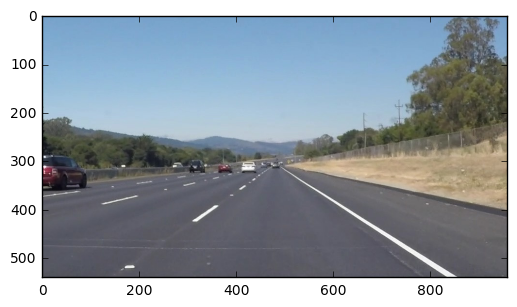

In [35]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [36]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

"""
Referred to discussions on the confluence pages listed below :
https://carnd-udacity.atlassian.net/wiki/questions/9176624/problem-with-code-in-extrapolating-lane-lines
https://carnd-udacity.atlassian.net/wiki/display/CAR/questions/6522495/tips-to-find-the-vertices-
"""
def draw_lines(img, lines, color=[255, 0, 0], thickness=5):

    left_segment_points = []
    left_slopes = [] 
    right_segment_points = [] 
    right_slopes = [] 
    min_left_y = 550
    min_right_y = 550

    for line in lines:
        for x1,y1,x2,y2 in line:
            #Calculating the slope to find the segments in left and right lines
            slope = float((y2-y1)/(x2-x1))
            print("x1=",x1," y1=",y1," x2=",x2," y2=",y2," slope=",slope)
            if slope > 0:#right line segments
                right_segment_points.append([x1,y1])
                right_segment_points.append([x2,y2])
                right_slopes.append(slope)
                if y1 < min_right_y:
                    min_right_y = y1
                elif y2 < min_left_y:
                    min_right_y = y2
                else:
                    pass
            elif slope <0: #left line segments
                left_segment_points.append([x1,y1])
                left_segment_points.append([x2,y2])
                left_slopes.append(slope)
                if y1 < min_left_y:
                    min_left_y = y1
                elif y2 < min_left_y:
                    min_left_y = y2
                else:
                    pass
            else:
                pass
    
    # Extrapolate for right line
    avg_right_slope = np.array(right_slopes).mean()
    print("Average right slope is ",avg_right_slope)
    avg_right_point = np.mean(np.array(right_segment_points), axis=0)
    print("Average right point = ", avg_right_point)
    right_y_intercept = avg_right_point[1] - avg_right_slope * avg_right_point[0]
    right_y_min = int(np.shape(img)[0]/1.65)
    max_right_y = image.shape[0]
    min_right_x = int((right_y_min - right_y_intercept)/avg_right_slope)
    max_right_x = int((max_right_y - right_y_intercept)/avg_right_slope)
    print("right_y_min = ",right_y_min," max_right_y = ",max_right_y," min_right_x = ", min_right_x, " max_right_x = ", max_right_x)
    cv2.line(img,(min_right_x, right_y_min), (max_right_x, max_right_y), color, thickness)
    
    
    # Extrapolate for left line
    avg_left_slope = np.array(left_slopes).mean()
    print("Average left slope is ",avg_left_slope)
    avg_left_point = np.mean(np.array(left_segment_points), axis=0)
    print("Average left point = ", avg_left_point)
    left_y_intercept = avg_left_point[1] - avg_left_slope * avg_left_point[0]
    left_y_min = int(np.shape(img)[0]/1.65)
    max_left_y = image.shape[0]
    min_left_x = int((left_y_min - left_y_intercept)/avg_left_slope)
    max_left_x = int((max_left_y - left_y_intercept)/avg_left_slope)
    print("left_y_min = ",left_y_min," max_left_y = ",max_left_y," min_left_x = ", min_left_x, " max_left_x = ", max_left_x)
    cv2.line(img,(min_left_x, left_y_min), (max_left_x, max_left_y), color, thickness)
  

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [37]:
import os
os.listdir("test_images/")

['.DS_Store',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [38]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [39]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    #Leveraged snippets from: https://carnd-udacity.atlassian.net/wiki/display/CAR/questions/6522495/tips-to-find-the-vertices-
    #create a copy
    image_copy = np.copy(image)
    gray = grayscale(image_copy)
    #apply gaussian blur on the grayscale image
    blur_gray = gaussian_blur(gray, 3)
    low_threshold = 100
    high_threshold = 200
    #apply canny algorithm
    edges = canny(blur_gray, low_threshold, high_threshold)  
    imageshape = image.shape
    xdimension = np.shape(image_copy)[1]
    ydimension = np.shape(image)[0]
    ymax = ydimension/1.65
    bottom_left = (10,ydimension-50)
    bottom_right = (xdimension-10,ydimension-50)
    top_right = (xdimension/2+40,ymax)
    top_left = (xdimension/2-40,ymax)
    vertices = np.array([[bottom_left,bottom_right,top_right,top_left]],dtype = np.int32)

    masked_edges = region_of_interest(edges, vertices)
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 5 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 50     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 100 #minimum number of pixels making up a line
    max_line_gap = 200    # maximum gap in pixels between connectable line segments
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    line_edges = weighted_img(lines, image)
    return line_edges

Let's try the one with the solid white lane on the right first ...

In [40]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

x1= 518  y1= 327  x2= 789  y2= 490  slope= 0.6014760147601476
x1= 514  y1= 327  x2= 691  y2= 438  slope= 0.6271186440677966
x1= 217  y1= 490  x2= 446  y2= 329  slope= -0.7030567685589519
x1= 234  y1= 490  x2= 427  y2= 339  slope= -0.7823834196891192
x1= 566  y1= 355  x2= 727  y2= 463  slope= 0.6708074534161491
x1= 245  y1= 483  x2= 359  y2= 388  slope= -0.8333333333333334
x1= 607  y1= 379  x2= 735  y2= 468  slope= 0.6953125
x1= 308  y1= 430  x2= 446  y2= 330  slope= -0.7246376811594203
x1= 642  y1= 400  x2= 746  y2= 475  slope= 0.7211538461538461
x1= 235  y1= 490  x2= 430  y2= 338  slope= -0.7794871794871795
x1= 530  y1= 334  x2= 631  y2= 393  slope= 0.5841584158415841
x1= 219  y1= 490  x2= 446  y2= 331  slope= -0.7004405286343612
Average right slope is  0.65000447904
Average right point =  [ 641.33333333  404.08333333]
right_y_min =  327  max_right_y =  540  min_right_x =  522  max_right_x =  850
Average left slope is  -0.753889818477
Average left point =  [ 334.33333333  410.66666667




  0%|          | 0/222 [00:00<?, ?it/s]

x1= 518  y1= 327  x2= 789  y2= 490  slope= 0.6014760147601476
x1= 514  y1= 327  x2= 691  y2= 438  slope= 0.6271186440677966
x1= 217  y1= 490  x2= 446  y2= 329  slope= -0.7030567685589519
x1= 234  y1= 490  x2= 427  y2= 339  slope= -0.7823834196891192
x1= 566  y1= 355  x2= 727  y2= 463  slope= 0.6708074534161491
x1= 245  y1= 483  x2= 359  y2= 388  slope= -0.8333333333333334
x1= 607  y1= 379  x2= 735  y2= 468  slope= 0.6953125
x1= 308  y1= 430  x2= 446  y2= 330  slope= -0.7246376811594203
x1= 642  y1= 400  x2= 746  y2= 475  slope= 0.7211538461538461
x1= 235  y1= 490  x2= 430  y2= 338  slope= -0.7794871794871795
x1= 530  y1= 334  x2= 631  y2= 393  slope= 0.5841584158415841
x1= 219  y1= 490  x2= 446  y2= 331  slope= -0.7004405286343612
Average right slope is  0.65000447904
Average right point =  [ 641.33333333  404.08333333]
right_y_min =  327  max_right_y =  540  min_right_x =  522  max_right_x =  850
Average left slope is  -0.753889818477
Average left point =  [ 334.33333333  410.66666667




  1%|          | 2/222 [00:00<00:19, 11.08it/s]

Average left slope is  -0.723282519162
Average left point =  [ 327.   415.4]
left_y_min =  327  max_left_y =  540  min_left_x =  449  max_left_x =  154


x1= 513  y1= 328  x2= 770  y2= 489  slope= 0.6264591439688716
x1= 518  y1= 327  x2= 789  y2= 490  slope= 0.6014760147601476
x1= 234  y1= 490  x2= 451  y2= 327  slope= -0.7511520737327189
x1= 336  y1= 404  x2= 447  y2= 327  slope= -0.6936936936936937
x1= 529  y1= 336  x2= 632  y2= 402  slope= 0.6407766990291263
x1= 245  y1= 469  x2= 426  y2= 346  slope= -0.6795580110497238
x1= 218  y1= 490  x2= 428  y2= 343  slope= -0.7
x1= 512  y1= 327  x2= 741  y2= 470  slope= 0.6244541484716157
x1= 217  y1= 490  x2= 382  y2= 378  slope= -0.6787878787878788
Average right slope is  0.623291501557
Average right point =  [ 625.5    396.125]
right_y_min =  327  max_right_y =  540  min_right_x =  514  max_right_x =  856
Average left slope is  -0.700638331453
Average left point =  [ 338.4  406.4]
left_y_min =  327  max_left_y =  540  min_left_x =  451  max_left_x =  147





  2%|▏         | 4/222 [00:00<00:18, 11.60it/s]

x1= 517  y1= 327  x2= 789  y2= 490  slope= 0.5992647058823529
x1= 513  y1= 328  x2= 772  y2= 490  slope= 0.6254826254826255
x1= 325  y1= 417  x2= 426  y2= 341  slope= -0.7524752475247525
x1= 512  y1= 327  x2= 717  y2= 455  slope= 0.624390243902439
x1= 322  y1= 414  x2= 446  y2= 327  slope= -0.7016129032258065
x1= 328  y1= 416  x2= 451  y2= 327  slope= -0.7235772357723578
x1= 517  y1= 329  x2= 696  y2= 433  slope= 0.5810055865921788
x1= 322  y1= 416  x2= 449  y2= 327  slope= -0.7007874015748031
Average right slope is  0.607535790465
Average right point =  [ 629.125  397.375]
right_y_min =  327  max_right_y =  540  min_right_x =  513  max_right_x =  863
Average left slope is  -0.719613197024
Average left point =  [ 383.625  373.125]
left_y_min =  327  max_left_y =  540  min_left_x =  447  max_left_x =  151


x1= 517  y1= 327  x2= 789  y2= 490  slope= 0.5992647058823529
x1= 513  y1= 327  x2= 721  y2= 457  slope= 0.625
x1= 313  y1= 429  x2= 448  y2= 328  slope= -0.7481481481481481
x1= 305  y1= 429  x2= 449  y2= 328  slope= -0.7013888888888888
x1= 305  y1= 426  x2= 446  y2= 327  slope= -0.7021276595744681
Average right slope is  0.612132352941
Average right point =  [ 635.    400.25]
right_y_min =  327  max_right_y =  540  min_right_x =  515  max_right_x =  863
Average left slope is  -0.717221565537
Average left point =  [ 377.66666667  377.83333333]
left_y_min =  327  max_left_y =  540  min_left_x =  448  max_left_x =  151





  2%|▏         | 5/222 [00:00<00:20, 10.51it/s]


  3%|▎         | 6/222 [00:00<00:21,  9.99it/s]

x1= 518  y1= 327  x2= 790  y2= 490  slope= 0.5992647058823529
x1= 514  y1= 327  x2= 739  y2= 468  slope= 0.6266666666666667
x1= 294  y1= 443  x2= 448  y2= 327  slope= -0.7532467532467533
x1= 283  y1= 441  x2= 446  y2= 327  slope= -0.6993865030674846
x1= 351  y1= 395  x2= 451  y2= 327  slope= -0.68
x1= 520  y1= 327  x2= 776  y2= 481  slope= 0.6015625
Average right slope is  0.609164624183
Average right point =  [ 642.83333333  403.33333333]
right_y_min =  327  max_right_y =  540  min_right_x =  517  max_right_x =  867
Average left slope is  -0.710877752105
Average left point =  [ 378.83333333  376.66666667]
left_y_min =  327  max_left_y =  540  min_left_x =  448  max_left_x =  149





  4%|▎         | 8/222 [00:00<00:18, 11.47it/s]

x1= 518  y1= 327  x2= 789  y2= 489  slope= 0.5977859778597786
x1= 513  y1= 327  x2= 774  y2= 490  slope= 0.6245210727969349
x1= 253  y1= 462  x2= 439  y2= 332  slope= -0.6989247311827957
x1= 520  y1= 327  x2= 792  y2= 490  slope= 0.5992647058823529
x1= 264  y1= 462  x2= 450  y2= 327  slope= -0.7258064516129032
x1= 270  y1= 462  x2= 418  y2= 346  slope= -0.7837837837837838
Average right slope is  0.607190585513
Average right point =  [ 651.          408.33333333]
right_y_min =  327  max_right_y =  540  min_right_x =  517  max_right_x =  867
Average left slope is  -0.736171655526
Average left point =  [ 349.   398.5]
left_y_min =  327  max_left_y =  540  min_left_x =  446  max_left_x =  156
x1= 518  y1= 327  x2= 790  y2= 490  slope= 0.5992647058823529
x1= 519  y1= 331  x2= 772  y2= 489  slope= 0.6245059288537549
x1= 214  y1= 489  x2= 437  y2= 333  slope= -0.6995515695067265
x1= 230  y1= 488  x2= 450  y2= 328  slope= -0.7272727272727273
x1= 522  y1= 328  x2= 792  y2= 490  slope= 0.6
x1= 2

x1= 518  y1= 327  x2= 789  y2= 490  slope= 0.6014760147601476
x1= 513  y1= 327  x2= 727  y2= 461  slope= 0.6261682242990654
x1= 309  y1= 422  x2= 445  y2= 327  slope= -0.6985294117647058
x1= 318  y1= 424  x2= 447  y2= 327  slope= -0.751937984496124
x1= 310  y1= 422  x2= 449  y2= 328  slope= -0.6762589928057554
x1= 624  y1= 398  x2= 771  y2= 490  slope= 0.6258503401360545
x1= 321  y1= 423  x2= 439  y2= 334  slope= -0.7542372881355932
x1= 525  y1= 334  x2= 684  y2= 426  slope= 0.5786163522012578
Average right slope is  0.608027732849
Average right point =  [ 643.875  406.625]
right_y_min =  327  max_right_y =  540  min_right_x =  512  max_right_x =  863
Average left slope is  -0.720240919301
Average left point =  [ 379.75   375.875]
left_y_min =  327  max_left_y =  540  min_left_x =  447  max_left_x =  151





  5%|▍         | 10/222 [00:00<00:20, 10.19it/s]

x1= 515  y1= 327  x2= 786  y2= 490  slope= 0.6014760147601476
x1= 585  y1= 375  x2= 768  y2= 490  slope= 0.6284153005464481
x1= 297  y1= 441  x2= 449  y2= 331  slope= -0.7236842105263158
x1= 513  y1= 329  x2= 659  y2= 414  slope= 0.5821917808219178
x1= 289  y1= 441  x2= 448  y2= 330  slope= -0.6981132075471698
x1= 289  y1= 439  x2= 448  y2= 327  slope= -0.7044025157232704
x1= 559  y1= 358  x2= 754  y2= 471  slope= 0.5794871794871795
Average right slope is  0.597892568904
Average right point =  [ 642.375  406.75 ]
right_y_min =  327  max_right_y =  540  min_right_x =  508  max_right_x =  865
Average left slope is  -0.708733311266
Average left point =  [ 370.          384.83333333]
left_y_min =  327  max_left_y =  540  min_left_x =  451  max_left_x =  151
x1= 508  y1= 327  x2= 780  y2= 490  slope= 0.5992647058823529
x1= 650  y1= 420  x2= 762  y2= 490  slope= 0.625
x1= 523  y1= 333  x2= 687  y2= 443  slope= 0.6707317073170732
x1= 277  y1= 459  x2= 449  y2= 329  slope= -0.7558139534883721





  5%|▌         | 12/222 [00:01<00:18, 11.13it/s]

x1= 540  y1= 347  x2= 682  y2= 442  slope= 0.6690140845070423
x1= 512  y1= 327  x2= 762  y2= 483  slope= 0.624
x1= 216  y1= 490  x2= 446  y2= 334  slope= -0.6782608695652174
x1= 232  y1= 490  x2= 430  y2= 341  slope= -0.7525252525252525
x1= 507  y1= 327  x2= 693  y2= 448  slope= 0.6505376344086021
x1= 217  y1= 490  x2= 450  y2= 327  slope= -0.6995708154506438
x1= 265  y1= 455  x2= 365  y2= 392  slope= -0.63
x1= 240  y1= 485  x2= 358  y2= 390  slope= -0.8050847457627118
Average right slope is  0.647850572972
Average right point =  [ 616.          395.66666667]
right_y_min =  327  max_right_y =  540  min_right_x =  510  max_right_x =  838
Average left slope is  -0.713088336661
Average left point =  [ 321.9  419.4]
left_y_min =  327  max_left_y =  540  min_left_x =  451  max_left_x =  152
x1= 516  y1= 327  x2= 777  y2= 490  slope= 0.6245210727969349
x1= 562  y1= 361  x2= 776  y2= 490  slope= 0.602803738317757
x1= 213  y1= 490  x2= 445  y2= 333  slope= -0.6767241379310345
x1= 541  y1= 346 




  6%|▋         | 14/222 [00:01<00:18, 11.22it/s]

x1= 518  y1= 327  x2= 779  y2= 490  slope= 0.6245210727969349
x1= 522  y1= 334  x2= 758  y2= 488  slope= 0.652542372881356
x1= 569  y1= 364  x2= 778  y2= 490  slope= 0.6028708133971292
x1= 343  y1= 404  x2= 443  y2= 329  slope= -0.75
x1= 210  y1= 490  x2= 443  y2= 333  slope= -0.6738197424892703
x1= 230  y1= 488  x2= 383  y2= 369  slope= -0.7777777777777778
x1= 516  y1= 329  x2= 669  y2= 429  slope= 0.6535947712418301
x1= 226  y1= 490  x2= 425  y2= 340  slope= -0.7537688442211056
x1= 256  y1= 465  x2= 415  y2= 353  slope= -0.7044025157232704
x1= 335  y1= 403  x2= 444  y2= 332  slope= -0.6513761467889908
Average right slope is  0.633382257579
Average right point =  [ 638.625  406.375]
right_y_min =  327  max_right_y =  540  min_right_x =  513  max_right_x =  849
Average left slope is  -0.718524171167
Average left point =  [ 346.08333333  399.66666667]
left_y_min =  327  max_left_y =  540  min_left_x =  447  max_left_x =  150





  7%|▋         | 16/222 [00:01<00:17, 11.60it/s]

x1= 535  y1= 339  x2= 692  y2= 444  slope= 0.6687898089171974
x1= 520  y1= 327  x2= 781  y2= 490  slope= 0.6245210727969349
x1= 219  y1= 489  x2= 441  y2= 328  slope= -0.7252252252252253
x1= 559  y1= 350  x2= 743  y2= 478  slope= 0.6956521739130435
x1= 321  y1= 411  x2= 429  y2= 341  slope= -0.6481481481481481
x1= 220  y1= 489  x2= 442  y2= 328  slope= -0.7252252252252253
x1= 320  y1= 410  x2= 443  y2= 330  slope= -0.6504065040650406
x1= 541  y1= 339  x2= 682  y2= 437  slope= 0.6950354609929078
x1= 658  y1= 414  x2= 779  y2= 490  slope= 0.628099173553719
x1= 613  y1= 384  x2= 746  y2= 480  slope= 0.7218045112781954
x1= 216  y1= 489  x2= 441  y2= 332  slope= -0.6977777777777778
Average right slope is  0.672317033575
Average right point =  [ 654.08333333  414.33333333]
right_y_min =  327  max_right_y =  540  min_right_x =  524  max_right_x =  840
Average left slope is  -0.689356576088
Average left point =  [ 349.2  394.7]
left_y_min =  327  max_left_y =  540  min_left_x =  447  max_left_




  8%|▊         | 18/222 [00:01<00:17, 11.61it/s]


  9%|▉         | 20/222 [00:01<00:16, 12.40it/s]

x1= 516  y1= 327  x2= 667  y2= 418  slope= 0.6026490066225165
x1= 521  y1= 327  x2= 763  y2= 490  slope= 0.6735537190082644
x1= 524  y1= 330  x2= 780  y2= 490  slope= 0.625
x1= 530  y1= 336  x2= 633  y2= 403  slope= 0.6504854368932039
x1= 283  y1= 437  x2= 424  y2= 345  slope= -0.6524822695035462
x1= 292  y1= 439  x2= 425  y2= 343  slope= -0.7218045112781954
x1= 638  y1= 407  x2= 740  y2= 464  slope= 0.5588235294117647
x1= 282  y1= 437  x2= 440  y2= 330  slope= -0.6772151898734177
x1= 515  y1= 327  x2= 706  y2= 452  slope= 0.6544502617801047
x1= 287  y1= 439  x2= 442  y2= 331  slope= -0.6967741935483871
x1= 526  y1= 334  x2= 700  y2= 439  slope= 0.603448275862069
Average right slope is  0.624058604225
Average right point =  [ 625.64285714  396.        ]
right_y_min =  327  max_right_y =  540  min_right_x =  515  max_right_x =  856
Average left slope is  -0.687069041051
Average left point =  [ 359.375  387.625]
left_y_min =  327  max_left_y =  540  min_left_x =  447  max_left_x =  137
x




 10%|▉         | 22/222 [00:01<00:15, 12.68it/s]

x1= 515  y1= 327  x2= 776  y2= 490  slope= 0.6245210727969349
x1= 516  y1= 327  x2= 758  y2= 490  slope= 0.6735537190082644
x1= 319  y1= 425  x2= 449  y2= 331  slope= -0.7230769230769231
x1= 310  y1= 424  x2= 447  y2= 328  slope= -0.7007299270072993
x1= 310  y1= 423  x2= 448  y2= 329  slope= -0.6811594202898551
Average right slope is  0.649037395903
Average right point =  [ 641.25  408.5 ]
right_y_min =  327  max_right_y =  540  min_right_x =  515  max_right_x =  843
Average left slope is  -0.701655423458
Average left point =  [ 380.5         376.66666667]
left_y_min =  327  max_left_y =  540  min_left_x =  451  max_left_x =  147
x1= 510  y1= 327  x2= 751  y2= 484  slope= 0.6514522821576764
x1= 515  y1= 327  x2= 776  y2= 490  slope= 0.6245210727969349
x1= 300  y1= 439  x2= 454  y2= 327  slope= -0.7272727272727273
x1= 290  y1= 438  x2= 445  y2= 329  slope= -0.7032258064516129
x1= 651  y1= 420  x2= 759  y2= 490  slope= 0.6481481481481481
x1= 299  y1= 439  x2= 453  y2= 327  slope= -0.7272




 11%|█         | 24/222 [00:02<00:16, 12.21it/s]

x1= 517  y1= 327  x2= 771  y2= 486  slope= 0.6259842519685039
x1= 517  y1= 331  x2= 728  y2= 469  slope= 0.6540284360189573
x1= 243  y1= 479  x2= 447  y2= 331  slope= -0.7254901960784313
x1= 232  y1= 479  x2= 446  y2= 329  slope= -0.7009345794392523
x1= 232  y1= 476  x2= 375  y2= 384  slope= -0.6433566433566433
x1= 565  y1= 362  x2= 777  y2= 490  slope= 0.6037735849056604
x1= 233  y1= 475  x2= 409  y2= 360  slope= -0.6534090909090909
x1= 242  y1= 479  x2= 446  y2= 331  slope= -0.7254901960784313
x1= 263  y1= 466  x2= 393  y2= 365  slope= -0.7769230769230769
x1= 521  y1= 330  x2= 759  y2= 490  slope= 0.6722689075630253
x1= 239  y1= 479  x2= 368  y2= 382  slope= -0.751937984496124
x1= 537  y1= 340  x2= 773  y2= 488  slope= 0.6271186440677966
x1= 281  y1= 442  x2= 514  y2= 328  slope= -0.4892703862660944
x1= 232  y1= 478  x2= 444  y2= 329  slope= -0.7028301886792453
x1= 244  y1= 479  x2= 436  y2= 340  slope= -0.7239583333333334
Average right slope is  0.636634764905
Average right point = 




 12%|█▏        | 26/222 [00:02<00:15, 12.95it/s]


 13%|█▎        | 28/222 [00:02<00:13, 14.26it/s]


 14%|█▎        | 30/222 [00:02<00:13, 14.69it/s]

x1= 520  y1= 329  x2= 777  y2= 490  slope= 0.6264591439688716
x1= 535  y1= 343  x2= 761  y2= 490  slope= 0.6504424778761062
x1= 239  y1= 471  x2= 452  y2= 327  slope= -0.676056338028169
x1= 230  y1= 490  x2= 416  y2= 355  slope= -0.7258064516129032
x1= 217  y1= 487  x2= 453  y2= 327  slope= -0.6779661016949152
x1= 338  y1= 403  x2= 451  y2= 327  slope= -0.672566371681416
x1= 242  y1= 469  x2= 399  y2= 367  slope= -0.6496815286624203
x1= 213  y1= 490  x2= 346  y2= 404  slope= -0.6466165413533834
Average right slope is  0.638450810922
Average right point =  [ 648.25  413.  ]
right_y_min =  327  max_right_y =  540  min_right_x =  513  max_right_x =  847
Average left slope is  -0.674782222172
Average left point =  [ 333.    409.75]
left_y_min =  327  max_left_y =  540  min_left_x =  455  max_left_x =  139
x1= 532  y1= 337  x2= 777  y2= 490  slope= 0.6244897959183674
x1= 522  y1= 334  x2= 737  y2= 474  slope= 0.6511627906976745
x1= 329  y1= 416  x2= 447  y2= 327  slope= -0.7542372881355932





 15%|█▍        | 33/222 [00:02<00:11, 16.70it/s]

x1= 517  y1= 328  x2= 765  y2= 482  slope= 0.6209677419354839
x1= 521  y1= 332  x2= 763  y2= 490  slope= 0.6528925619834711
x1= 269  y1= 459  x2= 438  y2= 332  slope= -0.7514792899408284
x1= 263  y1= 459  x2= 378  y2= 381  slope= -0.6782608695652174
x1= 259  y1= 459  x2= 447  y2= 327  slope= -0.7021276595744681
x1= 532  y1= 339  x2= 742  y2= 466  slope= 0.6047619047619047
x1= 266  y1= 459  x2= 441  y2= 332  slope= -0.7257142857142858
x1= 626  y1= 395  x2= 736  y2= 474  slope= 0.7181818181818181
x1= 267  y1= 459  x2= 449  y2= 327  slope= -0.7252747252747253
Average right slope is  0.649201006716
Average right point =  [ 650.25  413.25]
right_y_min =  327  max_right_y =  540  min_right_x =  517  max_right_x =  845
Average left slope is  -0.716571366014
Average left point =  [ 347.7  399.4]
left_y_min =  327  max_left_y =  540  min_left_x =  448  max_left_x =  151
x1= 533  y1= 340  x2= 763  y2= 490  slope= 0.6521739130434783
x1= 515  y1= 328  x2= 702  y2= 441  slope= 0.6042780748663101
x1




 16%|█▌        | 36/222 [00:02<00:10, 18.19it/s]


 18%|█▊        | 41/222 [00:02<00:08, 22.40it/s]

x1= 516  y1= 327  x2= 777  y2= 490  slope= 0.6245210727969349
x1= 512  y1= 327  x2= 685  y2= 443  slope= 0.6705202312138728
x1= 235  y1= 475  x2= 435  y2= 340  slope= -0.675
x1= 250  y1= 477  x2= 447  y2= 329  slope= -0.751269035532995
x1= 606  y1= 384  x2= 758  y2= 490  slope= 0.6973684210526315
x1= 517  y1= 327  x2= 636  y2= 404  slope= 0.6470588235294118
x1= 240  y1= 478  x2= 446  y2= 329  slope= -0.7233009708737864
x1= 247  y1= 478  x2= 412  y2= 358  slope= -0.7272727272727273
x1= 541  y1= 347  x2= 705  y2= 446  slope= 0.6036585365853658
x1= 236  y1= 477  x2= 410  y2= 359  slope= -0.6781609195402298
x1= 235  y1= 476  x2= 445  y2= 329  slope= -0.7
Average right slope is  0.648625417036
Average right point =  [ 625.3  398.5]
right_y_min =  327  max_right_y =  540  min_right_x =  515  max_right_x =  843
Average left slope is  -0.709167275537
Average left point =  [ 336.5   408.75]
left_y_min =  327  max_left_y =  540  min_left_x =  451  max_left_x =  151
x1= 536  y1= 340  x2= 776  y2=




 21%|██        | 46/222 [00:02<00:06, 26.51it/s]

Average left slope is  -0.762549457386
Average left point =  [ 364.25  386.75]
left_y_min =  327  max_left_y =  540  min_left_x =  442  max_left_x =  163
x1= 516  y1= 327  x2= 757  y2= 489  slope= 0.6721991701244814
x1= 521  y1= 327  x2= 679  y2= 429  slope= 0.6455696202531646
x1= 322  y1= 411  x2= 445  y2= 328  slope= -0.6747967479674797
x1= 288  y1= 446  x2= 433  y2= 333  slope= -0.7793103448275862
x1= 270  y1= 448  x2= 447  y2= 328  slope= -0.6779661016949152
x1= 556  y1= 350  x2= 750  y2= 472  slope= 0.6288659793814433
Average right slope is  0.648878256586
Average right point =  [ 629.83333333  399.        ]
right_y_min =  327  max_right_y =  540  min_right_x =  518  max_right_x =  847
Average left slope is  -0.71069106483
Average left point =  [ 367.5         382.33333333]
left_y_min =  327  max_left_y =  540  min_left_x =  445  max_left_x =  145
x1= 515  y1= 327  x2= 777  y2= 490  slope= 0.6221374045801527
x1= 584  y1= 367  x2= 714  y2= 461  slope= 0.7230769230769231
x1= 252  y1




 23%|██▎       | 50/222 [00:03<00:07, 22.39it/s]


 24%|██▍       | 53/222 [00:03<00:07, 23.67it/s]

x1= 518  y1= 327  x2= 693  y2= 437  slope= 0.6285714285714286
x1= 513  y1= 327  x2= 631  y2= 404  slope= 0.652542372881356
x1= 210  y1= 489  x2= 424  y2= 339  slope= -0.7009345794392523
x1= 660  y1= 425  x2= 775  y2= 489  slope= 0.5565217391304348
x1= 225  y1= 490  x2= 445  y2= 330  slope= -0.7272727272727273
x1= 289  y1= 439  x2= 442  y2= 328  slope= -0.7254901960784313
x1= 664  y1= 428  x2= 776  y2= 490  slope= 0.5535714285714286
x1= 549  y1= 345  x2= 754  y2= 488  slope= 0.697560975609756
x1= 261  y1= 465  x2= 443  y2= 328  slope= -0.7527472527472527
x1= 210  y1= 490  x2= 441  y2= 328  slope= -0.7012987012987013
Average right slope is  0.617753588953
Average right point =  [ 653.3  416. ]
right_y_min =  327  max_right_y =  540  min_right_x =  509  max_right_x =  854
Average left slope is  -0.721548691367
Average left point =  [ 339.   402.6]
left_y_min =  327  max_left_y =  540  min_left_x =  443  max_left_x =  148
x1= 513  y1= 327  x2= 773  y2= 489  slope= 0.6230769230769231
x1= 51




 25%|██▌       | 56/222 [00:03<00:09, 17.19it/s]

x1= 517  y1= 327  x2= 725  y2= 457  slope= 0.625
x1= 609  y1= 391  x2= 720  y2= 464  slope= 0.6576576576576577
x1= 572  y1= 366  x2= 750  y2= 473  slope= 0.601123595505618
x1= 281  y1= 436  x2= 443  y2= 327  slope= -0.6728395061728395
x1= 600  y1= 385  x2= 773  y2= 489  slope= 0.6011560693641619
x1= 292  y1= 437  x2= 449  y2= 327  slope= -0.7006369426751592
x1= 531  y1= 338  x2= 757  y2= 490  slope= 0.672566371681416
x1= 281  y1= 437  x2= 422  y2= 345  slope= -0.6524822695035462
x1= 290  y1= 437  x2= 437  y2= 330  slope= -0.7278911564625851
x1= 593  y1= 379  x2= 772  y2= 487  slope= 0.6033519553072626
x1= 564  y1= 359  x2= 759  y2= 490  slope= 0.6717948717948717
Average right slope is  0.633235788759
Average right point =  [ 660.14285714  421.07142857]
right_y_min =  327  max_right_y =  540  min_right_x =  511  max_right_x =  847
Average left slope is  -0.688462468704
Average left point =  [ 361.875  384.5  ]
left_y_min =  327  max_left_y =  540  min_left_x =  445  max_left_x =  136
x1




 27%|██▋       | 59/222 [00:03<00:09, 16.92it/s]

x1= 523  y1= 336  x2= 693  y2= 450  slope= 0.6705882352941176
x1= 512  y1= 327  x2= 773  y2= 490  slope= 0.6245210727969349
x1= 326  y1= 407  x2= 446  y2= 329  slope= -0.65
x1= 289  y1= 437  x2= 452  y2= 327  slope= -0.6748466257668712
x1= 645  y1= 417  x2= 756  y2= 490  slope= 0.6576576576576577
x1= 285  y1= 436  x2= 444  y2= 329  slope= -0.6729559748427673
x1= 345  y1= 398  x2= 446  y2= 330  slope= -0.6732673267326733
x1= 524  y1= 333  x2= 642  y2= 415  slope= 0.6949152542372882
Average right slope is  0.661920554996
Average right point =  [ 633.5   407.25]
right_y_min =  327  max_right_y =  540  min_right_x =  512  max_right_x =  834
Average left slope is  -0.667767481836
Average left point =  [ 379.125  374.125]
left_y_min =  327  max_left_y =  540  min_left_x =  449  max_left_x =  130
x1= 560  y1= 361  x2= 760  y2= 482  slope= 0.605
x1= 542  y1= 348  x2= 752  y2= 489  slope= 0.6714285714285714
x1= 269  y1= 455  x2= 452  y2= 327  slope= -0.6994535519125683
x1= 625  y1= 398  x2= 772




 28%|██▊       | 62/222 [00:03<00:09, 17.00it/s]


 29%|██▉       | 65/222 [00:04<00:08, 18.08it/s]

x1= 529  y1= 340  x2= 752  y2= 490  slope= 0.672645739910314
x1= 512  y1= 327  x2= 706  y2= 449  slope= 0.6288659793814433
x1= 202  y1= 490  x2= 452  y2= 327  slope= -0.652
x1= 219  y1= 490  x2= 424  y2= 341  slope= -0.7268292682926829
x1= 221  y1= 489  x2= 450  y2= 328  slope= -0.7030567685589519
x1= 508  y1= 327  x2= 769  y2= 490  slope= 0.6245210727969349
x1= 203  y1= 490  x2= 399  y2= 363  slope= -0.6479591836734694
x1= 343  y1= 394  x2= 451  y2= 327  slope= -0.6203703703703703
Average right slope is  0.642010930696
Average right point =  [ 629.33333333  403.83333333]
right_y_min =  327  max_right_y =  540  min_right_x =  509  max_right_x =  841
Average left slope is  -0.670043118179
Average left point =  [ 336.4  403.9]
left_y_min =  327  max_left_y =  540  min_left_x =  451  max_left_x =  133
x1= 508  y1= 327  x2= 750  y2= 490  slope= 0.6735537190082644
x1= 515  y1= 328  x2= 638  y2= 407  slope= 0.6422764227642277
x1= 204  y1= 490  x2= 396  y2= 366  slope= -0.6458333333333334
x1=




 31%|███       | 68/222 [00:04<00:08, 17.95it/s]

x1= 518  y1= 335  x2= 665  y2= 424  slope= 0.6054421768707483
x1= 508  y1= 327  x2= 750  y2= 490  slope= 0.6735537190082644
x1= 513  y1= 327  x2= 682  y2= 436  slope= 0.6449704142011834
x1= 278  y1= 441  x2= 448  y2= 327  slope= -0.6705882352941176
x1= 275  y1= 441  x2= 448  y2= 329  slope= -0.6473988439306358
x1= 276  y1= 439  x2= 421  y2= 344  slope= -0.6551724137931034
x1= 288  y1= 439  x2= 446  y2= 329  slope= -0.6962025316455697
x1= 512  y1= 327  x2= 628  y2= 402  slope= 0.646551724137931
x1= 627  y1= 408  x2= 769  y2= 490  slope= 0.5774647887323944
x1= 285  y1= 439  x2= 445  y2= 327  slope= -0.7
Average right slope is  0.62959656459
Average right point =  [ 617.2  396.6]
right_y_min =  327  max_right_y =  540  min_right_x =  506  max_right_x =  844
Average left slope is  -0.673872404933
Average left point =  [ 361.   385.5]
left_y_min =  327  max_left_y =  540  min_left_x =  447  max_left_x =  131
x1= 567  y1= 366  x2= 762  y2= 484  slope= 0.6051282051282051
x1= 516  y1= 327  x2=




 32%|███▏      | 72/222 [00:04<00:07, 19.74it/s]


 34%|███▍      | 75/222 [00:04<00:07, 20.99it/s]

x1= 510  y1= 327  x2= 749  y2= 489  slope= 0.6778242677824268
x1= 514  y1= 327  x2= 640  y2= 409  slope= 0.6507936507936508
x1= 212  y1= 490  x2= 442  y2= 329  slope= -0.7
x1= 238  y1= 462  x2= 403  y2= 359  slope= -0.6242424242424243
x1= 290  y1= 437  x2= 438  y2= 330  slope= -0.722972972972973
x1= 247  y1= 457  x2= 361  y2= 388  slope= -0.6052631578947368
x1= 237  y1= 474  x2= 424  y2= 339  slope= -0.7219251336898396
x1= 580  y1= 376  x2= 767  y2= 489  slope= 0.6042780748663101
x1= 270  y1= 441  x2= 426  y2= 343  slope= -0.6282051282051282
Average right slope is  0.644298664481
Average right point =  [ 626.66666667  402.83333333]
right_y_min =  327  max_right_y =  540  min_right_x =  508  max_right_x =  839
Average left slope is  -0.667101469501
Average left point =  [ 332.33333333  404.08333333]
left_y_min =  327  max_left_y =  540  min_left_x =  447  max_left_x =  128
x1= 509  y1= 327  x2= 750  y2= 490  slope= 0.6763485477178424
x1= 516  y1= 329  x2= 661  y2= 423  slope= 0.64827586




 36%|███▌      | 79/222 [00:04<00:06, 22.05it/s]


 37%|███▋      | 83/222 [00:04<00:05, 24.29it/s]

x1= 510  y1= 327  x2= 740  y2= 488  slope= 0.7
x1= 522  y1= 333  x2= 634  y2= 406  slope= 0.6517857142857143
x1= 511  y1= 327  x2= 762  y2= 490  slope= 0.649402390438247
x1= 259  y1= 454  x2= 446  y2= 328  slope= -0.6737967914438503
x1= 251  y1= 452  x2= 443  y2= 327  slope= -0.6510416666666666
x1= 555  y1= 360  x2= 693  y2= 454  slope= 0.6811594202898551
x1= 258  y1= 454  x2= 446  y2= 327  slope= -0.675531914893617
Average right slope is  0.670586881253
Average right point =  [ 615.875  398.125]
right_y_min =  327  max_right_y =  540  min_right_x =  509  max_right_x =  827
Average left slope is  -0.666790124335
Average left point =  [ 350.5         390.33333333]
left_y_min =  327  max_left_y =  540  min_left_x =  445  max_left_x =  126
x1= 511  y1= 327  x2= 762  y2= 490  slope= 0.649402390438247
x1= 528  y1= 341  x2= 632  y2= 412  slope= 0.6826923076923077
x1= 221  y1= 477  x2= 443  y2= 328  slope= -0.6711711711711712
x1= 224  y1= 477  x2= 446  y2= 327  slope= -0.6756756756756757
x1= 




 39%|███▊      | 86/222 [00:04<00:05, 22.99it/s]

x1= 512  y1= 328  x2= 759  y2= 489  slope= 0.6518218623481782
x1= 548  y1= 355  x2= 649  y2= 424  slope= 0.6831683168316832
x1= 255  y1= 447  x2= 443  y2= 329  slope= -0.6276595744680851
x1= 236  y1= 469  x2= 427  y2= 336  slope= -0.6963350785340314
x1= 243  y1= 465  x2= 443  y2= 330  slope= -0.675
x1= 517  y1= 327  x2= 741  y2= 490  slope= 0.7276785714285714
x1= 521  y1= 335  x2= 638  y2= 417  slope= 0.7008547008547008
x1= 225  y1= 467  x2= 440  y2= 327  slope= -0.6511627906976745
Average right slope is  0.690880862866
Average right point =  [ 610.625  395.625]
right_y_min =  327  max_right_y =  540  min_right_x =  511  max_right_x =  819
Average left slope is  -0.662539360925
Average left point =  [ 339.    396.25]
left_y_min =  327  max_left_y =  540  min_left_x =  443  max_left_x =  122
x1= 527  y1= 340  x2= 741  y2= 490  slope= 0.7009345794392523
x1= 510  y1= 327  x2= 710  y2= 457  slope= 0.65
x1= 191  y1= 490  x2= 441  y2= 328  slope= -0.648
x1= 208  y1= 489  x2= 443  y2= 330  sl




 40%|████      | 89/222 [00:05<00:05, 23.62it/s]


 41%|████▏     | 92/222 [00:05<00:05, 22.52it/s]

x1= 531  y1= 338  x2= 755  y2= 489  slope= 0.6741071428571429
x1= 586  y1= 382  x2= 740  y2= 490  slope= 0.7012987012987013
x1= 285  y1= 437  x2= 449  y2= 327  slope= -0.6707317073170732
x1= 344  y1= 391  x2= 446  y2= 328  slope= -0.6176470588235294
x1= 538  y1= 347  x2= 758  y2= 490  slope= 0.65
x1= 564  y1= 366  x2= 741  y2= 490  slope= 0.7005649717514124
x1= 274  y1= 438  x2= 422  y2= 346  slope= -0.6216216216216216
Average right slope is  0.681492703977
Average right point =  [ 651.625  424.   ]
right_y_min =  327  max_right_y =  540  min_right_x =  509  max_right_x =  821
Average left slope is  -0.636666795921
Average left point =  [ 370.          377.83333333]
left_y_min =  327  max_left_y =  540  min_left_x =  449  max_left_x =  115
x1= 532  y1= 339  x2= 756  y2= 490  slope= 0.6741071428571429
x1= 511  y1= 327  x2= 678  y2= 448  slope= 0.7245508982035929
x1= 255  y1= 456  x2= 420  y2= 349  slope= -0.6484848484848484
x1= 615  y1= 396  x2= 721  y2= 478  slope= 0.7735849056603774
x




 43%|████▎     | 96/222 [00:05<00:05, 23.99it/s]


 45%|████▍     | 99/222 [00:05<00:04, 24.66it/s]

x1= 521  y1= 327  x2= 709  y2= 458  slope= 0.6968085106382979
x1= 603  y1= 391  x2= 744  y2= 490  slope= 0.7021276595744681
x1= 287  y1= 429  x2= 447  y2= 329  slope= -0.625
x1= 243  y1= 468  x2= 409  y2= 356  slope= -0.6746987951807228
x1= 231  y1= 466  x2= 445  y2= 327  slope= -0.6495327102803738
x1= 522  y1= 331  x2= 758  y2= 490  slope= 0.673728813559322
x1= 516  y1= 328  x2= 694  y2= 457  slope= 0.7247191011235955
x1= 233  y1= 468  x2= 448  y2= 329  slope= -0.6465116279069767
x1= 518  y1= 328  x2= 711  y2= 469  slope= 0.7305699481865285
x1= 241  y1= 468  x2= 409  y2= 355  slope= -0.6726190476190477
Average right slope is  0.705590806616
Average right point =  [ 629.6  406.9]
right_y_min =  327  max_right_y =  540  min_right_x =  516  max_right_x =  818
Average left slope is  -0.653672436197
Average left point =  [ 339.3  399.5]
left_y_min =  327  max_left_y =  540  min_left_x =  450  max_left_x =  124
x1= 517  y1= 327  x2= 742  y2= 490  slope= 0.7244444444444444
x1= 525  y1= 332  




 46%|████▌     | 102/222 [00:05<00:04, 24.42it/s]


 47%|████▋     | 105/222 [00:05<00:04, 25.03it/s]

x1= 534  y1= 337  x2= 761  y2= 490  slope= 0.6740088105726872
x1= 528  y1= 333  x2= 745  y2= 490  slope= 0.7235023041474654
x1= 535  y1= 334  x2= 646  y2= 420  slope= 0.7747747747747747
x1= 311  y1= 420  x2= 445  y2= 330  slope= -0.6716417910447762
x1= 304  y1= 421  x2= 439  y2= 330  slope= -0.674074074074074
x1= 303  y1= 421  x2= 444  y2= 329  slope= -0.6524822695035462
x1= 530  y1= 335  x2= 742  y2= 489  slope= 0.7264150943396226
Average right slope is  0.724675245959
Average right point =  [ 627.625  403.5  ]
right_y_min =  327  max_right_y =  540  min_right_x =  522  max_right_x =  815
Average left slope is  -0.666066044874
Average left point =  [ 374.33333333  375.16666667]
left_y_min =  327  max_left_y =  540  min_left_x =  446  max_left_x =  126
x1= 520  y1= 327  x2= 760  y2= 489  slope= 0.675
x1= 625  y1= 404  x2= 744  y2= 490  slope= 0.7226890756302521
x1= 283  y1= 435  x2= 449  y2= 327  slope= -0.6506024096385542
x1= 521  y1= 327  x2= 645  y2= 420  slope= 0.75
x1= 294  y1= 43




 49%|████▊     | 108/222 [00:05<00:04, 25.44it/s]

x1= 521  y1= 327  x2= 762  y2= 489  slope= 0.6721991701244814
x1= 536  y1= 339  x2= 701  y2= 458  slope= 0.7212121212121212
x1= 271  y1= 448  x2= 423  y2= 342  slope= -0.6973684210526315
x1= 273  y1= 448  x2= 450  y2= 329  slope= -0.672316384180791
x1= 268  y1= 447  x2= 446  y2= 327  slope= -0.6741573033707865
x1= 274  y1= 448  x2= 447  y2= 327  slope= -0.6994219653179191
x1= 270  y1= 448  x2= 450  y2= 327  slope= -0.6722222222222223
x1= 529  y1= 331  x2= 748  y2= 490  slope= 0.726027397260274
x1= 546  y1= 343  x2= 764  y2= 490  slope= 0.6743119266055045
x1= 576  y1= 367  x2= 724  y2= 474  slope= 0.722972972972973
Average right slope is  0.703344717635
Average right point =  [ 640.7  410.8]
right_y_min =  327  max_right_y =  540  min_right_x =  521  max_right_x =  824
Average left slope is  -0.683097259229
Average left point =  [ 357.2  389.1]
left_y_min =  327  max_left_y =  540  min_left_x =  448  max_left_x =  136
x1= 521  y1= 327  x2= 735  y2= 471  slope= 0.6728971962616822
x1= 517




 50%|█████     | 111/222 [00:05<00:05, 19.91it/s]

x1= 517  y1= 328  x2= 749  y2= 490  slope= 0.6982758620689655
x1= 546  y1= 343  x2= 765  y2= 490  slope= 0.6712328767123288
x1= 203  y1= 490  x2= 455  y2= 327  slope= -0.6468253968253969
x1= 225  y1= 488  x2= 443  y2= 330  slope= -0.7247706422018348
x1= 515  y1= 328  x2= 642  y2= 408  slope= 0.6299212598425197
x1= 264  y1= 456  x2= 395  y2= 361  slope= -0.7251908396946565
x1= 219  y1= 490  x2= 446  y2= 331  slope= -0.7004405286343612
x1= 629  y1= 400  x2= 736  y2= 470  slope= 0.6542056074766355
x1= 568  y1= 358  x2= 693  y2= 452  slope= 0.752
Average right slope is  0.68112712122
Average right point =  [ 636.   406.7]
right_y_min =  327  max_right_y =  540  min_right_x =  518  max_right_x =  831
Average left slope is  -0.699306851839
Average left point =  [ 331.25   409.125]
left_y_min =  327  max_left_y =  540  min_left_x =  448  max_left_x =  144
x1= 549  y1= 345  x2= 763  y2= 489  slope= 0.6728971962616822
x1= 529  y1= 336  x2= 750  y2= 490  slope= 0.6968325791855203
x1= 322  y1= 41




 51%|█████▏    | 114/222 [00:06<00:05, 18.13it/s]


 52%|█████▏    | 116/222 [00:06<00:06, 17.66it/s]


 53%|█████▎    | 118/222 [00:06<00:05, 17.70it/s]

x1= 538  y1= 337  x2= 696  y2= 451  slope= 0.7215189873417721
x1= 524  y1= 333  x2= 718  y2= 455  slope= 0.6288659793814433
x1= 639  y1= 402  x2= 752  y2= 490  slope= 0.7787610619469026
x1= 259  y1= 453  x2= 453  y2= 327  slope= -0.6494845360824743
x1= 527  y1= 330  x2= 664  y2= 419  slope= 0.6496350364963503
x1= 270  y1= 452  x2= 439  y2= 333  slope= -0.7041420118343196
x1= 543  y1= 344  x2= 742  y2= 483  slope= 0.6984924623115578
x1= 521  y1= 327  x2= 748  y2= 475  slope= 0.6519823788546255
x1= 273  y1= 452  x2= 452  y2= 327  slope= -0.6983240223463687
x1= 260  y1= 451  x2= 374  y2= 375  slope= -0.6666666666666666
x1= 274  y1= 452  x2= 440  y2= 332  slope= -0.7228915662650602
Average right slope is  0.688209317722
Average right point =  [ 634.33333333  403.83333333]
right_y_min =  327  max_right_y =  540  min_right_x =  522  max_right_x =  832
Average left slope is  -0.688301760639
Average left point =  [ 349.4  395.4]
left_y_min =  327  max_left_y =  540  min_left_x =  448  max_left




 54%|█████▍    | 120/222 [00:06<00:05, 18.01it/s]


 55%|█████▍    | 122/222 [00:06<00:05, 16.82it/s]

x1= 523  y1= 328  x2= 755  y2= 490  slope= 0.6982758620689655
x1= 522  y1= 332  x2= 775  y2= 490  slope= 0.6245059288537549
x1= 279  y1= 444  x2= 435  y2= 335  slope= -0.6987179487179487
x1= 534  y1= 335  x2= 773  y2= 490  slope= 0.6485355648535565
x1= 280  y1= 444  x2= 450  y2= 329  slope= -0.6764705882352942
x1= 273  y1= 444  x2= 447  y2= 327  slope= -0.6724137931034483
x1= 276  y1= 444  x2= 377  y2= 373  slope= -0.7029702970297029
x1= 633  y1= 398  x2= 754  y2= 489  slope= 0.7520661157024794
x1= 282  y1= 444  x2= 437  y2= 339  slope= -0.6774193548387096
Average right slope is  0.68084586787
Average right point =  [ 658.625  419.   ]
right_y_min =  327  max_right_y =  540  min_right_x =  523  max_right_x =  836
Average left slope is  -0.685598396385
Average left point =  [ 353.6  392.3]
left_y_min =  327  max_left_y =  540  min_left_x =  448  max_left_x =  138
x1= 519  y1= 327  x2= 648  y2= 417  slope= 0.6976744186046512
x1= 588  y1= 370  x2= 746  y2= 484  slope= 0.7215189873417721
x




 56%|█████▋    | 125/222 [00:06<00:05, 18.08it/s]

x1= 518  y1= 327  x2= 685  y2= 432  slope= 0.6287425149700598
x1= 577  y1= 370  x2= 774  y2= 489  slope= 0.6040609137055838
x1= 341  y1= 401  x2= 447  y2= 334  slope= -0.6320754716981132
x1= 203  y1= 490  x2= 453  y2= 328  slope= -0.648
x1= 516  y1= 328  x2= 757  y2= 490  slope= 0.6721991701244814
x1= 222  y1= 489  x2= 342  y2= 399  slope= -0.75
x1= 514  y1= 327  x2= 775  y2= 490  slope= 0.6245210727969349
x1= 345  y1= 402  x2= 456  y2= 327  slope= -0.6756756756756757
x1= 581  y1= 371  x2= 758  y2= 490  slope= 0.672316384180791
x1= 219  y1= 490  x2= 452  y2= 327  slope= -0.6995708154506438
x1= 559  y1= 358  x2= 672  y2= 424  slope= 0.584070796460177
Average right slope is  0.63098514204
Average right point =  [ 640.5  408. ]
right_y_min =  327  max_right_y =  540  min_right_x =  512  max_right_x =  849
Average left slope is  -0.681064392565
Average left point =  [ 348.   398.7]
left_y_min =  327  max_left_y =  540  min_left_x =  453  max_left_x =  140
x1= 514  y1= 327  x2= 775  y2= 490




 57%|█████▋    | 127/222 [00:06<00:05, 16.56it/s]


 59%|█████▊    | 130/222 [00:07<00:05, 16.82it/s]

x1= 514  y1= 327  x2= 737  y2= 472  slope= 0.6502242152466368
x1= 521  y1= 327  x2= 780  y2= 489  slope= 0.6254826254826255
x1= 274  y1= 451  x2= 425  y2= 349  slope= -0.6754966887417219
x1= 520  y1= 327  x2= 620  y2= 391  slope= 0.64
x1= 269  y1= 453  x2= 454  y2= 328  slope= -0.6756756756756757
x1= 268  y1= 453  x2= 439  y2= 334  slope= -0.695906432748538
x1= 597  y1= 375  x2= 697  y2= 447  slope= 0.72
x1= 283  y1= 450  x2= 453  y2= 327  slope= -0.7235294117647059
x1= 529  y1= 333  x2= 780  y2= 490  slope= 0.6254980079681275
Average right slope is  0.652240969739
Average right point =  [ 629.5  397.8]
right_y_min =  327  max_right_y =  540  min_right_x =  520  max_right_x =  847
Average left slope is  -0.692652052233
Average left point =  [ 358.125  393.125]
left_y_min =  327  max_left_y =  540  min_left_x =  453  max_left_x =  146
x1= 538  y1= 343  x2= 780  y2= 489  slope= 0.6033057851239669
x1= 520  y1= 327  x2= 762  y2= 490  slope= 0.6735537190082644
x1= 234  y1= 474  x2= 452  y2=




 59%|█████▉    | 132/222 [00:07<00:05, 15.58it/s]


 60%|██████    | 134/222 [00:07<00:05, 16.28it/s]

x1= 514  y1= 327  x2= 631  y2= 403  slope= 0.6495726495726496
x1= 519  y1= 327  x2= 760  y2= 489  slope= 0.6721991701244814
x1= 569  y1= 364  x2= 732  y2= 459  slope= 0.5828220858895705
x1= 280  y1= 445  x2= 429  y2= 348  slope= -0.6510067114093959
x1= 512  y1= 327  x2= 753  y2= 472  slope= 0.6016597510373444
x1= 290  y1= 447  x2= 455  y2= 327  slope= -0.7272727272727273
x1= 524  y1= 329  x2= 763  y2= 490  slope= 0.6736401673640168
x1= 595  y1= 381  x2= 767  y2= 481  slope= 0.5813953488372093
x1= 280  y1= 446  x2= 456  y2= 327  slope= -0.6761363636363636
x1= 308  y1= 435  x2= 411  y2= 355  slope= -0.7766990291262136
x1= 318  y1= 428  x2= 424  y2= 346  slope= -0.7735849056603774
x1= 540  y1= 345  x2= 781  y2= 490  slope= 0.6016597510373444
Average right slope is  0.623278417695
Average right point =  [ 640.  406.]
right_y_min =  327  max_right_y =  540  min_right_x =  513  max_right_x =  854
Average left slope is  -0.720939947421
Average left point =  [ 365.1  390.4]
left_y_min =  327  




 61%|██████▏   | 136/222 [00:07<00:05, 14.62it/s]

x1= 524  y1= 330  x2= 663  y2= 423  slope= 0.6690647482014388
x1= 553  y1= 347  x2= 782  y2= 490  slope= 0.6244541484716157
x1= 213  y1= 490  x2= 449  y2= 331  slope= -0.673728813559322
x1= 230  y1= 490  x2= 431  y2= 339  slope= -0.7512437810945274
x1= 579  y1= 362  x2= 727  y2= 465  slope= 0.6959459459459459
x1= 526  y1= 329  x2= 763  y2= 489  slope= 0.6751054852320675
x1= 214  y1= 490  x2= 435  y2= 341  slope= -0.6742081447963801
x1= 215  y1= 488  x2= 449  y2= 330  slope= -0.6752136752136753
x1= 521  y1= 329  x2= 627  y2= 400  slope= 0.6698113207547169
x1= 229  y1= 490  x2= 426  y2= 342  slope= -0.751269035532995
Average right slope is  0.666876329721
Average right point =  [ 626.5  396.4]
right_y_min =  327  max_right_y =  540  min_right_x =  522  max_right_x =  841
Average left slope is  -0.705132690039
Average left point =  [ 329.1  413.1]
left_y_min =  327  max_left_y =  540  min_left_x =  451  max_left_x =  149
x1= 534  y1= 337  x2= 764  y2= 476  slope= 0.6043478260869565
x1= 53




 62%|██████▏   | 138/222 [00:07<00:05, 14.55it/s]


 63%|██████▎   | 140/222 [00:07<00:05, 14.85it/s]

x1= 529  y1= 330  x2= 786  y2= 490  slope= 0.622568093385214
x1= 647  y1= 412  x2= 761  y2= 484  slope= 0.631578947368421
x1= 308  y1= 432  x2= 444  y2= 330  slope= -0.75
x1= 520  y1= 327  x2= 633  y2= 403  slope= 0.672566371681416
x1= 298  y1= 432  x2= 446  y2= 332  slope= -0.6756756756756757
x1= 518  y1= 327  x2= 769  y2= 490  slope= 0.649402390438247
x1= 307  y1= 428  x2= 443  y2= 330  slope= -0.7205882352941176
x1= 298  y1= 431  x2= 446  y2= 331  slope= -0.6756756756756757
x1= 298  y1= 430  x2= 446  y2= 330  slope= -0.6756756756756757
x1= 549  y1= 346  x2= 786  y2= 489  slope= 0.6033755274261603
Average right slope is  0.63589826606
Average right point =  [ 649.8  409.8]
right_y_min =  327  max_right_y =  540  min_right_x =  519  max_right_x =  854
Average left slope is  -0.699523052464
Average left point =  [ 373.4  380.6]
left_y_min =  327  max_left_y =  540  min_left_x =  450  max_left_x =  145
x1= 517  y1= 327  x2= 691  y2= 432  slope= 0.603448275862069
x1= 529  y1= 330  x2= 66




 64%|██████▍   | 142/222 [00:07<00:05, 13.92it/s]


 65%|██████▌   | 145/222 [00:08<00:04, 16.05it/s]

x1= 530  y1= 333  x2= 763  y2= 490  slope= 0.6738197424892703
x1= 512  y1= 327  x2= 762  y2= 490  slope= 0.652
x1= 549  y1= 350  x2= 781  y2= 490  slope= 0.603448275862069
x1= 317  y1= 430  x2= 452  y2= 329  slope= -0.7481481481481481
x1= 307  y1= 429  x2= 458  y2= 327  slope= -0.6754966887417219
x1= 518  y1= 327  x2= 780  y2= 490  slope= 0.6221374045801527
x1= 514  y1= 328  x2= 743  y2= 477  slope= 0.6506550218340611
x1= 348  y1= 399  x2= 453  y2= 331  slope= -0.6476190476190476
x1= 307  y1= 430  x2= 452  y2= 332  slope= -0.6758620689655173
Average right slope is  0.640412088953
Average right point =  [ 645.2  410.2]
right_y_min =  327  max_right_y =  540  min_right_x =  515  max_right_x =  847
Average left slope is  -0.686781488369
Average left point =  [ 386.75   375.875]
left_y_min =  327  max_left_y =  540  min_left_x =  457  max_left_x =  147
x1= 529  y1= 333  x2= 762  y2= 490  slope= 0.6738197424892703
x1= 513  y1= 328  x2= 627  y2= 400  slope= 0.631578947368421
x1= 512  y1= 327




 66%|██████▌   | 147/222 [00:08<00:04, 15.07it/s]


 68%|██████▊   | 150/222 [00:08<00:04, 17.01it/s]

x1= 521  y1= 329  x2= 770  y2= 490  slope= 0.6465863453815262
x1= 530  y1= 331  x2= 786  y2= 490  slope= 0.62109375
x1= 235  y1= 490  x2= 447  y2= 330  slope= -0.7547169811320755
x1= 220  y1= 490  x2= 405  y2= 365  slope= -0.6756756756756757
x1= 219  y1= 490  x2= 434  y2= 339  slope= -0.7023255813953488
x1= 517  y1= 327  x2= 768  y2= 490  slope= 0.649402390438247
x1= 279  y1= 451  x2= 456  y2= 327  slope= -0.7005649717514124
x1= 567  y1= 358  x2= 697  y2= 434  slope= 0.5846153846153846
Average right slope is  0.625424467609
Average right point =  [ 644.5    406.125]
right_y_min =  327  max_right_y =  540  min_right_x =  517  max_right_x =  858
Average left slope is  -0.708320802489
Average left point =  [ 336.875  410.25 ]
left_y_min =  327  max_left_y =  540  min_left_x =  454  max_left_x =  153
x1= 520  y1= 328  x2= 769  y2= 489  slope= 0.6465863453815262
x1= 677  y1= 421  x2= 789  y2= 490  slope= 0.6160714285714286
x1= 531  y1= 331  x2= 686  y2= 435  slope= 0.6709677419354839
x1= 63




 69%|██████▉   | 153/222 [00:08<00:03, 19.46it/s]


 70%|███████   | 156/222 [00:08<00:03, 21.46it/s]

Average left slope is  -0.726867799073
Average left point =  [ 352.75  401.75]
left_y_min =  327  max_left_y =  540  min_left_x =  455  max_left_x =  162
x1= 564  y1= 351  x2= 788  y2= 490  slope= 0.6205357142857143
x1= 521  y1= 327  x2= 772  y2= 490  slope= 0.649402390438247
x1= 327  y1= 416  x2= 454  y2= 327  slope= -0.7007874015748031
x1= 517  y1= 328  x2= 657  y2= 416  slope= 0.6285714285714286
x1= 567  y1= 353  x2= 771  y2= 490  slope= 0.6715686274509803
x1= 337  y1= 417  x2= 454  y2= 329  slope= -0.7521367521367521
x1= 541  y1= 338  x2= 732  y2= 466  slope= 0.6701570680628273
x1= 599  y1= 373  x2= 737  y2= 469  slope= 0.6956521739130435
x1= 338  y1= 416  x2= 452  y2= 327  slope= -0.7807017543859649
x1= 524  y1= 332  x2= 663  y2= 413  slope= 0.5827338129496403
Average right slope is  0.645517316525
Average right point =  [ 639.5         402.57142857]
right_y_min =  327  max_right_y =  540  min_right_x =  522  max_right_x =  852
Average left slope is  -0.744541969366
Average left p




 72%|███████▏  | 159/222 [00:08<00:02, 23.24it/s]


 73%|███████▎  | 162/222 [00:08<00:02, 23.09it/s]

x1= 518  y1= 327  x2= 735  y2= 453  slope= 0.5806451612903226
x1= 557  y1= 346  x2= 687  y2= 433  slope= 0.6692307692307692
x1= 307  y1= 433  x2= 440  y2= 340  slope= -0.6992481203007519
x1= 223  y1= 490  x2= 451  y2= 330  slope= -0.7017543859649122
x1= 526  y1= 329  x2= 795  y2= 490  slope= 0.5985130111524164
x1= 301  y1= 444  x2= 450  y2= 328  slope= -0.7785234899328859
x1= 527  y1= 333  x2= 778  y2= 490  slope= 0.6254980079681275
x1= 310  y1= 433  x2= 451  y2= 331  slope= -0.723404255319149
x1= 243  y1= 488  x2= 448  y2= 328  slope= -0.7804878048780488
x1= 550  y1= 342  x2= 656  y2= 413  slope= 0.6698113207547169
x1= 240  y1= 490  x2= 432  y2= 340  slope= -0.78125
Average right slope is  0.628739654079
Average right point =  [ 632.9  395.6]
right_y_min =  327  max_right_y =  540  min_right_x =  523  max_right_x =  862
Average left slope is  -0.744111342733
Average left point =  [ 358.          397.91666667]
left_y_min =  327  max_left_y =  540  min_left_x =  453  max_left_x =  167
x




 74%|███████▍  | 165/222 [00:08<00:02, 22.56it/s]

x1= 518  y1= 327  x2= 682  y2= 418  slope= 0.5548780487804879
x1= 521  y1= 329  x2= 714  y2= 445  slope= 0.6010362694300518
x1= 287  y1= 451  x2= 445  y2= 332  slope= -0.7531645569620253
x1= 286  y1= 451  x2= 457  y2= 327  slope= -0.7251461988304093
x1= 301  y1= 449  x2= 429  y2= 345  slope= -0.8125
x1= 285  y1= 451  x2= 431  y2= 345  slope= -0.726027397260274
x1= 526  y1= 329  x2= 729  y2= 446  slope= 0.5763546798029556
Average right slope is  0.577422999338
Average right point =  [ 615.          382.33333333]
right_y_min =  327  max_right_y =  540  min_right_x =  519  max_right_x =  888
Average left slope is  -0.754209538263
Average left point =  [ 365.125  393.875]
left_y_min =  327  max_left_y =  540  min_left_x =  453  max_left_x =  171
x1= 529  y1= 330  x2= 785  y2= 490  slope= 0.625
x1= 608  y1= 382  x2= 759  y2= 463  slope= 0.5364238410596026
x1= 262  y1= 471  x2= 454  y2= 327  slope= -0.75
x1= 516  y1= 327  x2= 728  y2= 445  slope= 0.5566037735849056
x1= 273  y1= 471  x2= 456 




 76%|███████▌  | 168/222 [00:09<00:02, 21.95it/s]


 77%|███████▋  | 171/222 [00:09<00:02, 19.97it/s]

x1= 519  y1= 327  x2= 801  y2= 490  slope= 0.5780141843971631
x1= 557  y1= 354  x2= 658  y2= 413  slope= 0.5841584158415841
x1= 275  y1= 462  x2= 453  y2= 332  slope= -0.7303370786516854
x1= 302  y1= 452  x2= 453  y2= 330  slope= -0.8079470198675497
x1= 513  y1= 327  x2= 784  y2= 490  slope= 0.6014760147601476
x1= 298  y1= 455  x2= 436  y2= 340  slope= -0.8333333333333334
x1= 275  y1= 463  x2= 421  y2= 357  slope= -0.726027397260274
x1= 285  y1= 455  x2= 451  y2= 330  slope= -0.7530120481927711
Average right slope is  0.587882871666
Average right point =  [ 638.66666667  400.16666667]
right_y_min =  327  max_right_y =  540  min_right_x =  514  max_right_x =  876
Average left slope is  -0.770131375461
Average left point =  [ 364.9  397.6]
left_y_min =  327  max_left_y =  540  min_left_x =  456  max_left_x =  179
x1= 519  y1= 327  x2= 801  y2= 490  slope= 0.5780141843971631
x1= 307  y1= 448  x2= 452  y2= 331  slope= -0.8068965517241379
x1= 513  y1= 327  x2= 761  y2= 476  slope= 0.6008064




 78%|███████▊  | 174/222 [00:09<00:02, 20.16it/s]

x1= 515  y1= 327  x2= 797  y2= 489  slope= 0.574468085106383
x1= 616  y1= 390  x2= 720  y2= 451  slope= 0.5865384615384616
x1= 520  y1= 327  x2= 643  y2= 400  slope= 0.5934959349593496
x1= 263  y1= 474  x2= 457  y2= 328  slope= -0.7525773195876289
x1= 537  y1= 341  x2= 718  y2= 442  slope= 0.5580110497237569
x1= 591  y1= 375  x2= 738  y2= 454  slope= 0.5374149659863946
x1= 266  y1= 473  x2= 447  y2= 332  slope= -0.7790055248618785
x1= 568  y1= 361  x2= 782  y2= 490  slope= 0.602803738317757
x1= 272  y1= 473  x2= 450  y2= 334  slope= -0.7808988764044944
x1= 625  y1= 395  x2= 783  y2= 490  slope= 0.6012658227848101
x1= 272  y1= 474  x2= 454  y2= 327  slope= -0.8076923076923077
x1= 514  y1= 327  x2= 675  y2= 424  slope= 0.6024844720496895
x1= 255  y1= 490  x2= 450  y2= 332  slope= -0.8102564102564103
Average right slope is  0.582060316308
Average right point =  [ 646.375   405.1875]
right_y_min =  327  max_right_y =  540  min_right_x =  512  max_right_x =  877
Average left slope is  -0.78




 80%|███████▉  | 177/222 [00:09<00:02, 17.31it/s]


 81%|████████  | 179/222 [00:09<00:02, 17.82it/s]

x1= 521  y1= 327  x2= 802  y2= 490  slope= 0.5800711743772242
x1= 594  y1= 376  x2= 783  y2= 490  slope= 0.6031746031746031
x1= 570  y1= 361  x2= 798  y2= 488  slope= 0.5570175438596491
x1= 280  y1= 468  x2= 429  y2= 351  slope= -0.785234899328859
x1= 583  y1= 369  x2= 700  y2= 432  slope= 0.5384615384615384
x1= 268  y1= 469  x2= 456  y2= 327  slope= -0.7553191489361702
x1= 270  y1= 466  x2= 445  y2= 334  slope= -0.7542857142857143
x1= 281  y1= 468  x2= 389  y2= 384  slope= -0.7777777777777778
x1= 518  y1= 328  x2= 800  y2= 490  slope= 0.574468085106383
x1= 353  y1= 404  x2= 456  y2= 329  slope= -0.7281553398058253
Average right slope is  0.570638588996
Average right point =  [ 666.9  415.1]
right_y_min =  327  max_right_y =  540  min_right_x =  512  max_right_x =  885
Average left slope is  -0.760154576027
Average left point =  [ 362.7  400. ]
left_y_min =  327  max_left_y =  540  min_left_x =  458  max_left_x =  178
x1= 517  y1= 328  x2= 799  y2= 490  slope= 0.574468085106383
x1= 548




 82%|████████▏ | 181/222 [00:09<00:02, 17.60it/s]


 82%|████████▏ | 183/222 [00:10<00:02, 17.10it/s]

x1= 529  y1= 330  x2= 786  y2= 490  slope= 0.622568093385214
x1= 568  y1= 357  x2= 781  y2= 476  slope= 0.5586854460093896
x1= 282  y1= 460  x2= 444  y2= 338  slope= -0.7530864197530864
x1= 293  y1= 461  x2= 418  y2= 353  slope= -0.864
x1= 589  y1= 370  x2= 803  y2= 489  slope= 0.5560747663551402
x1= 288  y1= 461  x2= 453  y2= 328  slope= -0.806060606060606
x1= 290  y1= 461  x2= 453  y2= 329  slope= -0.8098159509202454
x1= 298  y1= 458  x2= 438  y2= 337  slope= -0.8642857142857143
x1= 292  y1= 451  x2= 393  y2= 380  slope= -0.7029702970297029
Average right slope is  0.57910943525
Average right point =  [ 676.          418.66666667]
right_y_min =  327  max_right_y =  540  min_right_x =  517  max_right_x =  885
Average left slope is  -0.800036498008
Average left point =  [ 361.83333333  401.41666667]
left_y_min =  327  max_left_y =  540  min_left_x =  454  max_left_x =  188
x1= 549  y1= 344  x2= 741  y2= 463  slope= 0.6197916666666666
x1= 534  y1= 332  x2= 705  y2= 434  slope= 0.59649122




 83%|████████▎ | 185/222 [00:10<00:02, 16.46it/s]

x1= 529  y1= 330  x2= 786  y2= 490  slope= 0.622568093385214
x1= 519  y1= 327  x2= 654  y2= 402  slope= 0.5555555555555556
x1= 588  y1= 369  x2= 702  y2= 430  slope= 0.5350877192982456
x1= 258  y1= 490  x2= 448  y2= 330  slope= -0.8421052631578947
x1= 242  y1= 490  x2= 439  y2= 342  slope= -0.751269035532995
x1= 568  y1= 351  x2= 668  y2= 418  slope= 0.67
x1= 612  y1= 379  x2= 789  y2= 482  slope= 0.5819209039548022
x1= 259  y1= 490  x2= 450  y2= 330  slope= -0.837696335078534
x1= 269  y1= 471  x2= 436  y2= 340  slope= -0.7844311377245509
x1= 278  y1= 470  x2= 455  y2= 327  slope= -0.807909604519774
x1= 243  y1= 490  x2= 438  y2= 343  slope= -0.7538461538461538
x1= 264  y1= 473  x2= 449  y2= 329  slope= -0.7783783783783784
Average right slope is  0.593026454439
Average right point =  [ 641.5  397.8]
right_y_min =  327  max_right_y =  540  min_right_x =  522  max_right_x =  881
Average left slope is  -0.793662272605
Average left point =  [ 352.          408.21428571]
left_y_min =  327  




 84%|████████▍ | 187/222 [00:10<00:02, 16.21it/s]


 85%|████████▌ | 189/222 [00:10<00:02, 14.81it/s]

x1= 588  y1= 368  x2= 808  y2= 490  slope= 0.5545454545454546
x1= 549  y1= 340  x2= 790  y2= 490  slope= 0.6224066390041494
x1= 529  y1= 330  x2= 693  y2= 432  slope= 0.6219512195121951
x1= 643  y1= 395  x2= 757  y2= 471  slope= 0.6666666666666666
x1= 274  y1= 465  x2= 431  y2= 347  slope= -0.7515923566878981
x1= 271  y1= 469  x2= 452  y2= 328  slope= -0.7790055248618785
x1= 533  y1= 332  x2= 806  y2= 490  slope= 0.5787545787545788
x1= 286  y1= 466  x2= 446  y2= 331  slope= -0.84375
x1= 269  y1= 467  x2= 443  y2= 331  slope= -0.7816091954022989
x1= 282  y1= 466  x2= 444  y2= 331  slope= -0.8333333333333334
x1= 269  y1= 468  x2= 454  y2= 328  slope= -0.7567567567567568
Average right slope is  0.608864911697
Average right point =  [ 669.6  413.8]
right_y_min =  327  max_right_y =  540  min_right_x =  527  max_right_x =  876
Average left slope is  -0.791007861174
Average left point =  [ 360.08333333  399.75      ]
left_y_min =  327  max_left_y =  540  min_left_x =  452  max_left_x =  182





 86%|████████▋ | 192/222 [00:10<00:01, 15.70it/s]


 87%|████████▋ | 194/222 [00:10<00:01, 16.28it/s]


 88%|████████▊ | 196/222 [00:10<00:01, 16.91it/s]

x1= 520  y1= 327  x2= 718  y2= 437  slope= 0.5555555555555556
x1= 251  y1= 482  x2= 456  y2= 327  slope= -0.7560975609756098
x1= 515  y1= 327  x2= 710  y2= 440  slope= 0.5794871794871795
x1= 265  y1= 485  x2= 411  y2= 359  slope= -0.863013698630137
x1= 580  y1= 364  x2= 742  y2= 451  slope= 0.5370370370370371
x1= 258  y1= 486  x2= 451  y2= 330  slope= -0.8082901554404145
x1= 261  y1= 486  x2= 456  y2= 328  slope= -0.8102564102564103
x1= 602  y1= 371  x2= 794  y2= 490  slope= 0.6197916666666666
x1= 320  y1= 440  x2= 437  y2= 339  slope= -0.8632478632478633
x1= 524  y1= 333  x2= 705  y2= 430  slope= 0.5359116022099447
x1= 523  y1= 328  x2= 701  y2= 435  slope= 0.601123595505618
x1= 260  y1= 486  x2= 436  y2= 339  slope= -0.8352272727272727
x1= 262  y1= 486  x2= 453  y2= 332  slope= -0.806282722513089
Average right slope is  0.57148443941
Average right point =  [ 636.16666667  394.41666667]
right_y_min =  327  max_right_y =  540  min_right_x =  518  max_right_x =  890
Average left slope i




 89%|████████▉ | 198/222 [00:10<00:01, 15.87it/s]


 90%|█████████ | 200/222 [00:11<00:01, 16.00it/s]

x1= 535  y1= 339  x2= 786  y2= 489  slope= 0.5976095617529881
x1= 513  y1= 327  x2= 807  y2= 490  slope= 0.5544217687074829
x1= 595  y1= 369  x2= 710  y2= 443  slope= 0.6434782608695652
x1= 330  y1= 431  x2= 452  y2= 329  slope= -0.8360655737704918
x1= 607  y1= 376  x2= 790  y2= 490  slope= 0.6229508196721312
x1= 580  y1= 361  x2= 788  y2= 490  slope= 0.6201923076923077
x1= 320  y1= 430  x2= 457  y2= 327  slope= -0.7518248175182481
x1= 329  y1= 431  x2= 430  y2= 343  slope= -0.8712871287128713
x1= 321  y1= 428  x2= 429  y2= 343  slope= -0.7870370370370371
x1= 512  y1= 327  x2= 806  y2= 490  slope= 0.5544217687074829
x1= 605  y1= 380  x2= 710  y2= 434  slope= 0.5142857142857142
Average right slope is  0.586765743098
Average right point =  [ 667.42857143  414.64285714]
right_y_min =  327  max_right_y =  540  min_right_x =  518  max_right_x =  881
Average left slope is  -0.81155363926
Average left point =  [ 383.5   382.75]
left_y_min =  327  max_left_y =  540  min_left_x =  452  max_left




 91%|█████████ | 202/222 [00:11<00:01, 16.60it/s]


 92%|█████████▏| 205/222 [00:11<00:00, 18.18it/s]

x1= 520  y1= 327  x2= 678  y2= 415  slope= 0.5569620253164557
x1= 567  y1= 357  x2= 731  y2= 445  slope= 0.5365853658536586
x1= 548  y1= 345  x2= 756  y2= 469  slope= 0.5961538461538461
x1= 335  y1= 426  x2= 453  y2= 327  slope= -0.8389830508474576
x1= 324  y1= 425  x2= 440  y2= 334  slope= -0.7844827586206896
x1= 525  y1= 329  x2= 794  y2= 490  slope= 0.5985130111524164
x1= 334  y1= 426  x2= 456  y2= 327  slope= -0.8114754098360656
x1= 513  y1= 327  x2= 654  y2= 402  slope= 0.5319148936170213
x1= 327  y1= 426  x2= 444  y2= 334  slope= -0.7863247863247863
Average right slope is  0.564025828419
Average right point =  [ 628.6  390.6]
right_y_min =  327  max_right_y =  540  min_right_x =  515  max_right_x =  893
Average left slope is  -0.805316501407
Average left point =  [ 389.125  378.125]
left_y_min =  327  max_left_y =  540  min_left_x =  452  max_left_x =  188
x1= 520  y1= 327  x2= 659  y2= 404  slope= 0.5539568345323741
x1= 618  y1= 387  x2= 811  y2= 490  slope= 0.533678756476684
x1




 94%|█████████▎| 208/222 [00:11<00:00, 19.77it/s]

x1= 529  y1= 330  x2= 723  y2= 446  slope= 0.5979381443298969
x1= 542  y1= 337  x2= 817  y2= 490  slope= 0.5563636363636364
x1= 241  y1= 489  x2= 446  y2= 329  slope= -0.7804878048780488
x1= 256  y1= 490  x2= 449  y2= 328  slope= -0.8393782383419689
x1= 517  y1= 327  x2= 799  y2= 490  slope= 0.5780141843971631
x1= 284  y1= 468  x2= 406  y2= 358  slope= -0.9016393442622951
x1= 519  y1= 327  x2= 749  y2= 460  slope= 0.5782608695652174
x1= 238  y1= 490  x2= 435  y2= 337  slope= -0.7766497461928934
x1= 258  y1= 489  x2= 450  y2= 328  slope= -0.8385416666666666
Average right slope is  0.577644208664
Average right point =  [ 649.375  400.875]
right_y_min =  327  max_right_y =  540  min_right_x =  521  max_right_x =  890
Average left slope is  -0.827339360068
Average left point =  [ 346.3  410.6]
left_y_min =  327  max_left_y =  540  min_left_x =  447  max_left_x =  189
x1= 536  y1= 333  x2= 797  y2= 489  slope= 0.5977011494252874
x1= 541  y1= 340  x2= 661  y2= 402  slope= 0.5166666666666667





 95%|█████████▌| 211/222 [00:11<00:00, 18.73it/s]


 96%|█████████▌| 213/222 [00:11<00:00, 18.19it/s]

x1= 513  y1= 327  x2= 660  y2= 409  slope= 0.5578231292517006
x1= 644  y1= 394  x2= 765  y2= 463  slope= 0.5702479338842975
x1= 603  y1= 372  x2= 750  y2= 463  slope= 0.6190476190476191
x1= 287  y1= 467  x2= 454  y2= 327  slope= -0.8383233532934131
x1= 534  y1= 334  x2= 755  y2= 466  slope= 0.5972850678733032
x1= 353  y1= 403  x2= 453  y2= 327  slope= -0.76
x1= 286  y1= 467  x2= 426  y2= 346  slope= -0.8642857142857143
x1= 278  y1= 468  x2= 458  y2= 328  slope= -0.7777777777777778
x1= 514  y1= 327  x2= 694  y2= 423  slope= 0.5333333333333333
x1= 274  y1= 467  x2= 404  y2= 362  slope= -0.8076923076923077
x1= 273  y1= 467  x2= 454  y2= 330  slope= -0.7569060773480663
x1= 616  y1= 379  x2= 761  y2= 469  slope= 0.6206896551724138
x1= 273  y1= 466  x2= 405  y2= 362  slope= -0.7878787878787878
Average right slope is  0.583071123094
Average right point =  [ 650.75        402.16666667]
right_y_min =  327  max_right_y =  540  min_right_x =  521  max_right_x =  887
Average left slope is  -0.7989




 97%|█████████▋| 215/222 [00:11<00:00, 16.80it/s]


 98%|█████████▊| 217/222 [00:12<00:00, 16.22it/s]

[ 384.1  381.9]
left_y_min =  327  max_left_y =  540  min_left_x =  456  max_left_x =  174
x1= 510  y1= 327  x2= 724  y2= 441  slope= 0.5327102803738317
x1= 533  y1= 336  x2= 734  y2= 456  slope= 0.5970149253731343
x1= 281  y1= 459  x2= 460  y2= 328  slope= -0.7318435754189944
x1= 557  y1= 354  x2= 658  y2= 406  slope= 0.5148514851485149
x1= 300  y1= 457  x2= 418  y2= 355  slope= -0.864406779661017
x1= 280  y1= 460  x2= 454  y2= 329  slope= -0.7528735632183908
x1= 653  y1= 409  x2= 769  y2= 466  slope= 0.49137931034482757
x1= 576  y1= 365  x2= 722  y2= 440  slope= 0.5136986301369864
x1= 562  y1= 352  x2= 793  y2= 490  slope= 0.5974025974025974
x1= 292  y1= 462  x2= 439  y2= 339  slope= -0.8367346938775511
x1= 556  y1= 350  x2= 666  y2= 409  slope= 0.5363636363636364
x1= 307  y1= 439  x2= 455  y2= 327  slope= -0.7567567567567568
Average right slope is  0.540488695021
Average right point =  [ 643.78571429  400.07142857]
right_y_min =  327  max_right_y =  540  min_right_x =  508  max_righ




 99%|█████████▉| 220/222 [00:12<00:00, 17.23it/s]


100%|█████████▉| 221/222 [00:12<00:00, 18.07it/s]

x1= 515  y1= 330  x2= 741  y2= 451  slope= 0.5353982300884956
x1= 536  y1= 337  x2= 664  y2= 416  slope= 0.6171875
x1= 277  y1= 460  x2= 433  y2= 342  slope= -0.7564102564102564
x1= 639  y1= 395  x2= 745  y2= 463  slope= 0.6415094339622641
x1= 261  y1= 485  x2= 455  y2= 327  slope= -0.8144329896907216
x1= 516  y1= 327  x2= 811  y2= 490  slope= 0.5525423728813559
x1= 514  y1= 329  x2= 792  y2= 490  slope= 0.579136690647482
x1= 251  y1= 480  x2= 459  y2= 328  slope= -0.7307692307692307
x1= 255  y1= 490  x2= 457  y2= 327  slope= -0.806930693069307
x1= 239  y1= 490  x2= 357  y2= 398  slope= -0.7796610169491526
x1= 642  y1= 402  x2= 790  y2= 488  slope= 0.581081081081081
Average right slope is  0.584475884777
Average right point =  [ 658.75        409.83333333]
right_y_min =  327  max_right_y =  540  min_right_x =  517  max_right_x =  881
Average left slope is  -0.777640837378
Average left point =  [ 344.4  412.7]
left_y_min =  327  max_left_y =  540  min_left_x =  454  max_left_x =  180
x1

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 4.22 s, sys: 930 ms, total: 5.15 s
Wall time: 14 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [42]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

x1= 184  y1= 490  x2= 455  y2= 327  slope= -0.6014760147601476
x1= 200  y1= 490  x2= 413  y2= 357  slope= -0.6244131455399061
x1= 343  y1= 400  x2= 448  y2= 327  slope= -0.6952380952380952
x1= 538  y1= 342  x2= 766  y2= 490  slope= 0.6491228070175439
x1= 563  y1= 360  x2= 749  y2= 490  slope= 0.6989247311827957
x1= 324  y1= 417  x2= 449  y2= 327  slope= -0.72
x1= 295  y1= 422  x2= 418  y2= 353  slope= -0.5609756097560976
x1= 577  y1= 369  x2= 707  y2= 451  slope= 0.6307692307692307
x1= 275  y1= 442  x2= 414  y2= 358  slope= -0.60431654676259
x1= 568  y1= 358  x2= 711  y2= 465  slope= 0.7482517482517482
x1= 323  y1= 417  x2= 438  y2= 339  slope= -0.6782608695652174
x1= 226  y1= 464  x2= 362  y2= 388  slope= -0.5588235294117647
Average right slope is  0.681767129305
Average right point =  [ 647.375  415.625]
right_y_min =  327  max_right_y =  540  min_right_x =  517  max_right_x =  829
Average left slope is  -0.630437976379
Average left point =  [ 347.9375  394.875 ]
left_y_min =  327  m




  0%|          | 0/682 [00:00<?, ?it/s]


  1%|          | 4/682 [00:00<00:18, 37.51it/s]

x1= 184  y1= 490  x2= 455  y2= 327  slope= -0.6014760147601476
x1= 200  y1= 490  x2= 413  y2= 357  slope= -0.6244131455399061
x1= 343  y1= 400  x2= 448  y2= 327  slope= -0.6952380952380952
x1= 538  y1= 342  x2= 766  y2= 490  slope= 0.6491228070175439
x1= 563  y1= 360  x2= 749  y2= 490  slope= 0.6989247311827957
x1= 324  y1= 417  x2= 449  y2= 327  slope= -0.72
x1= 295  y1= 422  x2= 418  y2= 353  slope= -0.5609756097560976
x1= 577  y1= 369  x2= 707  y2= 451  slope= 0.6307692307692307
x1= 275  y1= 442  x2= 414  y2= 358  slope= -0.60431654676259
x1= 568  y1= 358  x2= 711  y2= 465  slope= 0.7482517482517482
x1= 323  y1= 417  x2= 438  y2= 339  slope= -0.6782608695652174
x1= 226  y1= 464  x2= 362  y2= 388  slope= -0.5588235294117647
Average right slope is  0.681767129305
Average right point =  [ 647.375  415.625]
right_y_min =  327  max_right_y =  540  min_right_x =  517  max_right_x =  829
Average left slope is  -0.630437976379
Average left point =  [ 347.9375  394.875 ]
left_y_min =  327  m




  1%|          | 8/682 [00:00<00:18, 36.59it/s]

x1= 329  y1= 408  x2= 448  y2= 328  slope= -0.6722689075630253
x1= 212  y1= 490  x2= 399  y2= 368  slope= -0.6524064171122995
x1= 196  y1= 490  x2= 449  y2= 332  slope= -0.6245059288537549
x1= 531  y1= 333  x2= 736  y2= 471  slope= 0.6731707317073171
x1= 530  y1= 335  x2= 741  y2= 467  slope= 0.6255924170616114
x1= 600  y1= 384  x2= 735  y2= 471  slope= 0.6444444444444445
x1= 521  y1= 327  x2= 725  y2= 470  slope= 0.7009803921568627
Average right slope is  0.661046996343
Average right point =  [ 639.875  407.25 ]
right_y_min =  327  max_right_y =  540  min_right_x =  518  max_right_x =  840
Average left slope is  -0.64972708451
Average left point =  [ 338.83333333  402.66666667]
left_y_min =  327  max_left_y =  540  min_left_x =  455  max_left_x =  127





  2%|▏         | 12/682 [00:00<00:17, 37.30it/s]

x1= 196  y1= 490  x2= 447  y2= 333  slope= -0.6254980079681275
x1= 212  y1= 490  x2= 384  y2= 378  slope= -0.6511627906976745
x1= 534  y1= 338  x2= 649  y2= 416  slope= 0.6782608695652174
x1= 532  y1= 333  x2= 657  y2= 414  slope= 0.648
x1= 214  y1= 490  x2= 424  y2= 349  slope= -0.6714285714285714
x1= 533  y1= 333  x2= 659  y2= 415  slope= 0.6507936507936508
x1= 197  y1= 490  x2= 444  y2= 336  slope= -0.6234817813765182
Average right slope is  0.659018173453
Average right point =  [ 594.          374.83333333]
right_y_min =  327  max_right_y =  540  min_right_x =  521  max_right_x =  844
Average left slope is  -0.642892787868
Average left point =  [ 314.75  419.5 ]
left_y_min =  327  max_left_y =  540  min_left_x =  458  max_left_x =  127
x1= 220  y1= 487  x2= 441  y2= 338  slope= -0.6742081447963801
x1= 209  y1= 484  x2= 452  y2= 327  slope= -0.6460905349794238
x1= 534  y1= 334  x2= 674  y2= 428  slope= 0.6714285714285714
x1= 533  y1= 334  x2= 666  y2= 427  slope= 0.6992481203007519





  3%|▎         | 18/682 [00:00<00:16, 40.40it/s]

x1= 218  y1= 485  x2= 445  y2= 332  slope= -0.6740088105726872
x1= 230  y1= 486  x2= 433  y2= 343  slope= -0.7044334975369458
x1= 527  y1= 333  x2= 684  y2= 427  slope= 0.5987261146496815
x1= 526  y1= 329  x2= 677  y2= 430  slope= 0.6688741721854304
x1= 236  y1= 483  x2= 379  y2= 376  slope= -0.7482517482517482
x1= 526  y1= 330  x2= 674  y2= 430  slope= 0.6756756756756757
x1= 319  y1= 416  x2= 440  y2= 337  slope= -0.6528925619834711
x1= 544  y1= 345  x2= 680  y2= 430  slope= 0.625
x1= 302  y1= 437  x2= 442  y2= 331  slope= -0.7571428571428571
x1= 543  y1= 345  x2= 683  y2= 426  slope= 0.5785714285714286
Average right slope is  0.629369478216
Average right point =  [ 606.4  382.5]
right_y_min =  327  max_right_y =  540  min_right_x =  518  max_right_x =  856
Average left slope is  -0.707345895098
Average left point =  [ 344.4  402.6]
left_y_min =  327  max_left_y =  540  min_left_x =  451  max_left_x =  150





  3%|▎         | 22/682 [00:00<00:16, 39.78it/s]

x1= 237  y1= 472  x2= 442  y2= 334  slope= -0.6731707317073171
x1= 224  y1= 490  x2= 421  y2= 352  slope= -0.700507614213198
x1= 209  y1= 490  x2= 449  y2= 328  slope= -0.675
x1= 527  y1= 331  x2= 689  y2= 440  slope= 0.6728395061728395
x1= 529  y1= 334  x2= 707  y2= 441  slope= 0.601123595505618
x1= 529  y1= 330  x2= 697  y2= 443  slope= 0.6726190476190477
x1= 547  y1= 346  x2= 703  y2= 443  slope= 0.6217948717948718
x1= 546  y1= 346  x2= 695  y2= 443  slope= 0.6510067114093959
x1= 262  y1= 463  x2= 409  y2= 360  slope= -0.7006802721088435
Average right slope is  0.6438767465
Average right point =  [ 616.9  389.7]
right_y_min =  327  max_right_y =  540  min_right_x =  519  max_right_x =  850
Average left slope is  -0.687339654507
Average left point =  [ 331.625  411.125]
left_y_min =  327  max_left_y =  540  min_left_x =  454  max_left_x =  144
x1= 275  y1= 455  x2= 439  y2= 336  slope= -0.725609756097561
x1= 312  y1= 421  x2= 439  y2= 332  slope= -0.7007874015748031
x1= 528  y1= 333 




  4%|▍         | 26/682 [00:00<00:18, 36.33it/s]

x1= 267  y1= 462  x2= 447  y2= 327  slope= -0.75
x1= 210  y1= 490  x2= 410  y2= 360  slope= -0.65
x1= 540  y1= 342  x2= 786  y2= 490  slope= 0.6016260162601627
x1= 317  y1= 419  x2= 444  y2= 327  slope= -0.7244094488188977
x1= 535  y1= 338  x2= 769  y2= 490  slope= 0.6495726495726496
x1= 227  y1= 489  x2= 402  y2= 366  slope= -0.7028571428571428
x1= 289  y1= 438  x2= 443  y2= 327  slope= -0.7207792207792207
x1= 537  y1= 340  x2= 768  y2= 490  slope= 0.6493506493506493
x1= 283  y1= 442  x2= 433  y2= 341  slope= -0.6733333333333333
x1= 211  y1= 490  x2= 440  y2= 335  slope= -0.6768558951965066
x1= 525  y1= 329  x2= 774  y2= 484  slope= 0.6224899598393574
Average right slope is  0.630759818756
Average right point =  [ 654.25   412.875]
right_y_min =  327  max_right_y =  540  min_right_x =  518  max_right_x =  855
Average left slope is  -0.699747862998
Average left point =  [ 344.5         400.92857143]
left_y_min =  327  max_left_y =  540  min_left_x =  450  max_left_x =  145
x1= 211  y1=




  4%|▍         | 30/682 [00:00<00:19, 33.15it/s]

[ 610.41666667  380.91666667]
right_y_min =  327  max_right_y =  540  min_right_x =  524  max_right_x =  864
Average left slope is  -0.742046294704
Average left point =  [ 343.0625  404.25  ]
left_y_min =  327  max_left_y =  540  min_left_x =  447  max_left_x =  160
x1= 212  y1= 490  x2= 445  y2= 327  slope= -0.6995708154506438
x1= 229  y1= 489  x2= 418  y2= 351  slope= -0.7301587301587301
x1= 315  y1= 429  x2= 442  y2= 330  slope= -0.7795275590551181
x1= 316  y1= 420  x2= 440  y2= 327  slope= -0.75
x1= 231  y1= 489  x2= 385  y2= 377  slope= -0.7272727272727273
x1= 550  y1= 339  x2= 692  y2= 434  slope= 0.6690140845070423
x1= 256  y1= 461  x2= 441  y2= 327  slope= -0.7243243243243244
x1= 309  y1= 425  x2= 444  y2= 327  slope= -0.725925925925926
x1= 548  y1= 343  x2= 695  y2= 435  slope= 0.6258503401360545
x1= 595  y1= 370  x2= 702  y2= 434  slope= 0.5981308411214953
x1= 228  y1= 490  x2= 415  y2= 349  slope= -0.7540106951871658
x1= 551  y1= 340  x2= 690  y2= 434  slope= 0.6762589928057




  5%|▍         | 34/682 [00:00<00:19, 33.42it/s]

Average left slope is  -0.755646376002
Average left point =  [ 343.83333333  402.58333333]
left_y_min =  327  max_left_y =  540  min_left_x =  443  max_left_x =  161
x1= 262  y1= 468  x2= 416  y2= 352  slope= -0.7532467532467533
x1= 247  y1= 468  x2= 434  y2= 332  slope= -0.7272727272727273
x1= 213  y1= 490  x2= 443  y2= 329  slope= -0.7
x1= 541  y1= 337  x2= 762  y2= 470  slope= 0.6018099547511312
x1= 582  y1= 359  x2= 753  y2= 470  slope= 0.6491228070175439
x1= 543  y1= 336  x2= 645  y2= 405  slope= 0.6764705882352942
x1= 275  y1= 449  x2= 428  y2= 342  slope= -0.6993464052287581
x1= 332  y1= 409  x2= 445  y2= 327  slope= -0.7256637168141593
x1= 552  y1= 341  x2= 752  y2= 470  slope= 0.645
x1= 607  y1= 381  x2= 744  y2= 466  slope= 0.6204379562043796
Average right slope is  0.638568261242
Average right point =  [ 648.1  403.5]
right_y_min =  327  max_right_y =  540  min_right_x =  528  max_right_x =  861
Average left slope is  -0.721105920512
Average left point =  [ 349.5  396.6]
lef




  6%|▌         | 39/682 [00:01<00:17, 35.82it/s]

x1= 216  y1= 490  x2= 424  y2= 339  slope= -0.7259615384615384
x1= 233  y1= 490  x2= 399  y2= 364  slope= -0.7590361445783133
x1= 543  y1= 336  x2= 786  y2= 482  slope= 0.6008230452674898
x1= 536  y1= 334  x2= 774  y2= 483  slope= 0.6260504201680672
x1= 536  y1= 333  x2= 776  y2= 483  slope= 0.625
x1= 668  y1= 418  x2= 775  y2= 483  slope= 0.6074766355140186
x1= 215  y1= 490  x2= 339  y2= 403  slope= -0.7016129032258065
x1= 669  y1= 418  x2= 778  y2= 483  slope= 0.5963302752293578
x1= 619  y1= 380  x2= 777  y2= 483  slope= 0.6518987341772152
x1= 575  y1= 360  x2= 779  y2= 483  slope= 0.6029411764705882
x1= 234  y1= 490  x2= 443  y2= 327  slope= -0.7799043062200957
x1= 542  y1= 336  x2= 672  y2= 417  slope= 0.6230769230769231
x1= 583  y1= 363  x2= 778  y2= 476  slope= 0.5794871794871795
Average right slope is  0.612564932155
Average right point =  [ 675.88888889  419.5       ]
right_y_min =  327  max_right_y =  540  min_right_x =  524  max_right_x =  872
Average left slope is  -0.741628




  6%|▋         | 43/682 [00:01<00:18, 33.79it/s]

x1= 254  y1= 473  x2= 430  y2= 331  slope= -0.8068181818181818
x1= 239  y1= 471  x2= 432  y2= 335  slope= -0.7046632124352331
x1= 558  y1= 343  x2= 785  y2= 490  slope= 0.6475770925110133
x1= 274  y1= 458  x2= 438  y2= 330  slope= -0.7804878048780488
x1= 572  y1= 357  x2= 802  y2= 490  slope= 0.5782608695652174
x1= 639  y1= 391  x2= 767  y2= 480  slope= 0.6953125
x1= 213  y1= 490  x2= 383  y2= 375  slope= -0.6764705882352942
x1= 584  y1= 365  x2= 782  y2= 489  slope= 0.6262626262626263
x1= 282  y1= 441  x2= 404  y2= 358  slope= -0.680327868852459
x1= 319  y1= 436  x2= 440  y2= 327  slope= -0.9008264462809917
Average right slope is  0.636853272085
Average right point =  [ 686.125  425.625]
right_y_min =  327  max_right_y =  540  min_right_x =  531  max_right_x =  865
Average left slope is  -0.75826568375
Average left point =  [ 342.33333333  402.08333333]
left_y_min =  327  max_left_y =  540  min_left_x =  441  max_left_x =  160
x1= 267  y1= 463  x2= 432  y2= 330  slope= -0.806060606060

x1= 303  y1= 437  x2= 444  y2= 327  slope= -0.7801418439716312
x1= 278  y1= 446  x2= 433  y2= 330  slope= -0.7483870967741936
x1= 531  y1= 331  x2= 736  y2= 459  slope= 0.624390243902439
x1= 241  y1= 472  x2= 416  y2= 345  slope= -0.7257142857142858
x1= 525  y1= 329  x2= 733  y2= 459  slope= 0.625
x1= 547  y1= 344  x2= 730  y2= 458  slope= 0.6229508196721312
x1= 615  y1= 381  x2= 735  y2= 459  slope= 0.65
x1= 304  y1= 435  x2= 432  y2= 331  slope= -0.8125
x1= 308  y1= 432  x2= 443  y2= 327  slope= -0.7777777777777778
x1= 548  y1= 341  x2= 742  y2= 458  slope= 0.6030927835051546
x1= 601  y1= 376  x2= 740  y2= 459  slope= 0.5971223021582733
x1= 601  y1= 379  x2= 744  y2= 458  slope= 0.5524475524475524
Average right slope is  0.610714814527
Average right point =  [ 652.   406.5]
right_y_min =  327  max_right_y =  540  min_right_x =  521  max_right_x =  870
Average left slope is  -0.768904200848
Average left point =  [ 360.2  388.2]
left_y_min =  327  max_left_y =  540  min_left_x =  439  




  7%|▋         | 47/682 [00:01<00:26, 23.64it/s]


  7%|▋         | 50/682 [00:01<00:32, 19.16it/s]

x1= 278  y1= 456  x2= 444  y2= 327  slope= -0.7771084337349398
x1= 320  y1= 416  x2= 437  y2= 328  slope= -0.7521367521367521
x1= 542  y1= 342  x2= 699  y2= 433  slope= 0.5796178343949044
x1= 529  y1= 332  x2= 689  y2= 435  slope= 0.64375
x1= 236  y1= 476  x2= 413  y2= 352  slope= -0.7005649717514124
x1= 235  y1= 488  x2= 344  y2= 397  slope= -0.8348623853211009
x1= 258  y1= 459  x2= 371  y2= 385  slope= -0.6548672566371682
x1= 232  y1= 490  x2= 337  y2= 402  slope= -0.8380952380952381
x1= 528  y1= 330  x2= 697  y2= 435  slope= 0.621301775147929
x1= 263  y1= 456  x2= 363  y2= 391  slope= -0.65
x1= 335  y1= 404  x2= 443  y2= 328  slope= -0.7037037037037037
x1= 541  y1= 341  x2= 700  y2= 433  slope= 0.5786163522012578
Average right slope is  0.605821490436
Average right point =  [ 615.625  385.125]
right_y_min =  327  max_right_y =  540  min_right_x =  519  max_right_x =  871
Average left slope is  -0.738917342673
Average left point =  [ 331.8125  409.6875]
left_y_min =  327  max_left_y 




  8%|▊         | 53/682 [00:01<00:32, 19.22it/s]

x1= 230  y1= 490  x2= 436  y2= 329  slope= -0.7815533980582524
x1= 213  y1= 490  x2= 437  y2= 333  slope= -0.7008928571428571
x1= 548  y1= 345  x2= 789  y2= 484  slope= 0.5767634854771784
x1= 319  y1= 423  x2= 437  y2= 328  slope= -0.8050847457627118
x1= 573  y1= 356  x2= 709  y2= 447  slope= 0.6691176470588235
x1= 229  y1= 490  x2= 432  y2= 331  slope= -0.7832512315270936
x1= 533  y1= 335  x2= 781  y2= 490  slope= 0.625
x1= 564  y1= 356  x2= 779  y2= 490  slope= 0.6232558139534884
x1= 533  y1= 333  x2= 795  y2= 490  slope= 0.5992366412213741
x1= 231  y1= 489  x2= 356  y2= 395  slope= -0.752
Average right slope is  0.618674717542
Average right point =  [ 660.4  412.6]
right_y_min =  327  max_right_y =  540  min_right_x =  522  max_right_x =  866
Average left slope is  -0.764556446498
Average left point =  [ 332.   409.8]
left_y_min =  327  max_left_y =  540  min_left_x =  440  max_left_x =  161
x1= 230  y1= 490  x2= 439  y2= 327  slope= -0.7799043062200957
x1= 212  y1= 490  x2= 439  y2




  8%|▊         | 56/682 [00:02<00:33, 18.59it/s]


  9%|▊         | 59/682 [00:02<00:32, 19.28it/s]

x1= 230  y1= 489  x2= 445  y2= 327  slope= -0.7534883720930232
x1= 210  y1= 490  x2= 424  y2= 340  slope= -0.7009345794392523
x1= 523  y1= 330  x2= 691  y2= 431  slope= 0.6011904761904762
x1= 544  y1= 340  x2= 684  y2= 431  slope= 0.65
x1= 218  y1= 486  x2= 435  y2= 334  slope= -0.7004608294930875
x1= 542  y1= 343  x2= 688  y2= 431  slope= 0.6027397260273972
x1= 211  y1= 490  x2= 444  y2= 327  slope= -0.6995708154506438
x1= 593  y1= 371  x2= 693  y2= 431  slope= 0.6
Average right slope is  0.613482550554
Average right point =  [ 619.75  388.5 ]
right_y_min =  327  max_right_y =  540  min_right_x =  519  max_right_x =  866
Average left slope is  -0.713613649119
Average left point =  [ 327.125  410.375]
left_y_min =  327  max_left_y =  540  min_left_x =  443  max_left_x =  145
x1= 227  y1= 490  x2= 444  y2= 327  slope= -0.7511520737327189
x1= 210  y1= 490  x2= 421  y2= 342  slope= -0.7014218009478673
x1= 523  y1= 330  x2= 627  y2= 397  slope= 0.6442307692307693
x1= 211  y1= 490  x2= 442 




  9%|▉         | 62/682 [00:02<00:32, 19.09it/s]

x1= 300  y1= 426  x2= 443  y2= 329  slope= -0.6783216783216783
x1= 225  y1= 490  x2= 421  y2= 348  slope= -0.7244897959183674
x1= 527  y1= 334  x2= 704  y2= 440  slope= 0.5988700564971752
x1= 210  y1= 490  x2= 428  y2= 337  slope= -0.7018348623853211
x1= 529  y1= 332  x2= 672  y2= 428  slope= 0.6713286713286714
x1= 336  y1= 403  x2= 445  y2= 327  slope= -0.6972477064220184
x1= 303  y1= 432  x2= 420  y2= 350  slope= -0.7008547008547008
x1= 557  y1= 355  x2= 675  y2= 421  slope= 0.559322033898305
x1= 553  y1= 352  x2= 696  y2= 441  slope= 0.6223776223776224
x1= 528  y1= 332  x2= 650  y2= 414  slope= 0.6721311475409836
x1= 281  y1= 441  x2= 444  y2= 327  slope= -0.6993865030674846
x1= 527  y1= 332  x2= 705  y2= 439  slope= 0.601123595505618
Average right slope is  0.620858854525
Average right point =  [ 610.25  385.  ]
right_y_min =  327  max_right_y =  540  min_right_x =  516  max_right_x =  859
Average left slope is  -0.700355874495
Average left point =  [ 354.66666667  391.66666667]
le




 10%|▉         | 65/682 [00:02<00:36, 17.10it/s]

[ 329.2  409.7]
left_y_min =  327  max_left_y =  540  min_left_x =  452  max_left_x =  134
x1= 320  y1= 413  x2= 439  y2= 327  slope= -0.7226890756302521
x1= 520  y1= 327  x2= 789  y2= 489  slope= 0.6022304832713755
x1= 531  y1= 336  x2= 681  y2= 429  slope= 0.62
x1= 222  y1= 490  x2= 438  y2= 333  slope= -0.7268518518518519
x1= 563  y1= 358  x2= 777  y2= 482  slope= 0.5794392523364486
x1= 533  y1= 334  x2= 772  y2= 489  slope= 0.6485355648535565
x1= 205  y1= 490  x2= 439  y2= 332  slope= -0.6752136752136753
x1= 226  y1= 488  x2= 390  y2= 369  slope= -0.725609756097561
x1= 206  y1= 490  x2= 424  y2= 343  slope= -0.6743119266055045
Average right slope is  0.612551325115
Average right point =  [ 645.75  405.5 ]
right_y_min =  327  max_right_y =  540  min_right_x =  517  max_right_x =  865
Average left slope is  -0.70493525708
Average left point =  [ 330.9  407.5]
left_y_min =  327  max_left_y =  540  min_left_x =  445  max_left_x =  142
x1= 213  y1= 485  x2= 443  y2= 329  slope= -0.67826




 10%|▉         | 67/682 [00:02<00:36, 17.00it/s]


 10%|█         | 70/682 [00:02<00:33, 18.48it/s]

x1= 252  y1= 474  x2= 440  y2= 327  slope= -0.7819148936170213
x1= 225  y1= 490  x2= 419  y2= 349  slope= -0.7268041237113402
x1= 315  y1= 416  x2= 428  y2= 342  slope= -0.6548672566371682
x1= 520  y1= 329  x2= 659  y2= 412  slope= 0.5971223021582733
x1= 536  y1= 340  x2= 774  y2= 489  slope= 0.6260504201680672
x1= 314  y1= 418  x2= 437  y2= 331  slope= -0.7073170731707317
x1= 520  y1= 328  x2= 777  y2= 489  slope= 0.6264591439688716
x1= 290  y1= 435  x2= 420  y2= 344  slope= -0.7
x1= 555  y1= 353  x2= 659  y2= 413  slope= 0.5769230769230769
x1= 537  y1= 342  x2= 656  y2= 411  slope= 0.5798319327731093
x1= 226  y1= 489  x2= 432  y2= 339  slope= -0.7281553398058253
x1= 576  y1= 368  x2= 776  y2= 489  slope= 0.605
Average right slope is  0.601897812665
Average right point =  [ 628.75        396.91666667]
right_y_min =  327  max_right_y =  540  min_right_x =  512  max_right_x =  866
Average left slope is  -0.716509781157
Average left point =  [ 349.83333333  396.16666667]
left_y_min =  32




 11%|█         | 72/682 [00:02<00:32, 18.56it/s]


 11%|█         | 75/682 [00:03<00:28, 20.95it/s]

x1= 224  y1= 490  x2= 447  y2= 328  slope= -0.726457399103139
x1= 208  y1= 490  x2= 437  y2= 335  slope= -0.6768558951965066
x1= 527  y1= 331  x2= 659  y2= 420  slope= 0.6742424242424242
x1= 554  y1= 354  x2= 654  y2= 419  slope= 0.65
x1= 327  y1= 417  x2= 443  y2= 327  slope= -0.7758620689655172
x1= 526  y1= 333  x2= 662  y2= 415  slope= 0.6029411764705882
x1= 547  y1= 349  x2= 666  y2= 418  slope= 0.5798319327731093
x1= 277  y1= 453  x2= 392  y2= 364  slope= -0.7739130434782608
x1= 527  y1= 335  x2= 658  y2= 420  slope= 0.648854961832061
Average right slope is  0.631174099064
Average right point =  [ 598.   379.4]
right_y_min =  327  max_right_y =  540  min_right_x =  514  max_right_x =  852
Average left slope is  -0.738272101686
Average left point =  [ 344.375  400.5  ]
left_y_min =  327  max_left_y =  540  min_left_x =  443  max_left_x =  155
x1= 227  y1= 489  x2= 443  y2= 327  slope= -0.75
x1= 208  y1= 490  x2= 442  y2= 332  slope= -0.6752136752136753
x1= 518  y1= 327  x2= 674  y2




 11%|█▏        | 78/682 [00:03<00:28, 21.50it/s]


 12%|█▏        | 81/682 [00:03<00:28, 21.12it/s]

x1= 288  y1= 438  x2= 415  y2= 349  slope= -0.7007874015748031
x1= 226  y1= 490  x2= 438  y2= 336  slope= -0.7264150943396226
x1= 518  y1= 327  x2= 778  y2= 489  slope= 0.6230769230769231
x1= 520  y1= 331  x2= 764  y2= 490  slope= 0.6516393442622951
x1= 561  y1= 360  x2= 752  y2= 484  slope= 0.6492146596858639
x1= 276  y1= 446  x2= 439  y2= 331  slope= -0.7055214723926381
x1= 519  y1= 327  x2= 756  y2= 486  slope= 0.6708860759493671
x1= 317  y1= 432  x2= 444  y2= 330  slope= -0.8031496062992126
Average right slope is  0.648704250744
Average right point =  [ 646.    411.75]
right_y_min =  327  max_right_y =  540  min_right_x =  515  max_right_x =  843
Average left slope is  -0.733968393652
Average left point =  [ 355.375  394.   ]
left_y_min =  327  max_left_y =  540  min_left_x =  446  max_left_x =  156
x1= 226  y1= 490  x2= 436  y2= 337  slope= -0.7285714285714285
x1= 309  y1= 423  x2= 442  y2= 327  slope= -0.7218045112781954
x1= 519  y1= 327  x2= 743  y2= 478  slope= 0.67410714285714




 12%|█▏        | 84/682 [00:03<00:27, 21.85it/s]


 13%|█▎        | 87/682 [00:03<00:28, 21.25it/s]

x1= 207  y1= 490  x2= 444  y2= 330  slope= -0.6751054852320675
x1= 228  y1= 487  x2= 420  y2= 343  slope= -0.75
x1= 250  y1= 460  x2= 372  y2= 383  slope= -0.6311475409836066
x1= 524  y1= 330  x2= 630  y2= 404  slope= 0.6981132075471698
x1= 248  y1= 463  x2= 435  y2= 337  slope= -0.6737967914438503
x1= 542  y1= 346  x2= 726  y2= 456  slope= 0.5978260869565217
x1= 273  y1= 455  x2= 398  y2= 358  slope= -0.776
x1= 528  y1= 334  x2= 725  y2= 457  slope= 0.6243654822335025
x1= 247  y1= 474  x2= 435  y2= 333  slope= -0.75
x1= 553  y1= 348  x2= 712  y2= 459  slope= 0.6981132075471698
x1= 523  y1= 330  x2= 627  y2= 403  slope= 0.7019230769230769
Average right slope is  0.664068212241
Average right point =  [ 609.   386.7]
right_y_min =  327  max_right_y =  540  min_right_x =  519  max_right_x =  839
Average left slope is  -0.709341636277
Average left point =  [ 329.75        409.41666667]
left_y_min =  327  max_left_y =  540  min_left_x =  445  max_left_x =  145
x1= 219  y1= 480  x2= 446  y2=




 13%|█▎        | 90/682 [00:03<00:28, 20.70it/s]

x1= 275  y1= 451  x2= 446  y2= 327  slope= -0.7251461988304093
x1= 318  y1= 413  x2= 441  y2= 327  slope= -0.6991869918699187
x1= 517  y1= 327  x2= 750  y2= 472  slope= 0.6223175965665236
x1= 561  y1= 359  x2= 738  y2= 474  slope= 0.6497175141242938
x1= 202  y1= 490  x2= 405  y2= 358  slope= -0.6502463054187192
x1= 533  y1= 335  x2= 685  y2= 441  slope= 0.6973684210526315
x1= 301  y1= 431  x2= 444  y2= 330  slope= -0.7062937062937062
x1= 529  y1= 337  x2= 740  y2= 474  slope= 0.6492890995260664
Average right slope is  0.654673157817
Average right point =  [ 631.625  402.375]
right_y_min =  327  max_right_y =  540  min_right_x =  516  max_right_x =  841
Average left slope is  -0.695218300603
Average left point =  [ 354.     390.875]
left_y_min =  327  max_left_y =  540  min_left_x =  445  max_left_x =  139
x1= 202  y1= 490  x2= 408  y2= 356  slope= -0.6504854368932039
x1= 306  y1= 429  x2= 442  y2= 327  slope= -0.75
x1= 521  y1= 327  x2= 763  y2= 490  slope= 0.6735537190082644
x1= 249  




 14%|█▎        | 93/682 [00:03<00:29, 19.78it/s]


 14%|█▍        | 96/682 [00:03<00:26, 21.94it/s]

x1= 256  y1= 469  x2= 447  y2= 330  slope= -0.7277486910994765
x1= 204  y1= 490  x2= 446  y2= 327  slope= -0.6735537190082644
x1= 261  y1= 463  x2= 397  y2= 361  slope= -0.75
x1= 520  y1= 333  x2= 753  y2= 485  slope= 0.6523605150214592
x1= 258  y1= 471  x2= 449  y2= 327  slope= -0.7539267015706806
x1= 221  y1= 490  x2= 438  y2= 333  slope= -0.7235023041474654
x1= 514  y1= 327  x2= 775  y2= 490  slope= 0.6245210727969349
x1= 223  y1= 478  x2= 374  y2= 383  slope= -0.6291390728476821
x1= 259  y1= 471  x2= 366  y2= 382  slope= -0.8317757009345794
x1= 261  y1= 471  x2= 373  y2= 377  slope= -0.8392857142857143
x1= 572  y1= 369  x2= 763  y2= 484  slope= 0.6020942408376964
x1= 512  y1= 327  x2= 753  y2= 484  slope= 0.6514522821576764
x1= 256  y1= 470  x2= 360  y2= 386  slope= -0.8076923076923077
x1= 266  y1= 467  x2= 445  y2= 327  slope= -0.7821229050279329
x1= 206  y1= 490  x2= 434  y2= 341  slope= -0.6535087719298246
x1= 522  y1= 330  x2= 758  y2= 483  slope= 0.6483050847457628
Average rig




 15%|█▍        | 99/682 [00:04<00:26, 21.81it/s]


 15%|█▍        | 102/682 [00:04<00:25, 22.55it/s]

x1= 225  y1= 490  x2= 449  y2= 328  slope= -0.7232142857142857
x1= 208  y1= 490  x2= 430  y2= 340  slope= -0.6756756756756757
x1= 513  y1= 328  x2= 655  y2= 424  slope= 0.676056338028169
x1= 512  y1= 327  x2= 663  y2= 421  slope= 0.6225165562913907
x1= 253  y1= 471  x2= 398  y2= 366  slope= -0.7241379310344828
x1= 542  y1= 343  x2= 658  y2= 424  slope= 0.6982758620689655
Average right slope is  0.66561625213
Average right point =  [ 590.5         377.83333333]
right_y_min =  327  max_right_y =  540  min_right_x =  514  max_right_x =  834
Average left slope is  -0.707675964141
Average left point =  [ 327.16666667  414.16666667]
left_y_min =  327  max_left_y =  540  min_left_x =  450  max_left_x =  149
x1= 281  y1= 451  x2= 449  y2= 329  slope= -0.7261904761904762
x1= 331  y1= 408  x2= 445  y2= 328  slope= -0.7017543859649122
x1= 513  y1= 327  x2= 684  y2= 434  slope= 0.6257309941520468
x1= 245  y1= 475  x2= 363  y2= 398  slope= -0.652542372881356
x1= 229  y1= 475  x2= 341  y2= 407  slop




 15%|█▌        | 105/682 [00:04<00:26, 21.58it/s]

x1= 305  y1= 433  x2= 446  y2= 327  slope= -0.75177304964539
x1= 318  y1= 415  x2= 424  y2= 348  slope= -0.6320754716981132
x1= 520  y1= 329  x2= 776  y2= 489  slope= 0.625
x1= 515  y1= 327  x2= 758  y2= 490  slope= 0.6707818930041153
x1= 535  y1= 339  x2= 777  y2= 490  slope= 0.6239669421487604
x1= 208  y1= 489  x2= 420  y2= 346  slope= -0.6745283018867925
x1= 325  y1= 419  x2= 451  y2= 327  slope= -0.7301587301587301
x1= 534  y1= 342  x2= 688  y2= 438  slope= 0.6233766233766234
x1= 514  y1= 327  x2= 776  y2= 490  slope= 0.6221374045801527
x1= 320  y1= 421  x2= 435  y2= 340  slope= -0.7043478260869566
Average right slope is  0.633052572622
Average right point =  [ 639.3  406.1]
right_y_min =  327  max_right_y =  540  min_right_x =  514  max_right_x =  850
Average left slope is  -0.698576675895
Average left point =  [ 365.2  386.5]
left_y_min =  327  max_left_y =  540  min_left_x =  450  max_left_x =  145
x1= 283  y1= 438  x2= 413  y2= 356  slope= -0.6307692307692307
x1= 311  y1= 429  




 16%|█▌        | 108/682 [00:04<00:27, 20.55it/s]


 16%|█▋        | 111/682 [00:04<00:27, 20.53it/s]

x1= 257  y1= 467  x2= 401  y2= 359  slope= -0.75
x1= 277  y1= 442  x2= 444  y2= 333  slope= -0.6526946107784432
x1= 205  y1= 490  x2= 422  y2= 349  slope= -0.6497695852534562
x1= 517  y1= 328  x2= 704  y2= 449  slope= 0.6470588235294118
x1= 335  y1= 412  x2= 443  y2= 328  slope= -0.7777777777777778
x1= 222  y1= 490  x2= 416  y2= 354  slope= -0.7010309278350515
x1= 542  y1= 348  x2= 703  y2= 449  slope= 0.6273291925465838
x1= 523  y1= 334  x2= 707  y2= 449  slope= 0.625
x1= 590  y1= 380  x2= 702  y2= 450  slope= 0.625
x1= 211  y1= 486  x2= 432  y2= 342  slope= -0.6515837104072398
x1= 518  y1= 327  x2= 709  y2= 446  slope= 0.6230366492146597
x1= 523  y1= 335  x2= 706  y2= 449  slope= 0.6229508196721312
x1= 525  y1= 332  x2= 705  y2= 449  slope= 0.65
Average right slope is  0.631482212138
Average right point =  [ 619.57142857  394.64285714]
right_y_min =  327  max_right_y =  540  min_right_x =  512  max_right_x =  849
Average left slope is  -0.697142768675
Average left point =  [ 338.75  




 17%|█▋        | 114/682 [00:04<00:28, 20.27it/s]


 17%|█▋        | 117/682 [00:04<00:26, 21.30it/s]

x1= 209  y1= 490  x2= 428  y2= 342  slope= -0.6757990867579908
x1= 226  y1= 490  x2= 392  y2= 373  slope= -0.7048192771084337
x1= 516  y1= 328  x2= 722  y2= 456  slope= 0.6213592233009708
x1= 513  y1= 327  x2= 678  y2= 438  slope= 0.6727272727272727
x1= 348  y1= 414  x2= 448  y2= 327  slope= -0.87
x1= 275  y1= 447  x2= 447  y2= 327  slope= -0.6976744186046512
x1= 557  y1= 358  x2= 711  y2= 458  slope= 0.6493506493506493
x1= 346  y1= 411  x2= 453  y2= 327  slope= -0.7850467289719626
x1= 514  y1= 327  x2= 714  y2= 452  slope= 0.625
x1= 342  y1= 413  x2= 448  y2= 330  slope= -0.7830188679245284
x1= 302  y1= 429  x2= 445  y2= 329  slope= -0.6993006993006993
Average right slope is  0.642109286345
Average right point =  [ 615.625  393.   ]
right_y_min =  327  max_right_y =  540  min_right_x =  512  max_right_x =  844
Average left slope is  -0.745094154095
Average left point =  [ 364.92857143  389.21428571]
left_y_min =  327  max_left_y =  540  min_left_x =  448  max_left_x =  162
x1= 212  y1




 18%|█▊        | 120/682 [00:05<00:26, 21.13it/s]

x1= 234  y1= 490  x2= 427  y2= 345  slope= -0.7512953367875648
x1= 287  y1= 439  x2= 448  y2= 327  slope= -0.6956521739130435
x1= 524  y1= 334  x2= 769  y2= 487  slope= 0.6244897959183674
x1= 208  y1= 490  x2= 426  y2= 343  slope= -0.6743119266055045
x1= 540  y1= 345  x2= 767  y2= 487  slope= 0.6255506607929515
x1= 231  y1= 487  x2= 452  y2= 327  slope= -0.7239819004524887
x1= 520  y1= 327  x2= 649  y2= 417  slope= 0.6976744186046512
x1= 519  y1= 330  x2= 659  y2= 415  slope= 0.6071428571428571
x1= 221  y1= 483  x2= 453  y2= 327  slope= -0.6724137931034483
x1= 278  y1= 454  x2= 448  y2= 331  slope= -0.7235294117647059
Average right slope is  0.638714433115
Average right point =  [ 618.375  392.75 ]
right_y_min =  327  max_right_y =  540  min_right_x =  515  max_right_x =  848
Average left slope is  -0.706864090438
Average left point =  [ 342.75        403.58333333]
left_y_min =  327  max_left_y =  540  min_left_x =  451  max_left_x =  149
x1= 209  y1= 490  x2= 452  y2= 327  slope= -0.6




 18%|█▊        | 123/682 [00:05<00:30, 18.23it/s]

x1= 520  y1= 327  x2= 757  y2= 481  slope= 0.6497890295358649
x1= 548  y1= 350  x2= 766  y2= 481  slope= 0.6009174311926605
x1= 304  y1= 437  x2= 407  y2= 360  slope= -0.7475728155339806
x1= 604  y1= 388  x2= 753  y2= 481  slope= 0.6241610738255033
x1= 281  y1= 444  x2= 432  y2= 339  slope= -0.695364238410596
Average right slope is  0.624634244708
Average right point =  [ 654.64285714  415.92857143]
right_y_min =  327  max_right_y =  540  min_right_x =  512  max_right_x =  853
Average left slope is  -0.708075154221
Average left point =  [ 345.6  401.2]
left_y_min =  327  max_left_y =  540  min_left_x =  450  max_left_x =  149
x1= 211  y1= 490  x2= 453  y2= 327  slope= -0.6735537190082644
x1= 255  y1= 472  x2= 455  y2= 327  slope= -0.725
x1= 519  y1= 327  x2= 647  y2= 416  slope= 0.6953125
x1= 303  y1= 437  x2= 449  y2= 327  slope= -0.7534246575342466
x1= 328  y1= 410  x2= 446  y2= 333  slope= -0.652542372881356
x1= 519  y1= 328  x2= 670  y2= 422  slope= 0.6225165562913907
x1= 529  y1= 




 18%|█▊        | 125/682 [00:05<00:34, 16.01it/s]

x1= 272  y1= 449  x2= 431  y2= 341  slope= -0.6792452830188679
x1= 348  y1= 403  x2= 456  y2= 327  slope= -0.7037037037037037
x1= 520  y1= 329  x2= 717  y2= 452  slope= 0.6243654822335025
x1= 531  y1= 339  x2= 707  y2= 453  slope= 0.6477272727272727
x1= 213  y1= 490  x2= 356  y2= 404  slope= -0.6013986013986014
x1= 250  y1= 465  x2= 355  y2= 404  slope= -0.580952380952381
x1= 230  y1= 490  x2= 454  y2= 327  slope= -0.7276785714285714
x1= 549  y1= 346  x2= 681  y2= 438  slope= 0.696969696969697
x1= 347  y1= 399  x2= 450  y2= 327  slope= -0.6990291262135923
x1= 242  y1= 482  x2= 357  y2= 407  slope= -0.6521739130434783
Average right slope is  0.656354150643
Average right point =  [ 617.5         392.83333333]
right_y_min =  327  max_right_y =  540  min_right_x =  517  max_right_x =  841
Average left slope is  -0.663454511394
Average left point =  [ 340.07142857  408.21428571]
left_y_min =  327  max_left_y =  540  min_left_x =  462  max_left_x =  141
x1= 231  y1= 490  x2= 456  y2= 327  sl




 19%|█▊        | 127/682 [00:05<00:39, 13.98it/s]


 19%|█▉        | 129/682 [00:05<00:37, 14.66it/s]

x1= 311  y1= 423  x2= 458  y2= 327  slope= -0.6530612244897959
x1= 304  y1= 441  x2= 412  y2= 354  slope= -0.8055555555555556
x1= 537  y1= 344  x2= 762  y2= 490  slope= 0.6488888888888888
x1= 524  y1= 332  x2= 768  y2= 484  slope= 0.6229508196721312
x1= 277  y1= 446  x2= 395  y2= 372  slope= -0.6271186440677966
x1= 217  y1= 487  x2= 318  y2= 428  slope= -0.5841584158415841
x1= 230  y1= 490  x2= 399  y2= 363  slope= -0.7514792899408284
x1= 314  y1= 442  x2= 433  y2= 339  slope= -0.865546218487395
x1= 255  y1= 461  x2= 387  y2= 378  slope= -0.6287878787878788
x1= 518  y1= 327  x2= 771  y2= 485  slope= 0.6245059288537549
x1= 292  y1= 446  x2= 451  y2= 327  slope= -0.7484276729559748
x1= 316  y1= 429  x2= 457  y2= 327  slope= -0.723404255319149
x1= 513  y1= 327  x2= 690  y2= 442  slope= 0.6497175141242938
x1= 331  y1= 411  x2= 452  y2= 327  slope= -0.6942148760330579
Average right slope is  0.636515787885
Average right point =  [ 635.375  403.875]
right_y_min =  327  max_right_y =  540  mi




 19%|█▉        | 132/682 [00:05<00:32, 16.82it/s]


 20%|█▉        | 134/682 [00:06<00:31, 17.34it/s]


 20%|██        | 137/682 [00:06<00:28, 19.37it/s]

x1= 231  y1= 490  x2= 449  y2= 332  slope= -0.7247706422018348
x1= 298  y1= 433  x2= 446  y2= 330  slope= -0.6959459459459459
x1= 517  y1= 330  x2= 709  y2= 450  slope= 0.625
x1= 513  y1= 327  x2= 714  y2= 447  slope= 0.5970149253731343
x1= 262  y1= 468  x2= 457  y2= 327  slope= -0.7230769230769231
x1= 545  y1= 349  x2= 703  y2= 451  slope= 0.6455696202531646
x1= 521  y1= 328  x2= 704  y2= 451  slope= 0.6721311475409836
x1= 338  y1= 406  x2= 445  y2= 331  slope= -0.7009345794392523
x1= 520  y1= 328  x2= 697  y2= 447  slope= 0.672316384180791
x1= 528  y1= 335  x2= 702  y2= 452  slope= 0.6724137931034483
Average right slope is  0.647407645075
Average right point =  [ 614.41666667  391.25      ]
right_y_min =  327  max_right_y =  540  min_right_x =  515  max_right_x =  844
Average left slope is  -0.711182022666
Average left point =  [ 365.75   389.625]
left_y_min =  327  max_left_y =  540  min_left_x =  453  max_left_x =  154
x1= 214  y1= 490  x2= 400  y2= 364  slope= -0.6774193548387096





 21%|██        | 140/682 [00:06<00:31, 16.96it/s]

x1= 213  y1= 490  x2= 452  y2= 328  slope= -0.6778242677824268
x1= 511  y1= 327  x2= 751  y2= 483  slope= 0.65
x1= 517  y1= 327  x2= 766  y2= 482  slope= 0.6224899598393574
x1= 315  y1= 430  x2= 452  y2= 327  slope= -0.7518248175182481
x1= 229  y1= 490  x2= 335  y2= 421  slope= -0.6509433962264151
x1= 337  y1= 424  x2= 438  y2= 336  slope= -0.8712871287128713
x1= 231  y1= 490  x2= 427  y2= 343  slope= -0.75
x1= 244  y1= 481  x2= 455  y2= 328  slope= -0.7251184834123223
x1= 537  y1= 340  x2= 678  y2= 438  slope= 0.6950354609929078
x1= 512  y1= 327  x2= 762  y2= 483  slope= 0.624
Average right slope is  0.647881355208
Average right point =  [ 629.25   400.875]
right_y_min =  327  max_right_y =  540  min_right_x =  515  max_right_x =  843
Average left slope is  -0.737833015609
Average left point =  [ 344.          407.33333333]
left_y_min =  327  max_left_y =  540  min_left_x =  452  max_left_x =  164
x1= 306  y1= 426  x2= 452  y2= 327  slope= -0.678082191780822
x1= 293  y1= 435  x2= 458 




 21%|██        | 142/682 [00:06<00:35, 15.10it/s]


 21%|██        | 144/682 [00:06<00:33, 16.17it/s]

x1= 230  y1= 490  x2= 432  y2= 344  slope= -0.7227722772277227
x1= 221  y1= 486  x2= 325  y2= 414  slope= -0.6923076923076923
x1= 235  y1= 488  x2= 457  y2= 327  slope= -0.7252252252252253
x1= 510  y1= 327  x2= 760  y2= 489  slope= 0.648
x1= 515  y1= 328  x2= 739  y2= 468  slope= 0.625
x1= 258  y1= 461  x2= 420  y2= 348  slope= -0.6975308641975309
x1= 517  y1= 331  x2= 737  y2= 468  slope= 0.6227272727272727
x1= 590  y1= 373  x2= 764  y2= 490  slope= 0.6724137931034483
x1= 516  y1= 328  x2= 740  y2= 468  slope= 0.625
x1= 578  y1= 372  x2= 781  y2= 490  slope= 0.5812807881773399
x1= 276  y1= 449  x2= 435  y2= 338  slope= -0.6981132075471698
Average right slope is  0.629070309001
Average right point =  [ 645.58333333  411.        ]
right_y_min =  327  max_right_y =  540  min_right_x =  512  max_right_x =  850
Average left slope is  -0.707189853301
Average left point =  [ 328.9  414.5]
left_y_min =  327  max_left_y =  540  min_left_x =  452  max_left_x =  151
x1= 213  y1= 490  x2= 452  y2




 22%|██▏       | 147/682 [00:06<00:30, 17.49it/s]


 22%|██▏       | 150/682 [00:06<00:28, 18.73it/s]

x1= 318  y1= 418  x2= 453  y2= 327  slope= -0.674074074074074
x1= 341  y1= 409  x2= 458  y2= 327  slope= -0.7008547008547008
x1= 553  y1= 350  x2= 729  y2= 459  slope= 0.6193181818181818
x1= 508  y1= 327  x2= 717  y2= 462  slope= 0.645933014354067
x1= 222  y1= 484  x2= 331  y2= 418  slope= -0.6055045871559633
x1= 230  y1= 490  x2= 383  y2= 383  slope= -0.6993464052287581
x1= 512  y1= 327  x2= 725  y2= 460  slope= 0.6244131455399061
x1= 250  y1= 465  x2= 387  y2= 383  slope= -0.5985401459854015
x1= 519  y1= 330  x2= 722  y2= 456  slope= 0.6206896551724138
x1= 232  y1= 477  x2= 382  y2= 383  slope= -0.6266666666666667
x1= 530  y1= 336  x2= 721  y2= 460  slope= 0.6492146596858639
x1= 613  y1= 394  x2= 723  y2= 460  slope= 0.6
x1= 257  y1= 460  x2= 386  y2= 380  slope= -0.6201550387596899
x1= 310  y1= 432  x2= 518  y2= 330  slope= -0.49038461538461536
Average right slope is  0.626594776095
Average right point =  [ 631.    401.75]
right_y_min =  327  max_right_y =  540  min_right_x =  511  




 22%|██▏       | 152/682 [00:07<00:35, 15.12it/s]

x1= 233  y1= 476  x2= 452  y2= 333  slope= -0.6529680365296804
x1= 267  y1= 464  x2= 419  y2= 350  slope= -0.75
x1= 515  y1= 328  x2= 738  y2= 472  slope= 0.6457399103139013
x1= 562  y1= 361  x2= 749  y2= 469  slope= 0.5775401069518716
x1= 540  y1= 342  x2= 722  y2= 464  slope= 0.6703296703296703
x1= 218  y1= 486  x2= 453  y2= 327  slope= -0.676595744680851
x1= 510  y1= 328  x2= 740  y2= 471  slope= 0.6217391304347826
x1= 336  y1= 413  x2= 458  y2= 327  slope= -0.7049180327868853
x1= 609  y1= 383  x2= 745  y2= 471  slope= 0.6470588235294118
x1= 232  y1= 489  x2= 343  y2= 414  slope= -0.6756756756756757
x1= 238  y1= 484  x2= 342  y2= 414  slope= -0.6730769230769231
x1= 573  y1= 362  x2= 736  y2= 472  slope= 0.6748466257668712
x1= 220  y1= 485  x2= 337  y2= 417  slope= -0.5811965811965812
x1= 566  y1= 358  x2= 734  y2= 471  slope= 0.6726190476190477
Average right slope is  0.644267616421
Average right point =  [ 645.64285714  410.85714286]
right_y_min =  327  max_right_y =  540  min_righ




 23%|██▎       | 154/682 [00:07<00:33, 15.93it/s]

x1= 279  y1= 445  x2= 457  y2= 329  slope= -0.651685393258427
x1= 231  y1= 490  x2= 453  y2= 328  slope= -0.7297297297297297
x1= 516  y1= 331  x2= 630  y2= 397  slope= 0.5789473684210527
x1= 512  y1= 327  x2= 733  y2= 470  slope= 0.6470588235294118
x1= 232  y1= 490  x2= 423  y2= 352  slope= -0.7225130890052356
x1= 555  y1= 354  x2= 772  y2= 484  slope= 0.5990783410138248
x1= 217  y1= 489  x2= 348  y2= 398  slope= -0.6946564885496184
x1= 508  y1= 327  x2= 691  y2= 441  slope= 0.6229508196721312
x1= 590  y1= 372  x2= 766  y2= 490  slope= 0.6704545454545454
x1= 241  y1= 445  x2= 432  y2= 347  slope= -0.5130890052356021
x1= 526  y1= 335  x2= 784  y2= 490  slope= 0.6007751937984496
x1= 340  y1= 404  x2= 444  y2= 339  slope= -0.625
x1= 559  y1= 353  x2= 738  y2= 473  slope= 0.6703910614525139
Average right slope is  0.627093736192
Average right point =  [ 634.28571429  403.14285714]
right_y_min =  327  max_right_y =  540  min_right_x =  512  max_right_x =  852
Average left slope is  -0.65611




 23%|██▎       | 156/682 [00:07<00:36, 14.39it/s]


 23%|██▎       | 158/682 [00:07<00:35, 14.63it/s]


 23%|██▎       | 160/682 [00:07<00:36, 14.37it/s]

x1= 219  y1= 490  x2= 447  y2= 336  slope= -0.6754385964912281
x1= 278  y1= 458  x2= 464  y2= 327  slope= -0.7043010752688172
x1= 502  y1= 327  x2= 687  y2= 438  slope= 0.6
x1= 516  y1= 332  x2= 696  y2= 436  slope= 0.5777777777777777
x1= 243  y1= 485  x2= 344  y2= 404  slope= -0.801980198019802
x1= 517  y1= 332  x2= 697  y2= 436  slope= 0.5777777777777777
x1= 548  y1= 352  x2= 692  y2= 438  slope= 0.5972222222222222
x1= 361  y1= 393  x2= 462  y2= 327  slope= -0.6534653465346535
x1= 504  y1= 327  x2= 689  y2= 438  slope= 0.6
x1= 292  y1= 449  x2= 451  y2= 337  slope= -0.7044025157232704
Average right slope is  0.590555555556
Average right point =  [ 604.8  385.6]
right_y_min =  327  max_right_y =  540  min_right_x =  505  max_right_x =  866
Average left slope is  -0.707917546408
Average left point =  [ 356.1  400.6]
left_y_min =  327  max_left_y =  540  min_left_x =  460  max_left_x =  159
x1= 236  y1= 490  x2= 457  y2= 329  slope= -0.7285067873303167
x1= 270  y1= 456  x2= 452  y2= 337




 24%|██▍       | 162/682 [00:07<00:36, 14.23it/s]

x1= 291  y1= 443  x2= 450  y2= 339  slope= -0.6540880503144654
x1= 239  y1= 490  x2= 461  y2= 329  slope= -0.7252252252252253
x1= 502  y1= 327  x2= 687  y2= 433  slope= 0.572972972972973
x1= 224  y1= 490  x2= 464  y2= 328  slope= -0.675
x1= 548  y1= 349  x2= 683  y2= 433  slope= 0.6222222222222222
x1= 257  y1= 466  x2= 444  y2= 344  slope= -0.6524064171122995
x1= 535  y1= 342  x2= 676  y2= 433  slope= 0.6453900709219859
x1= 240  y1= 490  x2= 465  y2= 327  slope= -0.7244444444444444
x1= 501  y1= 327  x2= 637  y2= 402  slope= 0.5514705882352942
x1= 233  y1= 483  x2= 464  y2= 327  slope= -0.6753246753246753
Average right slope is  0.598013963588
Average right point =  [ 596.125  380.75 ]
right_y_min =  327  max_right_y =  540  min_right_x =  506  max_right_x =  862
Average left slope is  -0.68441480207
Average left point =  [ 352.66666667  404.66666667]
left_y_min =  327  max_left_y =  540  min_left_x =  466  max_left_x =  154
x1= 268  y1= 459  x2= 441  y2= 346  slope= -0.653179190751445





 24%|██▍       | 164/682 [00:07<00:36, 14.22it/s]


 24%|██▍       | 166/682 [00:08<00:36, 14.31it/s]

x1= 224  y1= 490  x2= 456  y2= 333  slope= -0.6767241379310345
x1= 514  y1= 330  x2= 781  y2= 484  slope= 0.5767790262172284
x1= 240  y1= 490  x2= 450  y2= 338  slope= -0.7238095238095238
x1= 503  y1= 327  x2= 768  y2= 486  slope= 0.6
x1= 517  y1= 332  x2= 620  y2= 389  slope= 0.5533980582524272
x1= 353  y1= 402  x2= 457  y2= 327  slope= -0.7211538461538461
x1= 509  y1= 329  x2= 781  y2= 486  slope= 0.5772058823529411
x1= 241  y1= 489  x2= 354  y2= 407  slope= -0.7256637168141593
x1= 505  y1= 327  x2= 780  y2= 486  slope= 0.5781818181818181
Average right slope is  0.577112957001
Average right point =  [ 627.8  397.6]
right_y_min =  327  max_right_y =  540  min_right_x =  505  max_right_x =  874
Average left slope is  -0.711837806177
Average left point =  [ 346.875  409.5  ]
left_y_min =  327  max_left_y =  540  min_left_x =  462  max_left_x =  163
x1= 248  y1= 486  x2= 459  y2= 327  slope= -0.7535545023696683
x1= 277  y1= 454  x2= 396  y2= 379  slope= -0.6302521008403361
x1= 515  y1= 3




 25%|██▍       | 168/682 [00:08<00:34, 14.77it/s]


 25%|██▍       | 170/682 [00:08<00:33, 15.12it/s]

x1= 311  y1= 441  x2= 457  y2= 327  slope= -0.7808219178082192
x1= 275  y1= 456  x2= 383  y2= 388  slope= -0.6296296296296297
x1= 245  y1= 489  x2= 352  y2= 403  slope= -0.8037383177570093
x1= 513  y1= 327  x2= 661  y2= 419  slope= 0.6216216216216216
x1= 289  y1= 457  x2= 451  y2= 335  slope= -0.7530864197530864
x1= 238  y1= 481  x2= 446  y2= 340  slope= -0.6778846153846154
x1= 516  y1= 330  x2= 673  y2= 417  slope= 0.554140127388535
x1= 262  y1= 465  x2= 514  y2= 331  slope= -0.5317460317460317
x1= 260  y1= 478  x2= 461  y2= 327  slope= -0.7512437810945274
x1= 506  y1= 327  x2= 673  y2= 419  slope= 0.5508982035928144
x1= 229  y1= 489  x2= 460  y2= 328  slope= -0.696969696969697
Average right slope is  0.575553317534
Average right point =  [ 590.33333333  373.16666667]
right_y_min =  327  max_right_y =  540  min_right_x =  510  max_right_x =  880
Average left slope is  -0.703140051268
Average left point =  [ 352.0625  408.4375]
left_y_min =  327  max_left_y =  540  min_left_x =  467  m




 25%|██▌       | 172/682 [00:08<00:31, 16.12it/s]


 26%|██▌       | 175/682 [00:08<00:28, 17.54it/s]

x1= 333  y1= 427  x2= 462  y2= 327  slope= -0.7751937984496124
x1= 513  y1= 327  x2= 776  y2= 485  slope= 0.6007604562737643
x1= 354  y1= 404  x2= 457  y2= 327  slope= -0.7475728155339806
x1= 507  y1= 327  x2= 664  y2= 411  slope= 0.535031847133758
x1= 273  y1= 459  x2= 379  y2= 392  slope= -0.6320754716981132
x1= 517  y1= 331  x2= 774  y2= 485  slope= 0.5992217898832685
x1= 514  y1= 327  x2= 785  y2= 483  slope= 0.5756457564575646
x1= 232  y1= 488  x2= 463  y2= 327  slope= -0.696969696969697
Average right slope is  0.577664962437
Average right point =  [ 631.25  397.  ]
right_y_min =  327  max_right_y =  540  min_right_x =  510  max_right_x =  878
Average left slope is  -0.712952945663
Average left point =  [ 369.125  393.875]
left_y_min =  327  max_left_y =  540  min_left_x =  462  max_left_x =  164
x1= 332  y1= 428  x2= 462  y2= 327  slope= -0.7769230769230769
x1= 318  y1= 430  x2= 453  y2= 329  slope= -0.7481481481481481
x1= 512  y1= 329  x2= 684  y2= 424  slope= 0.5523255813953488




 26%|██▌       | 178/682 [00:08<00:26, 19.16it/s]

x1= 283  y1= 467  x2= 462  y2= 327  slope= -0.7821229050279329
x1= 237  y1= 489  x2= 460  y2= 327  slope= -0.726457399103139
x1= 517  y1= 328  x2= 787  y2= 490  slope= 0.6
x1= 509  y1= 327  x2= 800  y2= 488  slope= 0.5532646048109966
x1= 251  y1= 490  x2= 420  y2= 354  slope= -0.8047337278106509
x1= 260  y1= 484  x2= 461  y2= 327  slope= -0.7810945273631841
x1= 630  y1= 389  x2= 741  y2= 455  slope= 0.5945945945945946
x1= 527  y1= 333  x2= 810  y2= 490  slope= 0.5547703180212014
x1= 508  y1= 327  x2= 702  y2= 431  slope= 0.5360824742268041
x1= 517  y1= 330  x2= 627  y2= 389  slope= 0.5363636363636364
Average right slope is  0.56251260467
Average right point =  [ 639.58333333  398.08333333]
right_y_min =  327  max_right_y =  540  min_right_x =  513  max_right_x =  891
Average left slope is  -0.773602139826
Average left point =  [ 354.25   408.125]
left_y_min =  327  max_left_y =  540  min_left_x =  459  max_left_x =  183
x1= 237  y1= 489  x2= 437  y2= 343  slope= -0.73
x1= 266  y1= 479 




 27%|██▋       | 181/682 [00:08<00:26, 18.91it/s]


 27%|██▋       | 183/682 [00:09<00:30, 16.56it/s]

x1= 253  y1= 490  x2= 460  y2= 328  slope= -0.782608695652174
x1= 298  y1= 446  x2= 457  y2= 327  slope= -0.7484276729559748
x1= 509  y1= 327  x2= 712  y2= 434  slope= 0.5270935960591133
x1= 556  y1= 355  x2= 703  y2= 437  slope= 0.5578231292517006
x1= 254  y1= 490  x2= 428  y2= 354  slope= -0.7816091954022989
x1= 507  y1= 327  x2= 712  y2= 436  slope= 0.5317073170731708
x1= 531  y1= 336  x2= 698  y2= 436  slope= 0.5988023952095808
x1= 300  y1= 444  x2= 461  y2= 327  slope= -0.7267080745341615
Average right slope is  0.553856609398
Average right point =  [ 616.  386.]
right_y_min =  327  max_right_y =  540  min_right_x =  509  max_right_x =  894
Average left slope is  -0.759838409636
Average left point =  [ 363.875  400.75 ]
left_y_min =  327  max_left_y =  540  min_left_x =  460  max_left_x =  180
x1= 237  y1= 490  x2= 461  y2= 327  slope= -0.7276785714285714
x1= 282  y1= 469  x2= 395  y2= 378  slope= -0.8053097345132744
x1= 507  y1= 327  x2= 740  y2= 451  slope= 0.5321888412017167
x1




 27%|██▋       | 185/682 [00:09<00:34, 14.56it/s]


 27%|██▋       | 187/682 [00:09<00:34, 14.36it/s]

x1= 239  y1= 490  x2= 460  y2= 329  slope= -0.7285067873303167
x1= 503  y1= 327  x2= 674  y2= 422  slope= 0.5555555555555556
x1= 255  y1= 490  x2= 415  y2= 365  slope= -0.78125
x1= 514  y1= 331  x2= 681  y2= 420  slope= 0.5329341317365269
x1= 276  y1= 473  x2= 462  y2= 327  slope= -0.7849462365591398
x1= 248  y1= 484  x2= 439  y2= 341  slope= -0.7486910994764397
x1= 504  y1= 327  x2= 676  y2= 422  slope= 0.5523255813953488
x1= 507  y1= 328  x2= 680  y2= 420  slope= 0.5317919075144508
Average right slope is  0.54315179405
Average right point =  [ 592.375  374.625]
right_y_min =  327  max_right_y =  540  min_right_x =  504  max_right_x =  896
Average left slope is  -0.760848530841
Average left point =  [ 349.25   412.375]
left_y_min =  327  max_left_y =  540  min_left_x =  461  max_left_x =  181
x1= 269  y1= 467  x2= 461  y2= 327  slope= -0.7291666666666666
x1= 258  y1= 489  x2= 381  y2= 390  slope= -0.8048780487804879
x1= 511  y1= 327  x2= 701  y2= 433  slope= 0.5578947368421052
x1= 511




 28%|██▊       | 190/682 [00:09<00:30, 16.25it/s]


 28%|██▊       | 192/682 [00:09<00:30, 15.98it/s]

x1= 282  y1= 457  x2= 460  y2= 327  slope= -0.7303370786516854
x1= 512  y1= 330  x2= 787  y2= 489  slope= 0.5781818181818181
x1= 341  y1= 426  x2= 455  y2= 327  slope= -0.868421052631579
x1= 240  y1= 490  x2= 348  y2= 417  slope= -0.6759259259259259
x1= 251  y1= 480  x2= 512  y2= 329  slope= -0.578544061302682
x1= 514  y1= 329  x2= 803  y2= 489  slope= 0.5536332179930796
x1= 256  y1= 490  x2= 405  y2= 365  slope= -0.8389261744966443
x1= 258  y1= 475  x2= 377  y2= 394  slope= -0.680672268907563
x1= 323  y1= 437  x2= 459  y2= 327  slope= -0.8088235294117647
x1= 254  y1= 490  x2= 388  y2= 378  slope= -0.835820895522388
x1= 511  y1= 328  x2= 790  y2= 489  slope= 0.5770609318996416
x1= 266  y1= 482  x2= 425  y2= 349  slope= -0.8364779874213837
x1= 567  y1= 363  x2= 684  y2= 425  slope= 0.5299145299145299
x1= 239  y1= 490  x2= 452  y2= 329  slope= -0.755868544600939
x1= 582  y1= 372  x2= 793  y2= 489  slope= 0.5545023696682464
Average right slope is  0.558658573531
Average right point =  [ 6




 28%|██▊       | 194/682 [00:09<00:29, 16.68it/s]


 29%|██▊       | 196/682 [00:09<00:28, 16.88it/s]

x1= 237  y1= 490  x2= 454  y2= 327  slope= -0.7511520737327189
x1= 253  y1= 490  x2= 387  y2= 385  slope= -0.7835820895522388
x1= 508  y1= 327  x2= 672  y2= 421  slope= 0.573170731707317
x1= 275  y1= 462  x2= 452  y2= 333  slope= -0.7288135593220338
x1= 502  y1= 327  x2= 678  y2= 420  slope= 0.5284090909090909
x1= 505  y1= 327  x2= 669  y2= 421  slope= 0.573170731707317
x1= 255  y1= 488  x2= 453  y2= 328  slope= -0.8080808080808081
x1= 505  y1= 328  x2= 679  y2= 420  slope= 0.5287356321839081
x1= 259  y1= 474  x2= 443  y2= 340  slope= -0.7282608695652174
Average right slope is  0.550871546627
Average right point =  [ 589.75   373.875]
right_y_min =  327  max_right_y =  540  min_right_x =  504  max_right_x =  891
Average left slope is  -0.759977880051
Average left point =  [ 346.8  411.7]
left_y_min =  327  max_left_y =  540  min_left_x =  458  max_left_x =  177
x1= 236  y1= 490  x2= 453  y2= 327  slope= -0.7511520737327189
x1= 255  y1= 489  x2= 400  y2= 376  slope= -0.7793103448275862





 29%|██▉       | 199/682 [00:09<00:26, 17.96it/s]

x1= 271  y1= 465  x2= 445  y2= 334  slope= -0.7528735632183908
x1= 254  y1= 488  x2= 455  y2= 330  slope= -0.7860696517412935
x1= 507  y1= 330  x2= 676  y2= 427  slope= 0.5739644970414202
x1= 236  y1= 490  x2= 452  y2= 327  slope= -0.7546296296296297
x1= 508  y1= 328  x2= 684  y2= 425  slope= 0.5511363636363636
x1= 235  y1= 490  x2= 457  y2= 328  slope= -0.7297297297297297
x1= 257  y1= 487  x2= 416  y2= 359  slope= -0.8050314465408805
Average right slope is  0.562550430339
Average right point =  [ 593.75  377.5 ]
right_y_min =  327  max_right_y =  540  min_right_x =  503  max_right_x =  882
Average left slope is  -0.765666804172
Average left point =  [ 347.8  409.8]
left_y_min =  327  max_left_y =  540  min_left_x =  455  max_left_x =  177
x1= 292  y1= 459  x2= 456  y2= 327  slope= -0.8048780487804879
x1= 506  y1= 329  x2= 697  y2= 439  slope= 0.5759162303664922
x1= 312  y1= 434  x2= 413  y2= 356  slope= -0.7722772277227723
x1= 509  y1= 328  x2= 707  y2= 438  slope= 0.5555555555555556





 30%|██▉       | 202/682 [00:10<00:28, 17.04it/s]


 30%|███       | 205/682 [00:10<00:27, 17.42it/s]

x1= 251  y1= 489  x2= 452  y2= 327  slope= -0.8059701492537313
x1= 233  y1= 490  x2= 449  y2= 328  slope= -0.75
x1= 509  y1= 329  x2= 799  y2= 490  slope= 0.5551724137931034
x1= 522  y1= 335  x2= 781  y2= 490  slope= 0.5984555984555985
x1= 624  y1= 390  x2= 798  y2= 490  slope= 0.5747126436781609
x1= 344  y1= 413  x2= 453  y2= 330  slope= -0.7614678899082569
x1= 507  y1= 329  x2= 625  y2= 392  slope= 0.5338983050847458
x1= 572  y1= 368  x2= 755  y2= 466  slope= 0.5355191256830601
x1= 622  y1= 390  x2= 754  y2= 475  slope= 0.6439393939393939
x1= 325  y1= 420  x2= 454  y2= 329  slope= -0.7054263565891473
x1= 507  y1= 331  x2= 686  y2= 430  slope= 0.553072625698324
Average right slope is  0.570681443762
Average right point =  [ 647.21428571  407.5       ]
right_y_min =  327  max_right_y =  540  min_right_x =  506  max_right_x =  879
Average left slope is  -0.755716098938
Average left point =  [ 370.125  390.75 ]
left_y_min =  327  max_left_y =  540  min_left_x =  454  max_left_x =  172
x1




 30%|███       | 207/682 [00:10<00:26, 17.60it/s]


 31%|███       | 210/682 [00:10<00:25, 18.61it/s]

x1= 247  y1= 490  x2= 456  y2= 327  slope= -0.7799043062200957
x1= 232  y1= 489  x2= 447  y2= 332  slope= -0.7302325581395349
x1= 510  y1= 332  x2= 682  y2= 427  slope= 0.5523255813953488
x1= 497  y1= 327  x2= 673  y2= 428  slope= 0.5738636363636364
x1= 232  y1= 490  x2= 421  y2= 352  slope= -0.7301587301587301
Average right slope is  0.563094608879
Average right point =  [ 590.5  378.5]
right_y_min =  327  max_right_y =  540  min_right_x =  499  max_right_x =  877
Average left slope is  -0.746765198173
Average left point =  [ 339.16666667  413.33333333]
left_y_min =  327  max_left_y =  540  min_left_x =  454  max_left_x =  169
x1= 231  y1= 490  x2= 437  y2= 340  slope= -0.7281553398058253
x1= 246  y1= 490  x2= 392  y2= 376  slope= -0.7808219178082192
x1= 287  y1= 447  x2= 393  y2= 378  slope= -0.6509433962264151
x1= 509  y1= 332  x2= 704  y2= 440  slope= 0.5538461538461539
x1= 302  y1= 436  x2= 426  y2= 352  slope= -0.6774193548387096
x1= 590  y1= 381  x2= 699  y2= 441  slope= 0.55045




 31%|███       | 213/682 [00:10<00:24, 19.37it/s]

x1= 226  y1= 490  x2= 448  y2= 334  slope= -0.7027027027027027
x1= 245  y1= 488  x2= 451  y2= 327  slope= -0.7815533980582524
x1= 264  y1= 475  x2= 373  y2= 384  slope= -0.8348623853211009
x1= 497  y1= 327  x2= 688  y2= 429  slope= 0.5340314136125655
x1= 503  y1= 327  x2= 681  y2= 434  slope= 0.601123595505618
x1= 504  y1= 327  x2= 688  y2= 433  slope= 0.5760869565217391
x1= 499  y1= 327  x2= 690  y2= 433  slope= 0.5549738219895288
x1= 244  y1= 490  x2= 446  y2= 332  slope= -0.7821782178217822
Average right slope is  0.566553946907
Average right point =  [ 593.75   379.625]
right_y_min =  327  max_right_y =  540  min_right_x =  500  max_right_x =  876
Average left slope is  -0.775324175976
Average left point =  [ 337.125  415.   ]
left_y_min =  327  max_left_y =  540  min_left_x =  450  max_left_x =  175
x1= 293  y1= 451  x2= 453  y2= 330  slope= -0.75625
x1= 227  y1= 490  x2= 451  y2= 327  slope= -0.7276785714285714
x1= 504  y1= 329  x2= 713  y2= 444  slope= 0.5502392344497608
x1= 497




 32%|███▏      | 215/682 [00:10<00:28, 16.25it/s]


 32%|███▏      | 217/682 [00:11<00:29, 15.92it/s]

x1= 242  y1= 490  x2= 447  y2= 335  slope= -0.7560975609756098
x1= 281  y1= 451  x2= 445  y2= 332  slope= -0.725609756097561
x1= 495  y1= 327  x2= 784  y2= 488  slope= 0.5570934256055363
x1= 540  y1= 348  x2= 768  y2= 490  slope= 0.6228070175438597
x1= 350  y1= 402  x2= 454  y2= 327  slope= -0.7211538461538461
x1= 505  y1= 330  x2= 740  y2= 461  slope= 0.5574468085106383
x1= 298  y1= 438  x2= 420  y2= 355  slope= -0.680327868852459
x1= 306  y1= 440  x2= 503  y2= 331  slope= -0.5532994923857868
x1= 496  y1= 327  x2= 783  y2= 486  slope= 0.554006968641115
Average right slope is  0.572838555075
Average right point =  [ 638.875  407.125]
right_y_min =  327  max_right_y =  540  min_right_x =  499  max_right_x =  870
Average left slope is  -0.687297704893
Average left point =  [ 374.6  390.1]
left_y_min =  327  max_left_y =  540  min_left_x =  466  max_left_x =  156
x1= 243  y1= 489  x2= 449  y2= 328  slope= -0.7815533980582524
x1= 278  y1= 451  x2= 428  y2= 349  slope= -0.68
x1= 537  y1= 35




 32%|███▏      | 219/682 [00:11<00:31, 14.69it/s]


 32%|███▏      | 221/682 [00:11<00:30, 15.33it/s]

x1= 328  y1= 424  x2= 453  y2= 327  slope= -0.776
x1= 331  y1= 414  x2= 440  y2= 335  slope= -0.7247706422018348
x1= 506  y1= 330  x2= 671  y2= 422  slope= 0.5575757575757576
x1= 276  y1= 461  x2= 397  y2= 373  slope= -0.7272727272727273
x1= 499  y1= 327  x2= 666  y2= 423  slope= 0.5748502994011976
x1= 221  y1= 490  x2= 452  y2= 328  slope= -0.7012987012987013
x1= 540  y1= 348  x2= 662  y2= 424  slope= 0.6229508196721312
x1= 223  y1= 489  x2= 503  y2= 327  slope= -0.5785714285714286
x1= 519  y1= 335  x2= 660  y2= 423  slope= 0.624113475177305
x1= 243  y1= 486  x2= 397  y2= 374  slope= -0.7272727272727273
x1= 509  y1= 331  x2= 656  y2= 423  slope= 0.6258503401360545
x1= 237  y1= 479  x2= 400  y2= 369  slope= -0.6748466257668712
Average right slope is  0.601068138392
Average right point =  [ 588.8  378.6]
right_y_min =  327  max_right_y =  540  min_right_x =  502  max_right_x =  857
Average left slope is  -0.701433264626
Average left point =  [ 350.07142857  405.42857143]
left_y_min =  3




 33%|███▎      | 223/682 [00:11<00:30, 14.83it/s]

x1= 279  y1= 460  x2= 448  y2= 328  slope= -0.7810650887573964
x1= 221  y1= 490  x2= 454  y2= 327  slope= -0.6995708154506438
x1= 238  y1= 489  x2= 365  y2= 396  slope= -0.7322834645669292
x1= 540  y1= 346  x2= 781  y2= 490  slope= 0.5975103734439834
x1= 505  y1= 327  x2= 651  y2= 418  slope= 0.6232876712328768
x1= 551  y1= 358  x2= 787  y2= 489  slope= 0.5550847457627118
x1= 546  y1= 355  x2= 658  y2= 415  slope= 0.5357142857142857
x1= 232  y1= 481  x2= 338  y2= 409  slope= -0.6792452830188679
x1= 510  y1= 331  x2= 649  y2= 418  slope= 0.6258992805755396
Average right slope is  0.587499271346
Average right point =  [ 617.8  394.7]
right_y_min =  327  max_right_y =  540  min_right_x =  502  max_right_x =  865
Average left slope is  -0.723041162948
Average left point =  [ 321.875  422.5  ]
left_y_min =  327  max_left_y =  540  min_left_x =  453  max_left_x =  159
x1= 247  y1= 484  x2= 449  y2= 327  slope= -0.7772277227722773
x1= 221  y1= 490  x2= 454  y2= 327  slope= -0.6995708154506438




 33%|███▎      | 225/682 [00:11<00:31, 14.62it/s]


 33%|███▎      | 227/682 [00:11<00:31, 14.60it/s]

[ 326.          422.66666667]
left_y_min =  327  max_left_y =  540  min_left_x =  457  max_left_x =  164
x1= 223  y1= 490  x2= 454  y2= 328  slope= -0.7012987012987013
x1= 506  y1= 327  x2= 755  y2= 482  slope= 0.6224899598393574
x1= 240  y1= 490  x2= 449  y2= 327  slope= -0.7799043062200957
x1= 529  y1= 344  x2= 699  y2= 439  slope= 0.5588235294117647
x1= 339  y1= 414  x2= 440  y2= 340  slope= -0.7326732673267327
x1= 504  y1= 328  x2= 767  y2= 479  slope= 0.5741444866920152
x1= 346  y1= 410  x2= 448  y2= 328  slope= -0.803921568627451
x1= 503  y1= 328  x2= 759  y2= 481  slope= 0.59765625
x1= 549  y1= 351  x2= 732  y2= 469  slope= 0.644808743169399
Average right slope is  0.599584593823
Average right point =  [ 630.3  402.8]
right_y_min =  327  max_right_y =  540  min_right_x =  503  max_right_x =  859
Average left slope is  -0.754449460868
Average left point =  [ 367.375  390.875]
left_y_min =  327  max_left_y =  540  min_left_x =  452  max_left_x =  169
x1= 270  y1= 467  x2= 448  y2=




 34%|███▎      | 229/682 [00:11<00:29, 15.36it/s]


 34%|███▍      | 231/682 [00:11<00:30, 14.80it/s]

x1= 297  y1= 445  x2= 449  y2= 327  slope= -0.7763157894736842
x1= 292  y1= 438  x2= 413  y2= 359  slope= -0.6528925619834711
x1= 508  y1= 328  x2= 764  y2= 476  slope= 0.578125
x1= 262  y1= 472  x2= 384  y2= 374  slope= -0.8032786885245902
x1= 513  y1= 328  x2= 640  y2= 410  slope= 0.6456692913385826
x1= 221  y1= 490  x2= 452  y2= 328  slope= -0.7012987012987013
x1= 508  y1= 327  x2= 769  y2= 490  slope= 0.6245210727969349
x1= 509  y1= 327  x2= 759  y2= 472  slope= 0.58
x1= 222  y1= 488  x2= 417  y2= 356  slope= -0.676923076923077
x1= 237  y1= 490  x2= 416  y2= 351  slope= -0.776536312849162
x1= 332  y1= 410  x2= 436  y2= 342  slope= -0.6538461538461539
x1= 504  y1= 327  x2= 787  y2= 490  slope= 0.5759717314487632
x1= 287  y1= 456  x2= 447  y2= 327  slope= -0.80625
Average right slope is  0.600857419117
Average right point =  [ 626.1  397.5]
right_y_min =  327  max_right_y =  540  min_right_x =  508  max_right_x =  863
Average left slope is  -0.730917660612
Average left point =  [ 347




 34%|███▍      | 234/682 [00:12<00:30, 14.81it/s]

x1= 230  y1= 480  x2= 447  y2= 333  slope= -0.6774193548387096
x1= 233  y1= 490  x2= 436  y2= 342  slope= -0.729064039408867
x1= 599  y1= 385  x2= 725  y2= 461  slope= 0.6031746031746031
x1= 512  y1= 328  x2= 627  y2= 395  slope= 0.5826086956521739
x1= 509  y1= 330  x2= 739  y2= 463  slope= 0.5782608695652174
x1= 225  y1= 485  x2= 442  y2= 333  slope= -0.7004608294930875
x1= 578  y1= 365  x2= 726  y2= 465  slope= 0.6756756756756757
x1= 511  y1= 329  x2= 738  y2= 460  slope= 0.5770925110132159
x1= 330  y1= 420  x2= 449  y2= 327  slope= -0.7815126050420168
Average right slope is  0.603362471016
Average right point =  [ 626.4  398.1]
right_y_min =  327  max_right_y =  540  min_right_x =  508  max_right_x =  861
Average left slope is  -0.722114207196
Average left point =  [ 349.    401.25]
left_y_min =  327  max_left_y =  540  min_left_x =  451  max_left_x =  156
x1= 234  y1= 490  x2= 428  y2= 349  slope= -0.7268041237113402
x1= 217  y1= 490  x2= 443  y2= 337  slope= -0.6769911504424779
x1




 35%|███▍      | 237/682 [00:12<00:28, 15.76it/s]


 35%|███▌      | 239/682 [00:12<00:27, 15.95it/s]

0.619017430582
Average right point =  [ 603.9  385.6]
right_y_min =  327  max_right_y =  540  min_right_x =  509  max_right_x =  853
Average left slope is  -0.692508812431
Average left point =  [ 342.5         404.16666667]
left_y_min =  327  max_left_y =  540  min_left_x =  453  max_left_x =  146
x1= 231  y1= 490  x2= 433  y2= 343  slope= -0.7277227722772277
x1= 215  y1= 490  x2= 445  y2= 329  slope= -0.7
x1= 508  y1= 327  x2= 719  y2= 449  slope= 0.5781990521327014
x1= 504  y1= 327  x2= 711  y2= 451  slope= 0.5990338164251208
x1= 555  y1= 352  x2= 710  y2= 452  slope= 0.6451612903225806
x1= 215  y1= 489  x2= 448  y2= 331  slope= -0.6781115879828327
x1= 516  y1= 332  x2= 705  y2= 450  slope= 0.6243386243386243
x1= 542  y1= 344  x2= 719  y2= 450  slope= 0.5988700564971752
x1= 230  y1= 490  x2= 397  y2= 369  slope= -0.7245508982035929
Average right slope is  0.609120567943
Average right point =  [ 618.9  393.4]
right_y_min =  327  max_right_y =  540  min_right_x =  509  max_right_x =  8




 35%|███▌      | 241/682 [00:12<00:28, 15.60it/s]


 36%|███▌      | 243/682 [00:12<00:28, 15.50it/s]

x1= 216  y1= 489  x2= 446  y2= 333  slope= -0.6782608695652174
x1= 231  y1= 490  x2= 436  y2= 341  slope= -0.7268292682926829
x1= 505  y1= 328  x2= 787  y2= 490  slope= 0.574468085106383
x1= 581  y1= 367  x2= 698  y2= 440  slope= 0.6239316239316239
x1= 232  y1= 490  x2= 431  y2= 345  slope= -0.7286432160804021
x1= 519  y1= 331  x2= 696  y2= 441  slope= 0.6214689265536724
x1= 568  y1= 360  x2= 769  y2= 490  slope= 0.6467661691542289
x1= 510  y1= 327  x2= 753  y2= 467  slope= 0.5761316872427984
x1= 216  y1= 490  x2= 445  y2= 330  slope= -0.6986899563318777
x1= 624  y1= 398  x2= 754  y2= 467  slope= 0.5307692307692308
x1= 534  y1= 345  x2= 716  y2= 455  slope= 0.6043956043956044
Average right slope is  0.596847332451
Average right point =  [ 643.85714286  407.57142857]
right_y_min =  327  max_right_y =  540  min_right_x =  508  max_right_x =  865
Average left slope is  -0.708105827568
Average left point =  [ 331.625  413.5  ]
left_y_min =  327  max_left_y =  540  min_left_x =  453  max_le




 36%|███▌      | 245/682 [00:12<00:26, 16.21it/s]


 36%|███▌      | 247/682 [00:12<00:28, 15.49it/s]

x1= 278  y1= 446  x2= 431  y2= 346  slope= -0.6535947712418301
x1= 324  y1= 424  x2= 449  y2= 327  slope= -0.776
x1= 509  y1= 330  x2= 689  y2= 438  slope= 0.6
x1= 281  y1= 455  x2= 388  y2= 372  slope= -0.7757009345794392
x1= 313  y1= 422  x2= 454  y2= 327  slope= -0.6737588652482269
x1= 513  y1= 329  x2= 703  y2= 439  slope= 0.5789473684210527
x1= 234  y1= 489  x2= 420  y2= 354  slope= -0.7258064516129032
x1= 214  y1= 490  x2= 434  y2= 342  slope= -0.6727272727272727
x1= 513  y1= 332  x2= 698  y2= 439  slope= 0.5783783783783784
x1= 540  y1= 345  x2= 686  y2= 436  slope= 0.6232876712328768
x1= 231  y1= 490  x2= 453  y2= 328  slope= -0.7297297297297297
x1= 509  y1= 331  x2= 696  y2= 439  slope= 0.5775401069518716
x1= 537  y1= 345  x2= 703  y2= 437  slope= 0.5542168674698795
Average right slope is  0.585395065409
Average right point =  [ 608.          386.66666667]
right_y_min =  327  max_right_y =  540  min_right_x =  506  max_right_x =  869
Average left slope is  -0.715331146448
Avera




 37%|███▋      | 249/682 [00:13<00:27, 15.47it/s]

x1= 214  y1= 490  x2= 455  y2= 327  slope= -0.6763485477178424
x1= 233  y1= 490  x2= 443  y2= 337  slope= -0.7285714285714285
x1= 515  y1= 332  x2= 657  y2= 417  slope= 0.5985915492957746
x1= 504  y1= 327  x2= 649  y2= 417  slope= 0.6206896551724138
x1= 506  y1= 330  x2= 659  y2= 415  slope= 0.5555555555555556
x1= 343  y1= 404  x2= 449  y2= 327  slope= -0.7264150943396226
x1= 215  y1= 490  x2= 453  y2= 329  slope= -0.6764705882352942
x1= 496  y1= 327  x2= 659  y2= 417  slope= 0.5521472392638037
Average right slope is  0.581745999822
Average right point =  [ 580.625  372.75 ]
right_y_min =  327  max_right_y =  540  min_right_x =  501  max_right_x =  868
Average left slope is  -0.701951414716
Average left point =  [ 350.625  399.25 ]
left_y_min =  327  max_left_y =  540  min_left_x =  453  max_left_x =  150
x1= 214  y1= 490  x2= 453  y2= 329  slope= -0.6736401673640168
x1= 244  y1= 482  x2= 412  y2= 360  slope= -0.7261904761904762
x1= 531  y1= 340  x2= 667  y2= 421  slope= 0.595588235294




 37%|███▋      | 251/682 [00:13<00:29, 14.49it/s]


 37%|███▋      | 253/682 [00:13<00:28, 14.96it/s]

x1= 214  y1= 490  x2= 452  y2= 329  slope= -0.6764705882352942
x1= 337  y1= 417  x2= 441  y2= 336  slope= -0.7788461538461539
x1= 564  y1= 365  x2= 728  y2= 456  slope= 0.5548780487804879
x1= 504  y1= 327  x2= 706  y2= 453  slope= 0.6237623762376238
x1= 236  y1= 486  x2= 359  y2= 399  slope= -0.7073170731707317
x1= 519  y1= 333  x2= 668  y2= 429  slope= 0.6442953020134228
x1= 339  y1= 416  x2= 448  y2= 327  slope= -0.8165137614678899
x1= 592  y1= 377  x2= 697  y2= 447  slope= 0.6666666666666666
x1= 505  y1= 327  x2= 727  y2= 455  slope= 0.5765765765765766
x1= 232  y1= 490  x2= 449  y2= 327  slope= -0.7511520737327189
x1= 514  y1= 334  x2= 721  y2= 458  slope= 0.5990338164251208
x1= 220  y1= 487  x2= 438  y2= 340  slope= -0.6743119266055045
Average right slope is  0.610868797783
Average right point =  [ 620.41666667  396.75      ]
right_y_min =  327  max_right_y =  540  min_right_x =  506  max_right_x =  854
Average left slope is  -0.73410192951
Average left point =  [ 347.08333333  403




 37%|███▋      | 255/682 [00:13<00:29, 14.41it/s]


 38%|███▊      | 257/682 [00:13<00:28, 14.88it/s]

x1= 250  y1= 485  x2= 439  y2= 338  slope= -0.7777777777777778
x1= 302  y1= 434  x2= 450  y2= 327  slope= -0.722972972972973
x1= 505  y1= 328  x2= 765  y2= 490  slope= 0.6230769230769231
x1= 236  y1= 490  x2= 400  y2= 367  slope= -0.75
x1= 218  y1= 490  x2= 323  y2= 427  slope= -0.6
x1= 522  y1= 336  x2= 749  y2= 472  slope= 0.5991189427312775
x1= 247  y1= 470  x2= 399  y2= 371  slope= -0.6513157894736842
x1= 501  y1= 327  x2= 782  y2= 490  slope= 0.5800711743772242
x1= 223  y1= 488  x2= 334  y2= 419  slope= -0.6216216216216216
x1= 518  y1= 338  x2= 732  y2= 466  slope= 0.5981308411214953
x1= 231  y1= 481  x2= 345  y2= 410  slope= -0.6228070175438597
x1= 260  y1= 473  x2= 454  y2= 327  slope= -0.7525773195876289
x1= 499  y1= 328  x2= 730  y2= 466  slope= 0.5974025974025974
x1= 170  y1= 489  x2= 344  y2= 411  slope= -0.4482758620689655
Average right slope is  0.599560095742
Average right point =  [ 630.3  404.1]
right_y_min =  327  max_right_y =  540  min_right_x =  501  max_right_x =  




 38%|███▊      | 260/682 [00:13<00:24, 17.33it/s]


 38%|███▊      | 262/682 [00:13<00:24, 16.86it/s]

x1= 238  y1= 490  x2= 455  y2= 327  slope= -0.7511520737327189
x1= 219  y1= 490  x2= 448  y2= 329  slope= -0.7030567685589519
x1= 526  y1= 338  x2= 735  y2= 463  slope= 0.5980861244019139
x1= 524  y1= 337  x2= 728  y2= 464  slope= 0.6225490196078431
x1= 502  y1= 327  x2= 724  y2= 465  slope= 0.6216216216216216
x1= 506  y1= 328  x2= 726  y2= 465  slope= 0.6227272727272727
x1= 221  y1= 490  x2= 376  y2= 381  slope= -0.7032258064516129
x1= 266  y1= 468  x2= 426  y2= 348  slope= -0.75
x1= 498  y1= 327  x2= 638  y2= 404  slope= 0.55
Average right slope is  0.602996807672
Average right point =  [ 610.7  391.8]
right_y_min =  327  max_right_y =  540  min_right_x =  503  max_right_x =  856
Average left slope is  -0.726858662186
Average left point =  [ 331.125  415.375]
left_y_min =  327  max_left_y =  540  min_left_x =  452  max_left_x =  159
x1= 296  y1= 446  x2= 449  y2= 327  slope= -0.7777777777777778
x1= 271  y1= 453  x2= 423  y2= 354  slope= -0.6513157894736842
x1= 525  y1= 338  x2= 766  




 39%|███▉      | 265/682 [00:14<00:22, 18.25it/s]


 39%|███▉      | 267/682 [00:14<00:23, 17.99it/s]

x1= 235  y1= 490  x2= 448  y2= 329  slope= -0.755868544600939
x1= 508  y1= 328  x2= 759  y2= 473  slope= 0.5776892430278885
x1= 311  y1= 424  x2= 454  y2= 327  slope= -0.6783216783216783
x1= 535  y1= 341  x2= 741  y2= 474  slope= 0.6456310679611651
x1= 311  y1= 438  x2= 442  y2= 336  slope= -0.7786259541984732
x1= 311  y1= 437  x2= 436  y2= 336  slope= -0.808
x1= 218  y1= 490  x2= 449  y2= 328  slope= -0.7012987012987013
x1= 550  y1= 349  x2= 677  y2= 434  slope= 0.6692913385826772
x1= 499  y1= 327  x2= 611  y2= 384  slope= 0.5089285714285714
x1= 549  y1= 349  x2= 656  y2= 421  slope= 0.6728971962616822
x1= 608  y1= 384  x2= 743  y2= 475  slope= 0.674074074074074
x1= 307  y1= 437  x2= 446  y2= 329  slope= -0.7769784172661871
x1= 515  y1= 333  x2= 759  y2= 474  slope= 0.5778688524590164
Average right slope is  0.618054334828
Average right point =  [ 622.14285714  396.14285714]
right_y_min =  327  max_right_y =  540  min_right_x =  510  max_right_x =  854
Average left slope is  -0.749848




 40%|███▉      | 270/682 [00:14<00:21, 19.11it/s]


 40%|███▉      | 272/682 [00:14<00:22, 18.62it/s]

x1= 249  y1= 483  x2= 456  y2= 327  slope= -0.7536231884057971
x1= 220  y1= 490  x2= 453  y2= 327  slope= -0.6995708154506438
x1= 544  y1= 347  x2= 681  y2= 426  slope= 0.5766423357664233
x1= 507  y1= 328  x2= 674  y2= 428  slope= 0.5988023952095808
x1= 238  y1= 489  x2= 338  y2= 408  slope= -0.81
x1= 273  y1= 464  x2= 450  y2= 330  slope= -0.7570621468926554
x1= 341  y1= 406  x2= 444  y2= 339  slope= -0.6504854368932039
x1= 274  y1= 453  x2= 451  y2= 329  slope= -0.7005649717514124
x1= 522  y1= 340  x2= 680  y2= 427  slope= 0.5506329113924051
Average right slope is  0.575359214123
Average right point =  [ 601.33333333  382.66666667]
right_y_min =  327  max_right_y =  540  min_right_x =  504  max_right_x =  874
Average left slope is  -0.728551093232
Average left point =  [ 348.91666667  403.75      ]
left_y_min =  327  max_left_y =  540  min_left_x =  454  max_left_x =  161
x1= 350  y1= 408  x2= 458  y2= 327  slope= -0.75
x1= 313  y1= 435  x2= 452  y2= 327  slope= -0.7769784172661871
x




 40%|████      | 274/682 [00:14<00:24, 16.47it/s]


 40%|████      | 276/682 [00:14<00:26, 15.22it/s]

x1= 239  y1= 490  x2= 450  y2= 331  slope= -0.7535545023696683
x1= 223  y1= 490  x2= 451  y2= 330  slope= -0.7017543859649122
x1= 509  y1= 329  x2= 664  y2= 422  slope= 0.6
x1= 505  y1= 330  x2= 674  y2= 420  slope= 0.5325443786982249
x1= 342  y1= 415  x2= 452  y2= 329  slope= -0.7818181818181819
x1= 555  y1= 353  x2= 672  y2= 420  slope= 0.5726495726495726
x1= 240  y1= 488  x2= 439  y2= 343  slope= -0.7286432160804021
x1= 527  y1= 343  x2= 648  y2= 405  slope= 0.512396694214876
Average right slope is  0.554397661391
Average right point =  [ 594.25  377.75]
right_y_min =  327  max_right_y =  540  min_right_x =  502  max_right_x =  886
Average left slope is  -0.741442571558
Average left point =  [ 354.5  402. ]
left_y_min =  327  max_left_y =  540  min_left_x =  455  max_left_x =  168
x1= 252  y1= 479  x2= 453  y2= 327  slope= -0.7562189054726368
x1= 299  y1= 436  x2= 455  y2= 330  slope= -0.6794871794871795
x1= 238  y1= 490  x2= 423  y2= 356  slope= -0.7243243243243244
x1= 222  y1= 490




 41%|████      | 278/682 [00:14<00:24, 16.26it/s]


 41%|████      | 280/682 [00:14<00:23, 16.80it/s]

x1= 236  y1= 490  x2= 452  y2= 327  slope= -0.7546296296296297
x1= 336  y1= 416  x2= 456  y2= 328  slope= -0.7333333333333333
x1= 505  y1= 327  x2= 737  y2= 466  slope= 0.5991379310344828
x1= 511  y1= 330  x2= 756  y2= 466  slope= 0.5551020408163265
x1= 290  y1= 443  x2= 395  y2= 364  slope= -0.7523809523809524
x1= 237  y1= 490  x2= 342  y2= 417  slope= -0.6952380952380952
x1= 551  y1= 350  x2= 741  y2= 468  slope= 0.6210526315789474
x1= 220  y1= 490  x2= 350  y2= 408  slope= -0.6307692307692307
x1= 262  y1= 472  x2= 387  y2= 364  slope= -0.864
x1= 231  y1= 482  x2= 419  y2= 360  slope= -0.648936170212766
x1= 283  y1= 455  x2= 418  y2= 360  slope= -0.7037037037037037
x1= 281  y1= 457  x2= 383  y2= 365  slope= -0.9019607843137255
x1= 244  y1= 473  x2= 513  y2= 330  slope= -0.5315985130111525
x1= 520  y1= 334  x2= 716  y2= 443  slope= 0.5561224489795918
Average right slope is  0.582853763102
Average right point =  [ 629.625  398.   ]
right_y_min =  327  max_right_y =  540  min_right_x = 




 41%|████▏     | 282/682 [00:15<00:23, 17.28it/s]

x1= 223  y1= 490  x2= 448  y2= 332  slope= -0.7022222222222222
x1= 251  y1= 480  x2= 451  y2= 334  slope= -0.73
x1= 500  y1= 327  x2= 791  y2= 489  slope= 0.5567010309278351
x1= 501  y1= 327  x2= 789  y2= 487  slope= 0.5555555555555556
x1= 510  y1= 334  x2= 764  y2= 480  slope= 0.5748031496062992
x1= 271  y1= 467  x2= 371  y2= 380  slope= -0.87
x1= 238  y1= 490  x2= 432  y2= 349  slope= -0.7268041237113402
x1= 345  y1= 381  x2= 586  y2= 373  slope= -0.03319502074688797
x1= 224  y1= 490  x2= 445  y2= 335  slope= -0.7013574660633484
x1= 588  y1= 374  x2= 774  y2= 490  slope= 0.6236559139784946
Average right slope is  0.577678912517
Average right point =  [ 652.125  413.5  ]
right_y_min =  327  max_right_y =  540  min_right_x =  502  max_right_x =  871
Average left slope is  -0.627263138791
Average left point =  [ 357.08333333  408.41666667]
left_y_min =  327  max_left_y =  540  min_left_x =  486  max_left_x =  147
x1= 239  y1= 490  x2= 447  y2= 333  slope= -0.7548076923076923
x1= 287  y1




 42%|████▏     | 284/682 [00:15<00:26, 14.77it/s]


 42%|████▏     | 286/682 [00:15<00:26, 15.03it/s]

x1= 250  y1= 484  x2= 457  y2= 328  slope= -0.7536231884057971
x1= 352  y1= 401  x2= 454  y2= 327  slope= -0.7254901960784313
x1= 240  y1= 480  x2= 350  y2= 397  slope= -0.7545454545454545
x1= 502  y1= 331  x2= 718  y2= 455  slope= 0.5740740740740741
x1= 505  y1= 330  x2= 727  y2= 453  slope= 0.5540540540540541
x1= 224  y1= 490  x2= 435  y2= 347  slope= -0.6777251184834123
x1= 494  y1= 327  x2= 717  y2= 456  slope= 0.57847533632287
x1= 333  y1= 421  x2= 452  y2= 328  slope= -0.7815126050420168
x1= 282  y1= 459  x2= 442  y2= 342  slope= -0.73125
x1= 504  y1= 330  x2= 727  y2= 454  slope= 0.5560538116591929
Average right slope is  0.565664319028
Average right point =  [ 611.75  392.  ]
right_y_min =  327  max_right_y =  540  min_right_x =  496  max_right_x =  873
Average left slope is  -0.737357760426
Average left point =  [ 355.91666667  400.33333333]
left_y_min =  327  max_left_y =  540  min_left_x =  455  max_left_x =  166
x1= 239  y1= 490  x2= 456  y2= 327  slope= -0.7511520737327189




 42%|████▏     | 288/682 [00:15<00:25, 15.48it/s]


 43%|████▎     | 290/682 [00:15<00:26, 14.58it/s]

x1= 241  y1= 490  x2= 457  y2= 327  slope= -0.7546296296296297
x1= 333  y1= 413  x2= 452  y2= 327  slope= -0.7226890756302521
x1= 501  y1= 331  x2= 700  y2= 450  slope= 0.5979899497487438
x1= 223  y1= 490  x2= 456  y2= 327  slope= -0.6995708154506438
x1= 241  y1= 438  x2= 349  y2= 436  slope= -0.018518518518518517
x1= 508  y1= 334  x2= 686  y2= 433  slope= 0.5561797752808989
x1= 268  y1= 468  x2= 446  y2= 338  slope= -0.7303370786516854
x1= 493  y1= 327  x2= 635  y2= 409  slope= 0.5774647887323944
x1= 535  y1= 347  x2= 638  y2= 408  slope= 0.5922330097087378
x1= 242  y1= 476  x2= 448  y2= 331  slope= -0.7038834951456311
Average right slope is  0.580966880868
Average right point =  [ 587.     379.875]
right_y_min =  327  max_right_y =  540  min_right_x =  495  max_right_x =  862
Average left slope is  -0.604938102171
Average left point =  [ 346.33333333  405.08333333]
left_y_min =  327  max_left_y =  540  min_left_x =  475  max_left_x =  123
x1= 248  y1= 472  x2= 446  y2= 338  slope= -0




 43%|████▎     | 292/682 [00:15<00:26, 14.87it/s]


 43%|████▎     | 294/682 [00:15<00:24, 15.59it/s]

x1= 508  y1= 333  x2= 781  y2= 490  slope= 0.575091575091575
x1= 223  y1= 490  x2= 439  y2= 344  slope= -0.6759259259259259
x1= 242  y1= 490  x2= 456  y2= 329  slope= -0.7523364485981309
x1= 509  y1= 334  x2= 689  y2= 442  slope= 0.6
x1= 563  y1= 370  x2= 687  y2= 442  slope= 0.5806451612903226
x1= 234  y1= 482  x2= 456  y2= 327  slope= -0.6981981981981982
x1= 309  y1= 430  x2= 411  y2= 368  slope= -0.6078431372549019
x1= 505  y1= 335  x2= 763  y2= 490  slope= 0.6007751937984496
x1= 273  y1= 468  x2= 449  y2= 335  slope= -0.7556818181818182
x1= 225  y1= 490  x2= 456  y2= 328  slope= -0.7012987012987013
x1= 505  y1= 334  x2= 738  y2= 464  slope= 0.5579399141630901
Average right slope is  0.582890368869
Average right point =  [ 624.8  403.4]
right_y_min =  327  max_right_y =  540  min_right_x =  493  max_right_x =  859
Average left slope is  -0.698547371576
Average left point =  [ 347.75  406.75]
left_y_min =  327  max_left_y =  540  min_left_x =  461  max_left_x =  156
x1= 315  y1= 427 




 43%|████▎     | 296/682 [00:15<00:24, 15.71it/s]


 44%|████▎     | 298/682 [00:16<00:25, 15.22it/s]

x1= 241  y1= 490  x2= 454  y2= 329  slope= -0.755868544600939
x1= 275  y1= 455  x2= 450  y2= 328  slope= -0.7257142857142858
x1= 497  y1= 327  x2= 690  y2= 434  slope= 0.5544041450777202
x1= 224  y1= 490  x2= 451  y2= 331  slope= -0.7004405286343612
x1= 504  y1= 328  x2= 609  y2= 396  slope= 0.6476190476190476
x1= 337  y1= 419  x2= 455  y2= 327  slope= -0.7796610169491526
x1= 528  y1= 341  x2= 680  y2= 435  slope= 0.618421052631579
x1= 543  y1= 355  x2= 685  y2= 437  slope= 0.5774647887323944
x1= 497  y1= 328  x2= 691  y2= 436  slope= 0.5567010309278351
x1= 241  y1= 477  x2= 379  y2= 387  slope= -0.6521739130434783
Average right slope is  0.590922012998
Average right point =  [ 592.4  381.7]
right_y_min =  327  max_right_y =  540  min_right_x =  499  max_right_x =  860
Average left slope is  -0.722771657788
Average left point =  [ 350.7  403.3]
left_y_min =  327  max_left_y =  540  min_left_x =  456  max_left_x =  161
x1= 241  y1= 490  x2= 441  y2= 340  slope= -0.75
x1= 348  y1= 404  x




 44%|████▍     | 300/682 [00:16<00:24, 15.44it/s]

x1= 224  y1= 490  x2= 447  y2= 334  slope= -0.6995515695067265
x1= 240  y1= 490  x2= 423  y2= 357  slope= -0.726775956284153
x1= 500  y1= 327  x2= 666  y2= 430  slope= 0.6204819277108434
x1= 530  y1= 341  x2= 677  y2= 429  slope= 0.5986394557823129
x1= 249  y1= 484  x2= 403  y2= 368  slope= -0.7532467532467533
x1= 508  y1= 328  x2= 677  y2= 430  slope= 0.6035502958579881
x1= 225  y1= 489  x2= 386  y2= 376  slope= -0.7018633540372671
x1= 502  y1= 329  x2= 676  y2= 430  slope= 0.5804597701149425
Average right slope is  0.600782862367
Average right point =  [ 592.   380.5]
right_y_min =  327  max_right_y =  540  min_right_x =  502  max_right_x =  857
Average left slope is  -0.720359408269
Average left point =  [ 324.625  423.5  ]
left_y_min =  327  max_left_y =  540  min_left_x =  458  max_left_x =  162
x1= 241  y1= 490  x2= 448  y2= 334  slope= -0.7536231884057971
x1= 242  y1= 479  x2= 451  y2= 327  slope= -0.7272727272727273
x1= 508  y1= 329  x2= 678  y2= 439  slope= 0.6470588235294118





 44%|████▍     | 302/682 [00:16<00:26, 14.42it/s]


 45%|████▍     | 305/682 [00:16<00:23, 16.22it/s]

[ 657.55555556  421.55555556]
right_y_min =  327  max_right_y =  540  min_right_x =  505  max_right_x =  848
Average left slope is  -0.719451802639
Average left point =  [ 336.875  412.125]
left_y_min =  327  max_left_y =  540  min_left_x =  455  max_left_x =  159
x1= 240  y1= 490  x2= 435  y2= 343  slope= -0.7538461538461538
x1= 224  y1= 490  x2= 449  y2= 327  slope= -0.7244444444444444
x1= 564  y1= 366  x2= 780  y2= 490  slope= 0.5740740740740741
x1= 332  y1= 415  x2= 448  y2= 328  slope= -0.75
x1= 534  y1= 343  x2= 761  y2= 490  slope= 0.6475770925110133
x1= 281  y1= 451  x2= 431  y2= 342  slope= -0.7266666666666667
x1= 570  y1= 364  x2= 682  y2= 442  slope= 0.6964285714285714
x1= 508  y1= 328  x2= 724  y2= 468  slope= 0.6481481481481481
x1= 275  y1= 454  x2= 503  y2= 327  slope= -0.5570175438596491
x1= 243  y1= 489  x2= 426  y2= 351  slope= -0.7540983606557377
x1= 574  y1= 372  x2= 697  y2= 440  slope= 0.5528455284552846
x1= 261  y1= 465  x2= 441  y2= 334  slope= -0.727777777777777




 45%|████▌     | 307/682 [00:16<00:23, 15.63it/s]


 45%|████▌     | 309/682 [00:16<00:22, 16.63it/s]

x1= 238  y1= 490  x2= 447  y2= 327  slope= -0.7799043062200957
x1= 221  y1= 490  x2= 441  y2= 336  slope= -0.7
x1= 503  y1= 327  x2= 660  y2= 421  slope= 0.5987261146496815
x1= 238  y1= 489  x2= 444  y2= 328  slope= -0.7815533980582524
x1= 237  y1= 490  x2= 451  y2= 328  slope= -0.7570093457943925
x1= 513  y1= 331  x2= 665  y2= 419  slope= 0.5789473684210527
x1= 509  y1= 328  x2= 665  y2= 418  slope= 0.5769230769230769
x1= 222  y1= 489  x2= 443  y2= 329  slope= -0.7239819004524887
x1= 239  y1= 489  x2= 364  y2= 395  slope= -0.752
Average right slope is  0.584865519998
Average right point =  [ 585.83333333  374.        ]
right_y_min =  327  max_right_y =  540  min_right_x =  505  max_right_x =  869
Average left slope is  -0.749074825088
Average left point =  [ 332.08333333  415.        ]
left_y_min =  327  max_left_y =  540  min_left_x =  449  max_left_x =  165
x1= 285  y1= 455  x2= 402  y2= 361  slope= -0.8034188034188035
x1= 268  y1= 456  x2= 428  y2= 348  slope= -0.675
x1= 504  y1= 3




 46%|████▌     | 311/682 [00:16<00:21, 17.26it/s]


 46%|████▌     | 314/682 [00:17<00:18, 19.39it/s]

x1= 218  y1= 490  x2= 451  y2= 327  slope= -0.6995708154506438
x1= 506  y1= 327  x2= 775  y2= 488  slope= 0.5985130111524164
x1= 242  y1= 483  x2= 399  y2= 368  slope= -0.732484076433121
x1= 512  y1= 329  x2= 757  y2= 488  slope= 0.6489795918367347
x1= 262  y1= 459  x2= 444  y2= 327  slope= -0.7252747252747253
x1= 527  y1= 336  x2= 781  y2= 488  slope= 0.5984251968503937
x1= 335  y1= 416  x2= 445  y2= 327  slope= -0.8090909090909091
x1= 617  y1= 396  x2= 776  y2= 488  slope= 0.5786163522012578
x1= 296  y1= 434  x2= 433  y2= 341  slope= -0.6788321167883211
x1= 513  y1= 329  x2= 646  y2= 415  slope= 0.6466165413533834
x1= 159  y1= 449  x2= 277  y2= 458  slope= 0.07627118644067797
x1= 256  y1= 462  x2= 427  y2= 346  slope= -0.6783625730994152
x1= 236  y1= 489  x2= 404  y2= 358  slope= -0.7797619047619048
Average right slope is  0.524570313306
Average right point =  [ 570.5         415.91666667]
right_y_min =  327  max_right_y =  540  min_right_x =  400  max_right_x =  807
Average left slo




 46%|████▋     | 317/682 [00:17<00:18, 19.77it/s]

x1= 283  y1= 443  x2= 445  y2= 333  slope= -0.6790123456790124
x1= 506  y1= 328  x2= 757  y2= 473  slope= 0.5776892430278885
x1= 567  y1= 361  x2= 766  y2= 490  slope= 0.6482412060301508
x1= 316  y1= 432  x2= 446  y2= 327  slope= -0.8076923076923077
x1= 276  y1= 459  x2= 436  y2= 334  slope= -0.78125
x1= 233  y1= 490  x2= 361  y2= 397  slope= -0.7265625
x1= 216  y1= 490  x2= 421  y2= 351  slope= -0.6780487804878049
x1= 508  y1= 327  x2= 621  y2= 392  slope= 0.5752212389380531
x1= 318  y1= 431  x2= 451  y2= 327  slope= -0.7819548872180451
x1= 615  y1= 394  x2= 757  y2= 472  slope= 0.5492957746478874
x1= 507  y1= 327  x2= 764  y2= 488  slope= 0.6264591439688716
Average right slope is  0.595381321323
Average right point =  [ 636.8  405.2]
right_y_min =  327  max_right_y =  540  min_right_x =  505  max_right_x =  863
Average left slope is  -0.742420136846
Average left point =  [ 350.16666667  401.16666667]
left_y_min =  327  max_left_y =  540  min_left_x =  450  max_left_x =  163
x1= 216  




 47%|████▋     | 320/682 [00:17<00:17, 20.15it/s]


 47%|████▋     | 323/682 [00:17<00:17, 21.05it/s]

x1= 220  y1= 489  x2= 452  y2= 327  slope= -0.6982758620689655
x1= 315  y1= 431  x2= 427  y2= 341  slope= -0.8035714285714286
x1= 502  y1= 327  x2= 695  y2= 443  slope= 0.6010362694300518
x1= 268  y1= 466  x2= 451  y2= 328  slope= -0.7540983606557377
x1= 505  y1= 328  x2= 703  y2= 442  slope= 0.5757575757575758
x1= 298  y1= 443  x2= 409  y2= 354  slope= -0.8018018018018018
x1= 510  y1= 329  x2= 705  y2= 441  slope= 0.5743589743589743
x1= 243  y1= 484  x2= 412  y2= 352  slope= -0.7810650887573964
x1= 318  y1= 420  x2= 447  y2= 327  slope= -0.7209302325581395
Average right slope is  0.583717606516
Average right point =  [ 603.33333333  385.        ]
right_y_min =  327  max_right_y =  540  min_right_x =  503  max_right_x =  868
Average left slope is  -0.759957129069
Average left point =  [ 355.          396.83333333]
left_y_min =  327  max_left_y =  540  min_left_x =  446  max_left_x =  166
x1= 218  y1= 490  x2= 451  y2= 327  slope= -0.6995708154506438
x1= 305  y1= 438  x2= 447  y2= 327  




 48%|████▊     | 326/682 [00:17<00:17, 20.22it/s]


 48%|████▊     | 329/682 [00:17<00:16, 20.78it/s]

x1= 215  y1= 490  x2= 444  y2= 335  slope= -0.6768558951965066
x1= 508  y1= 329  x2= 708  y2= 454  slope= 0.625
x1= 243  y1= 483  x2= 411  y2= 357  slope= -0.75
x1= 505  y1= 328  x2= 722  y2= 453  slope= 0.576036866359447
x1= 544  y1= 348  x2= 696  y2= 446  slope= 0.6447368421052632
x1= 216  y1= 490  x2= 349  y2= 397  slope= -0.6992481203007519
x1= 276  y1= 459  x2= 404  y2= 363  slope= -0.75
x1= 499  y1= 327  x2= 686  y2= 431  slope= 0.5561497326203209
x1= 564  y1= 360  x2= 711  y2= 455  slope= 0.6462585034013606
x1= 517  y1= 334  x2= 723  y2= 453  slope= 0.5776699029126213
Average right slope is  0.604308641233
Average right point =  [ 615.25        393.16666667]
right_y_min =  327  max_right_y =  540  min_right_x =  505  max_right_x =  858
Average left slope is  -0.719026003874
Average left point =  [ 319.75  421.75]
left_y_min =  327  max_left_y =  540  min_left_x =  451  max_left_x =  155
x1= 299  y1= 432  x2= 450  y2= 330  slope= -0.6754966887417219
x1= 497  y1= 327  x2= 702  y2=




 49%|████▊     | 332/682 [00:17<00:16, 20.75it/s]

x1= 257  y1= 459  x2= 450  y2= 328  slope= -0.6787564766839378
x1= 232  y1= 489  x2= 446  y2= 328  slope= -0.7523364485981309
x1= 502  y1= 328  x2= 603  y2= 384  slope= 0.5544554455445545
x1= 254  y1= 489  x2= 412  y2= 352  slope= -0.8670886075949367
x1= 218  y1= 486  x2= 447  y2= 331  slope= -0.6768558951965066
x1= 511  y1= 332  x2= 764  y2= 490  slope= 0.6245059288537549
x1= 244  y1= 489  x2= 451  y2= 327  slope= -0.782608695652174
x1= 250  y1= 489  x2= 397  y2= 362  slope= -0.8639455782312925
x1= 243  y1= 489  x2= 450  y2= 327  slope= -0.782608695652174
x1= 509  y1= 332  x2= 644  y2= 416  slope= 0.6222222222222222
x1= 241  y1= 489  x2= 444  y2= 330  slope= -0.7832512315270936
x1= 339  y1= 409  x2= 442  y2= 336  slope= -0.7087378640776699
x1= 245  y1= 468  x2= 499  y2= 327  slope= -0.5551181102362205
x1= 510  y1= 329  x2= 772  y2= 486  slope= 0.5992366412213741
Average right slope is  0.60010505946
Average right point =  [ 601.875  387.125]
right_y_min =  327  max_right_y =  540  min




 49%|████▉     | 335/682 [00:17<00:16, 21.50it/s]


 50%|████▉     | 338/682 [00:18<00:15, 21.57it/s]

x1= 226  y1= 490  x2= 451  y2= 327  slope= -0.7244444444444444
x1= 210  y1= 490  x2= 449  y2= 329  slope= -0.6736401673640168
x1= 502  y1= 328  x2= 656  y2= 424  slope= 0.6233766233766234
x1= 505  y1= 328  x2= 666  y2= 424  slope= 0.5962732919254659
x1= 503  y1= 328  x2= 663  y2= 424  slope= 0.6
x1= 539  y1= 346  x2= 667  y2= 422  slope= 0.59375
x1= 279  y1= 451  x2= 421  y2= 351  slope= -0.704225352112676
x1= 527  y1= 339  x2= 629  y2= 407  slope= 0.6666666666666666
x1= 500  y1= 329  x2= 659  y2= 424  slope= 0.5974842767295597
Average right slope is  0.612925143116
Average right point =  [ 584.66666667  376.91666667]
right_y_min =  327  max_right_y =  540  min_right_x =  503  max_right_x =  850
Average left slope is  -0.700769987974
Average left point =  [ 339.33333333  406.33333333]
left_y_min =  327  max_left_y =  540  min_left_x =  452  max_left_x =  148
x1= 210  y1= 490  x2= 451  y2= 328  slope= -0.6721991701244814
x1= 225  y1= 490  x2= 415  y2= 357  slope= -0.7
x1= 514  y1= 333  




 50%|█████     | 341/682 [00:18<00:15, 22.49it/s]


 50%|█████     | 344/682 [00:18<00:15, 21.46it/s]

x1= 249  y1= 464  x2= 451  y2= 328  slope= -0.6732673267326733
x1= 224  y1= 490  x2= 443  y2= 336  slope= -0.7031963470319634
x1= 509  y1= 330  x2= 689  y2= 442  slope= 0.6222222222222222
x1= 535  y1= 344  x2= 774  y2= 487  slope= 0.5983263598326359
x1= 500  y1= 327  x2= 755  y2= 486  slope= 0.6235294117647059
x1= 256  y1= 458  x2= 440  y2= 338  slope= -0.6521739130434783
x1= 517  y1= 337  x2= 624  y2= 396  slope= 0.5514018691588785
x1= 302  y1= 441  x2= 448  y2= 331  slope= -0.7534246575342466
x1= 249  y1= 473  x2= 505  y2= 331  slope= -0.5546875
Average right slope is  0.598869965745
Average right point =  [ 612.875  393.625]
right_y_min =  327  max_right_y =  540  min_right_x =  501  max_right_x =  857
Average left slope is  -0.667349948868
Average left point =  [ 356.7  399. ]
left_y_min =  327  max_left_y =  540  min_left_x =  464  max_left_x =  145
x1= 316  y1= 427  x2= 447  y2= 332  slope= -0.7251908396946565
x1= 210  y1= 490  x2= 451  y2= 327  slope= -0.6763485477178424
x1= 568




 51%|█████     | 347/682 [00:18<00:15, 21.54it/s]

x1= 224  y1= 490  x2= 443  y2= 331  slope= -0.726027397260274
x1= 208  y1= 490  x2= 437  y2= 341  slope= -0.6506550218340611
x1= 278  y1= 452  x2= 382  y2= 382  slope= -0.6730769230769231
x1= 525  y1= 337  x2= 718  y2= 453  slope= 0.6010362694300518
x1= 509  y1= 330  x2= 709  y2= 454  slope= 0.62
x1= 66  y1= 472  x2= 175  y2= 431  slope= -0.3761467889908257
x1= 502  y1= 327  x2= 718  y2= 452  slope= 0.5787037037037037
x1= 226  y1= 490  x2= 390  y2= 375  slope= -0.7012195121951219
x1= 498  y1= 327  x2= 711  y2= 454  slope= 0.596244131455399
x1= 300  y1= 429  x2= 406  y2= 362  slope= -0.6320754716981132
x1= 349  y1= 397  x2= 536  y2= 343  slope= -0.2887700534759358
x1= 359  y1= 390  x2= 534  y2= 343  slope= -0.26857142857142857
x1= 64  y1= 472  x2= 171  y2= 431  slope= -0.38317757009345793
x1= 71  y1= 472  x2= 178  y2= 433  slope= -0.3644859813084112
x1= 335  y1= 414  x2= 445  y2= 328  slope= -0.7818181818181819
Average right slope is  0.598996026147
Average right point =  [ 611.25  391.




 51%|█████▏    | 350/682 [00:18<00:16, 20.13it/s]


 52%|█████▏    | 353/682 [00:18<00:16, 19.36it/s]

x1= 241  y1= 482  x2= 442  y2= 336  slope= -0.7263681592039801
x1= 212  y1= 490  x2= 446  y2= 327  slope= -0.6965811965811965
x1= 513  y1= 333  x2= 738  y2= 468  slope= 0.6
x1= 215  y1= 489  x2= 444  y2= 334  slope= -0.6768558951965066
x1= 495  y1= 327  x2= 738  y2= 467  slope= 0.5761316872427984
x1= 548  y1= 350  x2= 724  y2= 468  slope= 0.6704545454545454
x1= 302  y1= 439  x2= 433  y2= 344  slope= -0.7251908396946565
x1= 506  y1= 331  x2= 732  y2= 462  slope= 0.5796460176991151
x1= 229  y1= 490  x2= 347  y2= 416  slope= -0.6271186440677966
x1= 500  y1= 329  x2= 731  y2= 468  slope= 0.6017316017316018
x1= 247  y1= 476  x2= 494  y2= 327  slope= -0.6032388663967612
x1= 504  y1= 329  x2= 722  y2= 466  slope= 0.6284403669724771
x1= 517  y1= 334  x2= 738  y2= 466  slope= 0.5972850678733032
Average right slope is  0.607669898139
Average right point =  [ 621.85714286  399.85714286]
right_y_min =  327  max_right_y =  540  min_right_x =  501  max_right_x =  852
Average left slope is  -0.675892




 52%|█████▏    | 355/682 [00:18<00:17, 18.91it/s]


 52%|█████▏    | 358/682 [00:19<00:15, 20.88it/s]

x1= 230  y1= 489  x2= 442  y2= 335  slope= -0.7264150943396226
x1= 257  y1= 460  x2= 440  y2= 332  slope= -0.6994535519125683
x1= 262  y1= 477  x2= 436  y2= 336  slope= -0.8103448275862069
x1= 540  y1= 346  x2= 768  y2= 483  slope= 0.6008771929824561
x1= 210  y1= 490  x2= 423  y2= 351  slope= -0.6525821596244131
x1= 507  y1= 329  x2= 745  y2= 478  slope= 0.6260504201680672
x1= 212  y1= 490  x2= 445  y2= 327  slope= -0.6995708154506438
x1= 170  y1= 483  x2= 410  y2= 361  slope= -0.5083333333333333
x1= 261  y1= 477  x2= 437  y2= 335  slope= -0.8068181818181818
x1= 171  y1= 480  x2= 500  y2= 327  slope= -0.46504559270516715
x1= 520  y1= 335  x2= 778  y2= 490  slope= 0.6007751937984496
x1= 227  y1= 490  x2= 449  y2= 328  slope= -0.7297297297297297
x1= 296  y1= 432  x2= 402  y2= 368  slope= -0.6037735849056604
x1= 228  y1= 490  x2= 432  y2= 342  slope= -0.7254901960784313
x1= 555  y1= 357  x2= 748  y2= 477  slope= 0.6217616580310881
x1= 519  y1= 335  x2= 747  y2= 477  slope= 0.6228070175438




 53%|█████▎    | 361/682 [00:19<00:17, 18.47it/s]

x1= 208  y1= 490  x2= 445  y2= 330  slope= -0.6751054852320675
x1= 226  y1= 490  x2= 397  y2= 370  slope= -0.7017543859649122
x1= 218  y1= 485  x2= 444  y2= 327  slope= -0.6991150442477876
x1= 314  y1= 420  x2= 422  y2= 352  slope= -0.6296296296296297
x1= 501  y1= 327  x2= 649  y2= 419  slope= 0.6216216216216216
x1= 537  y1= 345  x2= 658  y2= 417  slope= 0.5950413223140496
x1= 299  y1= 431  x2= 448  y2= 327  slope= -0.697986577181208
x1= 225  y1= 490  x2= 446  y2= 329  slope= -0.7285067873303167
x1= 499  y1= 327  x2= 640  y2= 406  slope= 0.5602836879432624
x1= 341  y1= 409  x2= 447  y2= 327  slope= -0.7735849056603774
x1= 210  y1= 490  x2= 358  y2= 397  slope= -0.6283783783783784
x1= 326  y1= 413  x2= 442  y2= 329  slope= -0.7241379310344828
x1= 499  y1= 329  x2= 657  y2= 416  slope= 0.5506329113924051
x1= 253  y1= 470  x2= 415  y2= 356  slope= -0.7037037037037037
x1= 297  y1= 431  x2= 500  y2= 327  slope= -0.5123152709359606
Average right slope is  0.581894885818
Average right point =




 53%|█████▎    | 363/682 [00:19<00:20, 15.92it/s]

x1= 227  y1= 490  x2= 432  y2= 341  slope= -0.7268292682926829
x1= 304  y1= 428  x2= 447  y2= 328  slope= -0.6993006993006993
x1= 500  y1= 329  x2= 731  y2= 463  slope= 0.5800865800865801
x1= 267  y1= 451  x2= 399  y2= 368  slope= -0.6287878787878788
x1= 544  y1= 349  x2= 701  y2= 454  slope= 0.6687898089171974
x1= 340  y1= 413  x2= 442  y2= 327  slope= -0.8431372549019608
x1= 543  y1= 349  x2= 731  y2= 462  slope= 0.601063829787234
x1= 241  y1= 469  x2= 495  y2= 328  slope= -0.5551181102362205
x1= 213  y1= 489  x2= 391  y2= 374  slope= -0.6460674157303371
x1= 257  y1= 458  x2= 366  y2= 392  slope= -0.6055045871559633
x1= 211  y1= 490  x2= 502  y2= 329  slope= -0.5532646048109966
x1= 210  y1= 490  x2= 405  y2= 363  slope= -0.6512820512820513
x1= 527  y1= 341  x2= 717  y2= 464  slope= 0.6473684210526316
x1= 501  y1= 328  x2= 727  y2= 458  slope= 0.5752212389380531
x1= 226  y1= 490  x2= 439  y2= 335  slope= -0.7276995305164319
x1= 302  y1= 428  x2= 533  y2= 344  slope= -0.363636363636363




 54%|█████▎    | 365/682 [00:19<00:21, 14.57it/s]


 54%|█████▍    | 367/682 [00:19<00:20, 15.52it/s]


 54%|█████▍    | 369/682 [00:19<00:19, 15.69it/s]

x1= 230  y1= 490  x2= 447  y2= 327  slope= -0.7511520737327189
x1= 214  y1= 490  x2= 416  y2= 354  slope= -0.6732673267326733
x1= 262  y1= 471  x2= 387  y2= 370  slope= -0.808
x1= 280  y1= 444  x2= 399  y2= 370  slope= -0.6218487394957983
x1= 503  y1= 331  x2= 779  y2= 490  slope= 0.5760869565217391
x1= 265  y1= 473  x2= 394  y2= 365  slope= -0.8372093023255814
x1= 266  y1= 473  x2= 407  y2= 355  slope= -0.8368794326241135
x1= 500  y1= 327  x2= 659  y2= 411  slope= 0.5283018867924528
x1= 554  y1= 356  x2= 761  y2= 490  slope= 0.6473429951690821
x1= 268  y1= 473  x2= 448  y2= 327  slope= -0.8111111111111111
x1= 322  y1= 417  x2= 428  y2= 340  slope= -0.7264150943396226
x1= 263  y1= 456  x2= 400  y2= 370  slope= -0.6277372262773723
x1= 185  y1= 478  x2= 352  y2= 403  slope= -0.4491017964071856
x1= 526  y1= 340  x2= 660  y2= 411  slope= 0.5298507462686567
x1= 552  y1= 358  x2= 666  y2= 411  slope= 0.4649122807017544
x1= 503  y1= 329  x2= 763  y2= 479  slope= 0.5769230769230769
x1= 186  y1




 54%|█████▍    | 371/682 [00:19<00:19, 15.61it/s]

x1= 233  y1= 488  x2= 447  y2= 327  slope= -0.7523364485981309
x1= 212  y1= 490  x2= 421  y2= 349  slope= -0.6746411483253588
x1= 495  y1= 327  x2= 741  y2= 464  slope= 0.556910569105691
x1= 497  y1= 328  x2= 754  y2= 465  slope= 0.5330739299610895
x1= 289  y1= 448  x2= 390  y2= 366  slope= -0.8118811881188119
x1= 502  y1= 327  x2= 728  y2= 468  slope= 0.6238938053097345
x1= 229  y1= 490  x2= 379  y2= 385  slope= -0.7
x1= 572  y1= 365  x2= 740  y2= 466  slope= 0.6011904761904762
x1= 508  y1= 330  x2= 727  y2= 461  slope= 0.5981735159817352
x1= 523  y1= 338  x2= 631  y2= 402  slope= 0.5925925925925926
Average right slope is  0.584305814857
Average right point =  [ 618.16666667  395.08333333]
right_y_min =  327  max_right_y =  540  min_right_x =  501  max_right_x =  866
Average left slope is  -0.734714696261
Average left point =  [ 325.     417.875]
left_y_min =  327  max_left_y =  540  min_left_x =  448  max_left_x =  158
x1= 250  y1= 466  x2= 443  y2= 331  slope= -0.6994818652849741
x1




 55%|█████▍    | 374/682 [00:20<00:19, 15.77it/s]


 55%|█████▌    | 376/682 [00:20<00:19, 16.01it/s]

[ 351.     400.125]
left_y_min =  327  max_left_y =  540  min_left_x =  457  max_left_x =  148
x1= 272  y1= 460  x2= 446  y2= 329  slope= -0.7528735632183908
x1= 268  y1= 453  x2= 442  y2= 327  slope= -0.7241379310344828
x1= 499  y1= 327  x2= 751  y2= 484  slope= 0.623015873015873
x1= 531  y1= 344  x2= 762  y2= 482  slope= 0.5974025974025974
x1= 305  y1= 427  x2= 443  y2= 327  slope= -0.7246376811594203
x1= 500  y1= 329  x2= 748  y2= 484  slope= 0.625
x1= 261  y1= 468  x2= 423  y2= 342  slope= -0.7777777777777778
x1= 229  y1= 490  x2= 338  y2= 422  slope= -0.6238532110091743
x1= 213  y1= 490  x2= 446  y2= 327  slope= -0.6995708154506438
x1= 494  y1= 327  x2= 761  y2= 481  slope= 0.5767790262172284
x1= 230  y1= 490  x2= 334  y2= 420  slope= -0.6730769230769231
Average right slope is  0.605549374159
Average right point =  [ 630.75  407.25]
right_y_min =  327  max_right_y =  540  min_right_x =  498  max_right_x =  849
Average left slope is  -0.710846843247
Average left point =  [ 332.1428




 56%|█████▌    | 379/682 [00:20<00:17, 17.80it/s]


 56%|█████▌    | 381/682 [00:20<00:16, 18.04it/s]

x1= 225  y1= 490  x2= 436  y2= 336  slope= -0.7298578199052133
x1= 304  y1= 424  x2= 447  y2= 327  slope= -0.6783216783216783
x1= 567  y1= 369  x2= 776  y2= 490  slope= 0.5789473684210527
x1= 495  y1= 327  x2= 641  y2= 408  slope= 0.5547945205479452
x1= 214  y1= 487  x2= 442  y2= 327  slope= -0.7017543859649122
x1= 505  y1= 328  x2= 756  y2= 478  slope= 0.5976095617529881
x1= 553  y1= 355  x2= 777  y2= 490  slope= 0.6026785714285714
x1= 640  y1= 405  x2= 752  y2= 486  slope= 0.7232142857142857
x1= 268  y1= 460  x2= 444  y2= 328  slope= -0.75
Average right slope is  0.611448861573
Average right point =  [ 646.2  413.6]
right_y_min =  327  max_right_y =  540  min_right_x =  504  max_right_x =  852
Average left slope is  -0.714983471048
Average left point =  [ 347.5    397.375]
left_y_min =  327  max_left_y =  540  min_left_x =  445  max_left_x =  148
x1= 289  y1= 434  x2= 447  y2= 327  slope= -0.6772151898734177
x1= 225  y1= 490  x2= 440  y2= 333  slope= -0.7302325581395349
x1= 502  y1= 




 56%|█████▌    | 383/682 [00:20<00:16, 17.85it/s]


 56%|█████▋    | 385/682 [00:20<00:16, 18.40it/s]

x1= 267  y1= 461  x2= 445  y2= 327  slope= -0.7528089887640449
x1= 208  y1= 490  x2= 448  y2= 328  slope= -0.675
x1= 499  y1= 327  x2= 773  y2= 485  slope= 0.5766423357664233
x1= 226  y1= 490  x2= 445  y2= 331  slope= -0.726027397260274
x1= 495  y1= 327  x2= 763  y2= 488  slope= 0.6007462686567164
x1= 207  y1= 490  x2= 449  y2= 327  slope= -0.6735537190082644
x1= 553  y1= 357  x2= 759  y2= 490  slope= 0.6456310679611651
x1= 507  y1= 332  x2= 766  y2= 488  slope= 0.6023166023166023
x1= 615  y1= 401  x2= 765  y2= 488  slope= 0.58
x1= 522  y1= 339  x2= 771  y2= 488  slope= 0.5983935742971888
Average right slope is  0.6006216415
Average right point =  [ 649.   417.5]
right_y_min =  327  max_right_y =  540  min_right_x =  498  max_right_x =  852
Average left slope is  -0.706847526258
Average left point =  [ 336.875  405.5  ]
left_y_min =  327  max_left_y =  540  min_left_x =  447  max_left_x =  146
x1= 342  y1= 407  x2= 449  y2= 327  slope= -0.7476635514018691
x1= 496  y1= 327  x2= 668  y2=




 57%|█████▋    | 387/682 [00:20<00:17, 16.95it/s]


 57%|█████▋    | 390/682 [00:21<00:15, 18.83it/s]

x1= 229  y1= 474  x2= 422  y2= 348  slope= -0.6528497409326425
x1= 325  y1= 419  x2= 443  y2= 327  slope= -0.7796610169491526
x1= 508  y1= 329  x2= 738  y2= 478  slope= 0.6478260869565218
x1= 529  y1= 346  x2= 753  y2= 476  slope= 0.5803571428571429
x1= 244  y1= 476  x2= 424  y2= 341  slope= -0.75
x1= 276  y1= 453  x2= 378  y2= 374  slope= -0.7745098039215687
x1= 207  y1= 490  x2= 394  y2= 368  slope= -0.6524064171122995
x1= 502  y1= 330  x2= 603  y2= 384  slope= 0.5346534653465347
x1= 224  y1= 490  x2= 404  y2= 355  slope= -0.75
x1= 504  y1= 327  x2= 752  y2= 476  slope= 0.6008064516129032
x1= 325  y1= 420  x2= 448  y2= 327  slope= -0.7560975609756098
x1= 206  y1= 490  x2= 341  y2= 406  slope= -0.6222222222222222
x1= 276  y1= 422  x2= 507  y2= 329  slope= -0.4025974025974026
Average right slope is  0.590910786693
Average right point =  [ 611.125  393.25 ]
right_y_min =  327  max_right_y =  540  min_right_x =  499  max_right_x =  859
Average left slope is  -0.682260462746
Average left 




 57%|█████▋    | 392/682 [00:21<00:15, 18.24it/s]


 58%|█████▊    | 395/682 [00:21<00:14, 20.23it/s]

x1= 208  y1= 489  x2= 449  y2= 327  slope= -0.6721991701244814
x1= 221  y1= 490  x2= 440  y2= 336  slope= -0.7031963470319634
x1= 499  y1= 327  x2= 671  y2= 426  slope= 0.5755813953488372
x1= 507  y1= 329  x2= 661  y2= 429  slope= 0.6493506493506493
x1= 267  y1= 458  x2= 390  y2= 375  slope= -0.6747967479674797
x1= 509  y1= 330  x2= 662  y2= 429  slope= 0.6470588235294118
x1= 310  y1= 421  x2= 445  y2= 327  slope= -0.6962962962962963
x1= 498  y1= 327  x2= 668  y2= 429  slope= 0.6
x1= 279  y1= 451  x2= 450  y2= 327  slope= -0.7251461988304093
Average right slope is  0.617997717057
Average right point =  [ 584.375  378.25 ]
right_y_min =  327  max_right_y =  540  min_right_x =  501  max_right_x =  846
Average left slope is  -0.69432695205
Average left point =  [ 345.9  400.1]
left_y_min =  327  max_left_y =  540  min_left_x =  451  max_left_x =  144
x1= 284  y1= 447  x2= 444  y2= 327  slope= -0.75
x1= 303  y1= 424  x2= 417  y2= 352  slope= -0.631578947368421
x1= 509  y1= 329  x2= 691  y2




 58%|█████▊    | 398/682 [00:21<00:13, 20.46it/s]


 59%|█████▉    | 401/682 [00:21<00:12, 22.15it/s]

x1= 293  y1= 430  x2= 451  y2= 327  slope= -0.6518987341772152
x1= 220  y1= 490  x2= 443  y2= 334  slope= -0.6995515695067265
x1= 548  y1= 358  x2= 680  y2= 435  slope= 0.5833333333333334
x1= 510  y1= 333  x2= 672  y2= 438  slope= 0.6481481481481481
x1= 337  y1= 402  x2= 439  y2= 333  slope= -0.6764705882352942
x1= 503  y1= 327  x2= 681  y2= 438  slope= 0.6235955056179775
x1= 513  y1= 332  x2= 680  y2= 436  slope= 0.6227544910179641
x1= 234  y1= 480  x2= 449  y2= 329  slope= -0.7023255813953488
Average right slope is  0.619457869529
Average right point =  [ 598.375  387.125]
right_y_min =  327  max_right_y =  540  min_right_x =  501  max_right_x =  845
Average left slope is  -0.682561618329
Average left point =  [ 358.25   390.625]
left_y_min =  327  max_left_y =  540  min_left_x =  451  max_left_x =  139
x1= 204  y1= 490  x2= 436  y2= 339  slope= -0.6508620689655172
x1= 221  y1= 489  x2= 397  y2= 361  slope= -0.7272727272727273
x1= 507  y1= 328  x2= 707  y2= 452  slope= 0.62
x1= 304  




 59%|█████▉    | 404/682 [00:21<00:13, 21.25it/s]


 60%|█████▉    | 408/682 [00:21<00:11, 22.88it/s]

x1= 201  y1= 490  x2= 452  y2= 327  slope= -0.649402390438247
x1= 223  y1= 488  x2= 446  y2= 332  slope= -0.6995515695067265
x1= 518  y1= 335  x2= 751  y2= 486  slope= 0.648068669527897
x1= 570  y1= 373  x2= 765  y2= 490  slope= 0.6
x1= 219  y1= 490  x2= 447  y2= 331  slope= -0.6973684210526315
x1= 497  y1= 327  x2= 647  y2= 414  slope= 0.58
x1= 525  y1= 340  x2= 748  y2= 490  slope= 0.672645739910314
x1= 508  y1= 330  x2= 746  y2= 490  slope= 0.6722689075630253
Average right slope is  0.6345966634
Average right point =  [ 627.5  407.5]
right_y_min =  327  max_right_y =  540  min_right_x =  500  max_right_x =  836
Average left slope is  -0.682107460333
Average left point =  [ 331.33333333  409.66666667]
left_y_min =  327  max_left_y =  540  min_left_x =  452  max_left_x =  140
x1= 201  y1= 490  x2= 452  y2= 327  slope= -0.649402390438247
x1= 296  y1= 438  x2= 443  y2= 335  slope= -0.7006802721088435
x1= 497  y1= 327  x2= 606  y2= 390  slope= 0.5779816513761468
x1= 509  y1= 333  x2= 659




 60%|██████    | 411/682 [00:21<00:11, 22.82it/s]


 61%|██████    | 414/682 [00:22<00:11, 23.58it/s]

x1= 204  y1= 490  x2= 451  y2= 329  slope= -0.6518218623481782
x1= 234  y1= 482  x2= 448  y2= 327  slope= -0.7242990654205608
x1= 205  y1= 490  x2= 445  y2= 334  slope= -0.65
x1= 504  y1= 327  x2= 667  y2= 437  slope= 0.6748466257668712
x1= 501  y1= 328  x2= 656  y2= 421  slope= 0.6
x1= 224  y1= 489  x2= 437  y2= 340  slope= -0.6995305164319249
x1= 498  y1= 327  x2= 676  y2= 434  slope= 0.601123595505618
x1= 513  y1= 332  x2= 674  y2= 437  slope= 0.6521739130434783
Average right slope is  0.632036033579
Average right point =  [ 586.125  380.375]
right_y_min =  327  max_right_y =  540  min_right_x =  501  max_right_x =  838
Average left slope is  -0.68141286105
Average left point =  [ 331.     410.125]
left_y_min =  327  max_left_y =  540  min_left_x =  452  max_left_x =  140
x1= 223  y1= 490  x2= 448  y2= 327  slope= -0.7244444444444444
x1= 205  y1= 490  x2= 442  y2= 336  slope= -0.6497890295358649
x1= 504  y1= 328  x2= 699  y2= 449  slope= 0.6205128205128205
x1= 505  y1= 327  x2= 691 




 61%|██████    | 417/682 [00:22<00:12, 21.62it/s]

x1= 325  y1= 410  x2= 452  y2= 327  slope= -0.6535433070866141
x1= 222  y1= 490  x2= 443  y2= 335  slope= -0.7013574660633484
x1= 217  y1= 483  x2= 445  y2= 329  slope= -0.6754385964912281
x1= 506  y1= 328  x2= 773  y2= 489  slope= 0.602996254681648
x1= 509  y1= 327  x2= 633  y2= 411  slope= 0.6774193548387096
x1= 538  y1= 344  x2= 638  y2= 409  slope= 0.65
x1= 582  y1= 371  x2= 748  y2= 478  slope= 0.6445783132530121
x1= 522  y1= 334  x2= 750  y2= 487  slope= 0.6710526315789473
x1= 319  y1= 415  x2= 450  y2= 329  slope= -0.6564885496183206
Average right slope is  0.64920931087
Average right point =  [ 619.9  397.8]
right_y_min =  327  max_right_y =  540  min_right_x =  510  max_right_x =  838
Average left slope is  -0.671706979815
Average left point =  [ 359.125  389.75 ]
left_y_min =  327  max_left_y =  540  min_left_x =  452  max_left_x =  135
x1= 314  y1= 427  x2= 452  y2= 327  slope= -0.7246376811594203
x1= 205  y1= 490  x2= 446  y2= 333  slope= -0.6514522821576764
x1= 504  y1= 32




 62%|██████▏   | 420/682 [00:22<00:12, 21.56it/s]

x1= 209  y1= 490  x2= 449  y2= 328  slope= -0.675
x1= 224  y1= 490  x2= 444  y2= 336  slope= -0.7
x1= 507  y1= 327  x2= 740  y2= 472  slope= 0.6223175965665236
x1= 502  y1= 327  x2= 728  y2= 474  slope= 0.6504424778761062
x1= 522  y1= 337  x2= 731  y2= 473  slope= 0.6507177033492823
x1= 324  y1= 414  x2= 449  y2= 327  slope= -0.696
x1= 598  y1= 389  x2= 736  y2= 472  slope= 0.6014492753623188
x1= 524  y1= 341  x2= 642  y2= 410  slope= 0.5847457627118644
x1= 338  y1= 405  x2= 448  y2= 328  slope= -0.7
Average right slope is  0.621934563173
Average right point =  [ 623.   402.2]
right_y_min =  327  max_right_y =  540  min_right_x =  502  max_right_x =  844
Average left slope is  -0.69275
Average left point =  [ 360.625  389.75 ]
left_y_min =  327  max_left_y =  540  min_left_x =  451  max_left_x =  143
x1= 226  y1= 490  x2= 450  y2= 327  slope= -0.7276785714285714
x1= 211  y1= 489  x2= 427  y2= 349  slope= -0.6481481481481481
x1= 507  y1= 329  x2= 658  y2= 419  slope= 0.5960264900662252





 62%|██████▏   | 423/682 [00:22<00:12, 20.51it/s]


 62%|██████▏   | 426/682 [00:22<00:12, 19.79it/s]

x1= 224  y1= 490  x2= 449  y2= 327  slope= -0.7244444444444444
x1= 519  y1= 332  x2= 737  y2= 479  slope= 0.6743119266055045
x1= 208  y1= 490  x2= 432  y2= 344  slope= -0.6517857142857143
x1= 505  y1= 327  x2= 756  y2= 478  slope= 0.601593625498008
x1= 223  y1= 490  x2= 447  y2= 327  slope= -0.7276785714285714
x1= 206  y1= 490  x2= 373  y2= 386  slope= -0.6227544910179641
x1= 504  y1= 327  x2= 773  y2= 489  slope= 0.6022304832713755
x1= 218  y1= 482  x2= 328  y2= 421  slope= -0.5545454545454546
x1= 225  y1= 489  x2= 444  y2= 335  slope= -0.7031963470319634
x1= 548  y1= 349  x2= 757  y2= 490  slope= 0.6746411483253588
x1= 262  y1= 453  x2= 509  y2= 327  slope= -0.5101214574898786
x1= 534  y1= 341  x2= 755  y2= 490  slope= 0.6742081447963801
Average right slope is  0.645397065699
Average right point =  [ 638.8  410.2]
right_y_min =  327  max_right_y =  540  min_right_x =  509  max_right_x =  839
Average left slope is  -0.642075211463
Average left point =  [ 324.85714286  417.92857143]
le




 63%|██████▎   | 429/682 [00:22<00:13, 19.23it/s]


 63%|██████▎   | 431/682 [00:22<00:13, 18.40it/s]

x1= 344  y1= 407  x2= 455  y2= 327  slope= -0.7207207207207207
x1= 240  y1= 481  x2= 399  y2= 362  slope= -0.7484276729559748
x1= 337  y1= 405  x2= 449  y2= 327  slope= -0.6964285714285714
x1= 509  y1= 327  x2= 672  y2= 429  slope= 0.6257668711656442
x1= 208  y1= 490  x2= 334  y2= 414  slope= -0.6031746031746031
x1= 510  y1= 329  x2= 666  y2= 430  slope= 0.6474358974358975
x1= 222  y1= 481  x2= 323  y2= 422  slope= -0.5841584158415841
x1= 231  y1= 487  x2= 347  y2= 397  slope= -0.7758620689655172
x1= 237  y1= 471  x2= 375  y2= 384  slope= -0.6304347826086957
x1= 504  y1= 327  x2= 663  y2= 430  slope= 0.6477987421383647
x1= 225  y1= 490  x2= 447  y2= 329  slope= -0.7252252252252253
x1= 261  y1= 455  x2= 382  y2= 379  slope= -0.628099173553719
Average right slope is  0.640333836913
Average right point =  [ 587.33333333  378.66666667]
right_y_min =  327  max_right_y =  540  min_right_x =  506  max_right_x =  839
Average left slope is  -0.679170137164
Average left point =  [ 323.11111111  




 63%|██████▎   | 433/682 [00:23<00:13, 18.52it/s]


 64%|██████▍   | 435/682 [00:23<00:13, 18.65it/s]

x1= 224  y1= 490  x2= 447  y2= 328  slope= -0.726457399103139
x1= 206  y1= 490  x2= 438  y2= 339  slope= -0.6508620689655172
x1= 512  y1= 330  x2= 659  y2= 419  slope= 0.6054421768707483
x1= 289  y1= 445  x2= 444  y2= 329  slope= -0.7483870967741936
x1= 290  y1= 434  x2= 392  y2= 372  slope= -0.6078431372549019
x1= 505  y1= 327  x2= 665  y2= 431  slope= 0.65
x1= 228  y1= 488  x2= 337  y2= 411  slope= -0.7064220183486238
x1= 526  y1= 337  x2= 666  y2= 431  slope= 0.6714285714285714
x1= 213  y1= 485  x2= 443  y2= 335  slope= -0.6521739130434783
x1= 512  y1= 331  x2= 663  y2= 422  slope= 0.6026490066225165
x1= 550  y1= 352  x2= 668  y2= 431  slope= 0.6694915254237288
Average right slope is  0.639802256069
Average right point =  [ 592.6  381.1]
right_y_min =  327  max_right_y =  540  min_right_x =  508  max_right_x =  840
Average left slope is  -0.682024272248
Average left point =  [ 329.25        412.16666667]
left_y_min =  327  max_left_y =  540  min_left_x =  454  max_left_x =  141
x1= 




 64%|██████▍   | 437/682 [00:23<00:13, 18.72it/s]


 64%|██████▍   | 439/682 [00:23<00:13, 18.63it/s]

[ 619.08333333  396.91666667]
right_y_min =  327  max_right_y =  540  min_right_x =  505  max_right_x =  852
Average left slope is  -0.6884672028
Average left point =  [ 355.3  393.8]
left_y_min =  327  max_left_y =  540  min_left_x =  452  max_left_x =  142
x1= 208  y1= 488  x2= 436  y2= 339  slope= -0.6535087719298246
x1= 283  y1= 450  x2= 446  y2= 327  slope= -0.754601226993865
x1= 505  y1= 328  x2= 775  y2= 490  slope= 0.6
x1= 509  y1= 327  x2= 683  y2= 444  slope= 0.6724137931034483
x1= 615  y1= 393  x2= 753  y2= 489  slope= 0.6956521739130435
x1= 226  y1= 488  x2= 373  y2= 378  slope= -0.7482993197278912
x1= 206  y1= 490  x2= 423  y2= 349  slope= -0.6497695852534562
x1= 223  y1= 490  x2= 447  y2= 327  slope= -0.7276785714285714
x1= 283  y1= 449  x2= 385  y2= 370  slope= -0.7745098039215687
x1= 567  y1= 362  x2= 757  y2= 490  slope= 0.6736842105263158
x1= 294  y1= 451  x2= 395  y2= 363  slope= -0.8712871287128713
x1= 611  y1= 394  x2= 725  y2= 458  slope= 0.5614035087719298
x1= 27




 65%|██████▍   | 442/682 [00:23<00:11, 20.02it/s]


 65%|██████▌   | 445/682 [00:23<00:11, 20.91it/s]

x1= 201  y1= 490  x2= 447  y2= 330  slope= -0.6504065040650406
x1= 277  y1= 450  x2= 381  y2= 375  slope= -0.7211538461538461
x1= 558  y1= 361  x2= 677  y2= 432  slope= 0.5966386554621849
x1= 219  y1= 489  x2= 450  y2= 327  slope= -0.7012987012987013
x1= 508  y1= 329  x2= 680  y2= 429  slope= 0.5813953488372093
x1= 506  y1= 327  x2= 613  y2= 389  slope= 0.5794392523364486
x1= 264  y1= 459  x2= 378  y2= 373  slope= -0.7543859649122807
x1= 541  y1= 345  x2= 672  y2= 433  slope= 0.6717557251908397
x1= 511  y1= 327  x2= 667  y2= 432  slope= 0.6730769230769231
x1= 203  y1= 490  x2= 324  y2= 409  slope= -0.6694214876033058
Average right slope is  0.620461180981
Average right point =  [ 593.3  380.4]
right_y_min =  327  max_right_y =  540  min_right_x =  507  max_right_x =  850
Average left slope is  -0.699333300807
Average left point =  [ 314.4  419.2]
left_y_min =  327  max_left_y =  540  min_left_x =  446  max_left_x =  141
x1= 219  y1= 490  x2= 444  y2= 332  slope= -0.7022222222222222
x1=




 66%|██████▌   | 448/682 [00:23<00:10, 21.84it/s]


 66%|██████▌   | 451/682 [00:23<00:10, 21.37it/s]

x1= 202  y1= 490  x2= 442  y2= 334  slope= -0.65
x1= 218  y1= 490  x2= 425  y2= 340  slope= -0.7246376811594203
x1= 505  y1= 327  x2= 717  y2= 454  slope= 0.5990566037735849
x1= 325  y1= 418  x2= 446  y2= 327  slope= -0.7520661157024794
x1= 279  y1= 449  x2= 381  y2= 370  slope= -0.7745098039215687
x1= 509  y1= 327  x2= 697  y2= 453  slope= 0.6702127659574468
x1= 326  y1= 419  x2= 431  y2= 340  slope= -0.7523809523809524
x1= 236  y1= 467  x2= 340  y2= 406  slope= -0.5865384615384616
x1= 276  y1= 451  x2= 384  y2= 373  slope= -0.7222222222222222
x1= 569  y1= 363  x2= 701  y2= 455  slope= 0.696969696969697
x1= 251  y1= 468  x2= 445  y2= 327  slope= -0.7268041237113402
x1= 506  y1= 328  x2= 712  y2= 456  slope= 0.6213592233009708
x1= 260  y1= 452  x2= 432  y2= 336  slope= -0.6744186046511628
x1= 528  y1= 338  x2= 704  y2= 456  slope= 0.6704545454545454
Average right slope is  0.651610567091
Average right point =  [ 614.8  395.7]
right_y_min =  327  max_right_y =  540  min_right_x =  509  




 67%|██████▋   | 454/682 [00:24<00:11, 19.94it/s]

x1= 277  y1= 438  x2= 448  y2= 327  slope= -0.6491228070175439
x1= 216  y1= 490  x2= 449  y2= 327  slope= -0.6995708154506438
x1= 507  y1= 327  x2= 778  y2= 490  slope= 0.6014760147601476
x1= 559  y1= 354  x2= 761  y2= 485  slope= 0.6485148514851485
x1= 539  y1= 342  x2= 759  y2= 485  slope= 0.65
x1= 573  y1= 369  x2= 766  y2= 485  slope= 0.6010362694300518
x1= 209  y1= 484  x2= 443  y2= 327  slope= -0.6709401709401709
x1= 513  y1= 327  x2= 643  y2= 414  slope= 0.6692307692307692
x1= 221  y1= 477  x2= 338  y2= 404  slope= -0.6239316239316239
Average right slope is  0.634051580981
Average right point =  [ 639.8  407.8]
right_y_min =  327  max_right_y =  540  min_right_x =  512  max_right_x =  848
Average left slope is  -0.660891354335
Average left point =  [ 325.125  409.25 ]
left_y_min =  327  max_left_y =  540  min_left_x =  449  max_left_x =  127
x1= 219  y1= 488  x2= 428  y2= 337  slope= -0.722488038277512
x1= 199  y1= 490  x2= 448  y2= 328  slope= -0.6506024096385542
x1= 508  y1= 3




 67%|██████▋   | 457/682 [00:24<00:11, 20.09it/s]


 67%|██████▋   | 460/682 [00:24<00:11, 19.28it/s]

x1= 214  y1= 490  x2= 447  y2= 327  slope= -0.6995708154506438
x1= 215  y1= 490  x2= 418  y2= 354  slope= -0.6699507389162561
x1= 198  y1= 490  x2= 418  y2= 352  slope= -0.6272727272727273
x1= 504  y1= 327  x2= 662  y2= 421  slope= 0.5949367088607594
x1= 515  y1= 330  x2= 654  y2= 423  slope= 0.6690647482014388
x1= 200  y1= 490  x2= 321  y2= 412  slope= -0.6446280991735537
x1= 538  y1= 343  x2= 663  y2= 421  slope= 0.624
x1= 527  y1= 337  x2= 660  y2= 423  slope= 0.6466165413533834
x1= 199  y1= 490  x2= 310  y2= 418  slope= -0.6486486486486487
x1= 509  y1= 329  x2= 661  y2= 420  slope= 0.5986842105263158
Average right slope is  0.626660441788
Average right point =  [ 589.3  377.4]
right_y_min =  327  max_right_y =  540  min_right_x =  508  max_right_x =  848
Average left slope is  -0.658014205892
Average left point =  [ 294.   431.3]
left_y_min =  327  max_left_y =  540  min_left_x =  452  max_left_x =  128
x1= 199  y1= 490  x2= 442  y2= 332  slope= -0.6502057613168725
x1= 216  y1= 490




 68%|██████▊   | 463/682 [00:24<00:11, 19.50it/s]


 68%|██████▊   | 466/682 [00:24<00:10, 20.25it/s]

x1= 219  y1= 489  x2= 451  y2= 327  slope= -0.6982758620689655
x1= 233  y1= 469  x2= 445  y2= 327  slope= -0.6698113207547169
x1= 510  y1= 328  x2= 775  y2= 487  slope= 0.6
x1= 512  y1= 327  x2= 670  y2= 433  slope= 0.6708860759493671
x1= 577  y1= 366  x2= 725  y2= 469  slope= 0.6959459459459459
x1= 565  y1= 364  x2= 721  y2= 455  slope= 0.5833333333333334
x1= 663  y1= 427  x2= 771  y2= 485  slope= 0.5370370370370371
x1= 507  y1= 327  x2= 758  y2= 490  slope= 0.649402390438247
x1= 234  y1= 444  x2= 421  y2= 349  slope= -0.5080213903743316
x1= 322  y1= 410  x2= 446  y2= 327  slope= -0.6693548387096774
x1= 538  y1= 342  x2= 776  y2= 490  slope= 0.6218487394957983
x1= 199  y1= 490  x2= 302  y2= 438  slope= -0.5048543689320388
x1= 284  y1= 434  x2= 440  y2= 336  slope= -0.6282051282051282
Average right slope is  0.622636217457
Average right point =  [ 647.71428571  413.57142857]
right_y_min =  327  max_right_y =  540  min_right_x =  508  max_right_x =  850
Average left slope is  -0.6130871




 69%|██████▉   | 469/682 [00:24<00:11, 19.14it/s]

x1= 286  y1= 434  x2= 439  y2= 334  slope= -0.6535947712418301
x1= 303  y1= 423  x2= 443  y2= 335  slope= -0.6285714285714286
x1= 267  y1= 456  x2= 385  y2= 379  slope= -0.652542372881356
x1= 544  y1= 352  x2= 684  y2= 436  slope= 0.6
x1= 504  y1= 327  x2= 689  y2= 433  slope= 0.572972972972973
x1= 255  y1= 455  x2= 386  y2= 379  slope= -0.5801526717557252
x1= 257  y1= 463  x2= 387  y2= 381  slope= -0.6307692307692307
x1= 252  y1= 457  x2= 430  y2= 345  slope= -0.6292134831460674
x1= 206  y1= 487  x2= 381  y2= 381  slope= -0.6057142857142858
x1= 524  y1= 335  x2= 672  y2= 435  slope= 0.6756756756756757
x1= 220  y1= 489  x2= 452  y2= 327  slope= -0.6982758620689655
x1= 503  y1= 327  x2= 689  y2= 434  slope= 0.5752688172043011
x1= 254  y1= 466  x2= 384  y2= 378  slope= -0.676923076923077
x1= 565  y1= 359  x2= 687  y2= 435  slope= 0.6229508196721312
Average right slope is  0.609373657105
Average right point =  [ 606.1  387.3]
right_y_min =  327  max_right_y =  540  min_right_x =  507  max




 69%|██████▉   | 472/682 [00:25<00:10, 19.68it/s]


 70%|██████▉   | 474/682 [00:25<00:10, 19.76it/s]

x1= 333  y1= 416  x2= 454  y2= 328  slope= -0.7272727272727273
x1= 333  y1= 415  x2= 447  y2= 329  slope= -0.7543859649122807
x1= 506  y1= 329  x2= 702  y2= 446  slope= 0.5969387755102041
x1= 268  y1= 448  x2= 434  y2= 344  slope= -0.6265060240963856
x1= 217  y1= 482  x2= 339  y2= 414  slope= -0.5573770491803278
x1= 507  y1= 328  x2= 693  y2= 448  slope= 0.6451612903225806
x1= 234  y1= 481  x2= 337  y2= 414  slope= -0.6504854368932039
x1= 247  y1= 462  x2= 384  y2= 379  slope= -0.6058394160583942
x1= 552  y1= 359  x2= 659  y2= 419  slope= 0.5607476635514018
x1= 301  y1= 428  x2= 452  y2= 327  slope= -0.6688741721854304
x1= 226  y1= 488  x2= 456  y2= 327  slope= -0.7
x1= 206  y1= 490  x2= 338  y2= 414  slope= -0.5757575757575758
x1= 510  y1= 329  x2= 702  y2= 445  slope= 0.6041666666666666
x1= 506  y1= 328  x2= 689  y2= 447  slope= 0.6502732240437158
Average right slope is  0.611457524019
Average right point =  [ 602.6  387.8]
right_y_min =  327  max_right_y =  540  min_right_x =  503  




 70%|██████▉   | 476/682 [00:25<00:10, 19.15it/s]


 70%|███████   | 479/682 [00:25<00:10, 19.97it/s]

[ 632.3  408.1]
right_y_min =  327  max_right_y =  540  min_right_x =  503  max_right_x =  841
Average left slope is  -0.678824947304
Average left point =  [ 324.          416.64285714]
left_y_min =  327  max_left_y =  540  min_left_x =  456  max_left_x =  142
x1= 222  y1= 480  x2= 457  y2= 327  slope= -0.6510638297872341
x1= 225  y1= 489  x2= 329  y2= 418  slope= -0.6826923076923077
x1= 207  y1= 490  x2= 389  y2= 376  slope= -0.6263736263736264
x1= 505  y1= 327  x2= 645  y2= 411  slope= 0.6
x1= 500  y1= 327  x2= 644  y2= 411  slope= 0.5833333333333334
x1= 571  y1= 372  x2= 764  y2= 484  slope= 0.5803108808290155
x1= 264  y1= 453  x2= 392  y2= 373  slope= -0.625
x1= 513  y1= 331  x2= 736  y2= 476  slope= 0.6502242152466368
x1= 509  y1= 330  x2= 756  y2= 490  slope= 0.6477732793522267
Average right slope is  0.612328341752
Average right point =  [ 614.3  395.9]
right_y_min =  327  max_right_y =  540  min_right_x =  501  max_right_x =  849
Average left slope is  -0.646282440963
Average l




 71%|███████   | 482/682 [00:25<00:10, 19.64it/s]

x1= 211  y1= 490  x2= 426  y2= 350  slope= -0.6511627906976745
x1= 253  y1= 473  x2= 375  y2= 385  slope= -0.7213114754098361
x1= 512  y1= 333  x2= 698  y2= 449  slope= 0.6236559139784946
x1= 213  y1= 490  x2= 423  y2= 348  slope= -0.6761904761904762
x1= 341  y1= 411  x2= 443  y2= 332  slope= -0.7745098039215687
x1= 512  y1= 332  x2= 705  y2= 448  slope= 0.6010362694300518
x1= 227  y1= 490  x2= 420  y2= 355  slope= -0.6994818652849741
x1= 503  y1= 328  x2= 689  y2= 448  slope= 0.6451612903225806
x1= 595  y1= 381  x2= 696  y2= 449  slope= 0.6732673267326733
x1= 570  y1= 365  x2= 696  y2= 450  slope= 0.6746031746031746
Average right slope is  0.643544795013
Average right point =  [ 617.6  398.3]
right_y_min =  327  max_right_y =  540  min_right_x =  506  max_right_x =  837
Average left slope is  -0.704531282301
Average left point =  [ 333.2  412.4]
left_y_min =  327  max_left_y =  540  min_left_x =  454  max_left_x =  152
x1= 318  y1= 420  x2= 457  y2= 327  slope= -0.6690647482014388
x1=




 71%|███████   | 485/682 [00:25<00:09, 20.16it/s]


 72%|███████▏  | 488/682 [00:25<00:09, 20.01it/s]

x1= 267  y1= 461  x2= 451  y2= 328  slope= -0.7228260869565217
x1= 267  y1= 452  x2= 445  y2= 328  slope= -0.6966292134831461
x1= 507  y1= 327  x2= 751  y2= 474  slope= 0.6024590163934426
x1= 521  y1= 332  x2= 746  y2= 483  slope= 0.6711111111111111
x1= 315  y1= 420  x2= 448  y2= 327  slope= -0.6992481203007519
x1= 272  y1= 456  x2= 518  y2= 331  slope= -0.508130081300813
x1= 241  y1= 478  x2= 512  y2= 327  slope= -0.5571955719557196
x1= 507  y1= 328  x2= 760  y2= 480  slope= 0.6007905138339921
x1= 511  y1= 327  x2= 667  y2= 432  slope= 0.6730769230769231
Average right slope is  0.636859391104
Average right point =  [ 621.25   397.875]
right_y_min =  327  max_right_y =  540  min_right_x =  509  max_right_x =  844
Average left slope is  -0.636805814799
Average left point =  [ 373.6  390.8]
left_y_min =  327  max_left_y =  540  min_left_x =  473  max_left_x =  139
x1= 209  y1= 490  x2= 413  y2= 352  slope= -0.6764705882352942
x1= 256  y1= 469  x2= 451  y2= 328  slope= -0.7230769230769231




 72%|███████▏  | 491/682 [00:25<00:09, 19.80it/s]


 72%|███████▏  | 494/682 [00:26<00:09, 20.56it/s]

x1= 325  y1= 420  x2= 450  y2= 330  slope= -0.72
x1= 313  y1= 421  x2= 444  y2= 330  slope= -0.6946564885496184
x1= 551  y1= 351  x2= 670  y2= 431  slope= 0.6722689075630253
x1= 221  y1= 481  x2= 322  y2= 422  slope= -0.5841584158415841
x1= 306  y1= 433  x2= 439  y2= 337  slope= -0.7218045112781954
x1= 509  y1= 327  x2= 665  y2= 432  slope= 0.6730769230769231
x1= 504  y1= 327  x2= 612  y2= 390  slope= 0.5833333333333334
x1= 209  y1= 490  x2= 450  y2= 327  slope= -0.6763485477178424
Average right slope is  0.642893054658
Average right point =  [ 585.16666667  376.33333333]
right_y_min =  327  max_right_y =  540  min_right_x =  508  max_right_x =  839
Average left slope is  -0.679393592677
Average left point =  [ 347.9  399.1]
left_y_min =  327  max_left_y =  540  min_left_x =  454  max_left_x =  140
x1= 210  y1= 490  x2= 451  y2= 327  slope= -0.6763485477178424
x1= 226  y1= 490  x2= 450  y2= 327  slope= -0.7276785714285714
x1= 545  y1= 348  x2= 686  y2= 443  slope= 0.6737588652482269
x1




 73%|███████▎  | 497/682 [00:26<00:09, 20.34it/s]


 73%|███████▎  | 500/682 [00:26<00:08, 20.45it/s]

x1= 209  y1= 490  x2= 451  y2= 327  slope= -0.6735537190082644
x1= 238  y1= 480  x2= 456  y2= 327  slope= -0.7018348623853211
x1= 531  y1= 338  x2= 681  y2= 439  slope= 0.6733333333333333
x1= 507  y1= 327  x2= 691  y2= 437  slope= 0.5978260869565217
x1= 208  y1= 490  x2= 448  y2= 328  slope= -0.675
x1= 553  y1= 356  x2= 685  y2= 433  slope= 0.5833333333333334
x1= 341  y1= 406  x2= 447  y2= 332  slope= -0.6981132075471698
x1= 520  y1= 334  x2= 688  y2= 439  slope= 0.625
x1= 224  y1= 490  x2= 353  y2= 410  slope= -0.6201550387596899
Average right slope is  0.619873188406
Average right point =  [ 607.     387.875]
right_y_min =  327  max_right_y =  540  min_right_x =  508  max_right_x =  852
Average left slope is  -0.67373136554
Average left point =  [ 337.5  408. ]
left_y_min =  327  max_left_y =  540  min_left_x =  457  max_left_x =  141
x1= 234  y1= 485  x2= 452  y2= 327  slope= -0.7247706422018348
x1= 269  y1= 451  x2= 403  y2= 358  slope= -0.6940298507462687
x1= 512  y1= 329  x2= 718




 74%|███████▍  | 503/682 [00:26<00:08, 20.80it/s]

x1= 210  y1= 490  x2= 452  y2= 327  slope= -0.6735537190082644
x1= 344  y1= 405  x2= 454  y2= 327  slope= -0.7090909090909091
x1= 511  y1= 327  x2= 763  y2= 490  slope= 0.6468253968253969
x1= 347  y1= 403  x2= 459  y2= 327  slope= -0.6785714285714286
x1= 337  y1= 410  x2= 443  y2= 336  slope= -0.6981132075471698
x1= 537  y1= 346  x2= 641  y2= 404  slope= 0.5576923076923077
x1= 516  y1= 329  x2= 745  y2= 467  slope= 0.6026200873362445
x1= 590  y1= 379  x2= 782  y2= 490  slope= 0.578125
x1= 244  y1= 477  x2= 385  y2= 371  slope= -0.75177304964539
x1= 236  y1= 489  x2= 445  y2= 331  slope= -0.7559808612440191
Average right slope is  0.596315697963
Average right point =  [ 635.625  404.   ]
right_y_min =  327  max_right_y =  540  min_right_x =  506  max_right_x =  863
Average left slope is  -0.711180529185
Average left point =  [ 363.          391.08333333]
left_y_min =  327  max_left_y =  540  min_left_x =  453  max_left_x =  153
x1= 210  y1= 490  x2= 452  y2= 327  slope= -0.6735537190082




 74%|███████▍  | 506/682 [00:26<00:11, 15.72it/s]

x1= 225  y1= 490  x2= 433  y2= 339  slope= -0.7259615384615384
x1= 209  y1= 490  x2= 460  y2= 327  slope= -0.649402390438247
x1= 221  y1= 481  x2= 335  y2= 412  slope= -0.6052631578947368
x1= 336  y1= 410  x2= 459  y2= 327  slope= -0.6747967479674797
x1= 515  y1= 332  x2= 648  y2= 409  slope= 0.5789473684210527
x1= 508  y1= 329  x2= 746  y2= 477  slope= 0.6218487394957983
x1= 240  y1= 468  x2= 347  y2= 403  slope= -0.6074766355140186
x1= 512  y1= 328  x2= 752  y2= 477  slope= 0.6208333333333333
x1= 282  y1= 440  x2= 450  y2= 330  slope= -0.6547619047619048
x1= 531  y1= 342  x2= 758  y2= 473  slope= 0.5770925110132159
Average right slope is  0.599680488066
Average right point =  [ 621.25   395.875]
right_y_min =  327  max_right_y =  540  min_right_x =  506  max_right_x =  861
Average left slope is  -0.652943729173
Average left point =  [ 333.08333333  409.75      ]
left_y_min =  327  max_left_y =  540  min_left_x =  459  max_left_x =  133
x1= 259  y1= 466  x2= 444  y2= 332  slope= -0.72




 74%|███████▍  | 508/682 [00:27<00:12, 13.97it/s]


 75%|███████▍  | 510/682 [00:27<00:11, 14.44it/s]

x1= 223  y1= 490  x2= 422  y2= 346  slope= -0.7236180904522613
x1= 207  y1= 490  x2= 459  y2= 327  slope= -0.6468253968253969
x1= 502  y1= 327  x2= 681  y2= 434  slope= 0.5977653631284916
x1= 287  y1= 446  x2= 407  y2= 356  slope= -0.75
x1= 504  y1= 327  x2= 685  y2= 432  slope= 0.580110497237569
x1= 355  y1= 391  x2= 459  y2= 328  slope= -0.6057692307692307
x1= 509  y1= 327  x2= 674  y2= 434  slope= 0.6484848484848484
x1= 348  y1= 403  x2= 453  y2= 327  slope= -0.7238095238095238
x1= 251  y1= 460  x2= 399  y2= 367  slope= -0.6283783783783784
x1= 314  y1= 427  x2= 421  y2= 347  slope= -0.7476635514018691
Average right slope is  0.60878690295
Average right point =  [ 592.5         380.16666667]
right_y_min =  327  max_right_y =  540  min_right_x =  505  max_right_x =  855
Average left slope is  -0.689437738805
Average left point =  [ 357.5         393.21428571]
left_y_min =  327  max_left_y =  540  min_left_x =  453  max_left_x =  144
x1= 208  y1= 489  x2= 375  y2= 380  slope= -0.652694




 75%|███████▌  | 512/682 [00:27<00:12, 13.62it/s]

x1= 339  y1= 411  x2= 454  y2= 328  slope= -0.7217391304347827
x1= 559  y1= 365  x2= 776  y2= 490  slope= 0.576036866359447
x1= 315  y1= 428  x2= 423  y2= 347  slope= -0.75
x1= 209  y1= 490  x2= 404  y2= 359  slope= -0.6717948717948717
x1= 533  y1= 344  x2= 758  y2= 490  slope= 0.6488888888888888
x1= 238  y1= 482  x2= 378  y2= 377  slope= -0.75
x1= 612  y1= 391  x2= 733  y2= 475  slope= 0.6942148760330579
x1= 299  y1= 442  x2= 457  y2= 327  slope= -0.7278481012658228
x1= 520  y1= 336  x2= 755  y2= 489  slope= 0.6510638297872341
x1= 326  y1= 412  x2= 462  y2= 327  slope= -0.625
x1= 230  y1= 487  x2= 344  y2= 401  slope= -0.7543859649122807
x1= 509  y1= 334  x2= 733  y2= 464  slope= 0.5803571428571429
x1= 301  y1= 441  x2= 411  y2= 355  slope= -0.7818181818181819
x1= 663  y1= 430  x2= 775  y2= 489  slope= 0.5267857142857143
x1= 499  y1= 327  x2= 614  y2= 391  slope= 0.5565217391304348
Average right slope is  0.604838436763
Average right point =  [ 645.64285714  415.35714286]
right_y_min 




 75%|███████▌  | 514/682 [00:27<00:13, 12.46it/s]


 76%|███████▌  | 516/682 [00:27<00:12, 13.54it/s]

x1= 224  y1= 490  x2= 453  y2= 329  slope= -0.7030567685589519
x1= 211  y1= 488  x2= 400  y2= 361  slope= -0.671957671957672
x1= 509  y1= 329  x2= 757  y2= 490  slope= 0.6491935483870968
x1= 319  y1= 416  x2= 457  y2= 329  slope= -0.6304347826086957
x1= 538  y1= 352  x2= 647  y2= 415  slope= 0.5779816513761468
x1= 510  y1= 332  x2= 638  y2= 415  slope= 0.6484375
x1= 500  y1= 327  x2= 772  y2= 490  slope= 0.5992647058823529
x1= 511  y1= 332  x2= 772  y2= 489  slope= 0.6015325670498084
Average right slope is  0.615281994539
Average right point =  [ 615.4  397.1]
right_y_min =  327  max_right_y =  540  min_right_x =  501  max_right_x =  847
Average left slope is  -0.668483074375
Average left point =  [ 344.          402.16666667]
left_y_min =  327  max_left_y =  540  min_left_x =  456  max_left_x =  137
x1= 224  y1= 490  x2= 440  y2= 339  slope= -0.6990740740740741
x1= 250  y1= 462  x2= 432  y2= 340  slope= -0.6703296703296703
x1= 546  y1= 351  x2= 659  y2= 421  slope= 0.6194690265486725





 76%|███████▌  | 518/682 [00:27<00:11, 13.83it/s]


 76%|███████▋  | 521/682 [00:27<00:10, 15.01it/s]

x1= 354  y1= 390  x2= 454  y2= 327  slope= -0.63
x1= 237  y1= 479  x2= 453  y2= 327  slope= -0.7037037037037037
x1= 503  y1= 327  x2= 733  y2= 471  slope= 0.6260869565217392
x1= 273  y1= 446  x2= 425  y2= 344  slope= -0.6710526315789473
x1= 509  y1= 328  x2= 745  y2= 470  slope= 0.6016949152542372
x1= 509  y1= 327  x2= 631  y2= 409  slope= 0.6721311475409836
x1= 293  y1= 440  x2= 458  y2= 328  slope= -0.6787878787878788
x1= 524  y1= 341  x2= 745  y2= 469  slope= 0.579185520361991
Average right slope is  0.61977463492
Average right point =  [ 612.375  392.75 ]
right_y_min =  327  max_right_y =  540  min_right_x =  506  max_right_x =  849
Average left slope is  -0.670886053518
Average left point =  [ 368.375  385.125]
left_y_min =  327  max_left_y =  540  min_left_x =  455  max_left_x =  137
x1= 358  y1= 397  x2= 458  y2= 327  slope= -0.7
x1= 224  y1= 490  x2= 423  y2= 346  slope= -0.7236180904522613
x1= 508  y1= 327  x2= 657  y2= 420  slope= 0.6241610738255033
x1= 262  y1= 452  x2= 456 




 77%|███████▋  | 524/682 [00:28<00:09, 17.19it/s]

x1= 222  y1= 490  x2= 455  y2= 327  slope= -0.6995708154506438
x1= 513  y1= 331  x2= 729  y2= 461  slope= 0.6018518518518519
x1= 261  y1= 453  x2= 454  y2= 327  slope= -0.6528497409326425
x1= 507  y1= 328  x2= 716  y2= 463  slope= 0.645933014354067
x1= 205  y1= 490  x2= 443  y2= 335  slope= -0.6512605042016807
x1= 505  y1= 328  x2= 729  y2= 463  slope= 0.6026785714285714
x1= 601  y1= 382  x2= 728  y2= 461  slope= 0.6220472440944882
x1= 327  y1= 423  x2= 444  y2= 338  slope= -0.7264957264957265
x1= 533  y1= 341  x2= 721  y2= 463  slope= 0.648936170212766
x1= 354  y1= 397  x2= 458  y2= 329  slope= -0.6538461538461539
Average right slope is  0.624289370388
Average right point =  [ 628.2  402.1]
right_y_min =  327  max_right_y =  540  min_right_x =  507  max_right_x =  849
Average left slope is  -0.676804588185
Average left point =  [ 362.3  390.9]
left_y_min =  327  max_left_y =  540  min_left_x =  456  max_left_x =  142
x1= 253  y1= 458  x2= 457  y2= 330  slope= -0.6274509803921569
x1= 5




 77%|███████▋  | 526/682 [00:28<00:09, 15.69it/s]


 77%|███████▋  | 528/682 [00:28<00:09, 16.10it/s]

x1= 207  y1= 490  x2= 456  y2= 328  slope= -0.6506024096385542
x1= 223  y1= 490  x2= 332  y2= 416  slope= -0.6788990825688074
x1= 508  y1= 329  x2= 776  y2= 490  slope= 0.6007462686567164
x1= 270  y1= 457  x2= 462  y2= 327  slope= -0.6770833333333334
x1= 511  y1= 327  x2= 636  y2= 411  slope= 0.672
x1= 545  y1= 348  x2= 741  y2= 480  slope= 0.673469387755102
x1= 339  y1= 403  x2= 461  y2= 327  slope= -0.6229508196721312
x1= 512  y1= 328  x2= 757  y2= 488  slope= 0.6530612244897959
x1= 507  y1= 327  x2= 759  y2= 490  slope= 0.6468253968253969
x1= 206  y1= 490  x2= 457  y2= 327  slope= -0.649402390438247
x1= 543  y1= 347  x2= 735  y2= 471  slope= 0.6458333333333334
Average right slope is  0.648655935177
Average right point =  [ 627.5  403. ]
right_y_min =  327  max_right_y =  540  min_right_x =  510  max_right_x =  838
Average left slope is  -0.65578760713
Average left point =  [ 341.3  405.5]
left_y_min =  327  max_left_y =  540  min_left_x =  461  max_left_x =  136
x1= 208  y1= 490  x2




 78%|███████▊  | 530/682 [00:28<00:10, 14.69it/s]


 78%|███████▊  | 533/682 [00:28<00:09, 16.32it/s]

x1= 211  y1= 490  x2= 462  y2= 327  slope= -0.649402390438247
x1= 227  y1= 490  x2= 435  y2= 345  slope= -0.6971153846153846
x1= 509  y1= 327  x2= 734  y2= 462  slope= 0.6
x1= 528  y1= 341  x2= 725  y2= 464  slope= 0.6243654822335025
x1= 213  y1= 489  x2= 326  y2= 413  slope= -0.672566371681416
x1= 322  y1= 416  x2= 426  y2= 353  slope= -0.6057692307692307
x1= 598  y1= 386  x2= 723  y2= 464  slope= 0.624
x1= 347  y1= 399  x2= 461  y2= 328  slope= -0.6228070175438597
x1= 550  y1= 350  x2= 726  y2= 464  slope= 0.6477272727272727
x1= 534  y1= 340  x2= 717  y2= 463  slope= 0.6721311475409836
x1= 342  y1= 409  x2= 452  y2= 330  slope= -0.7181818181818181
x1= 510  y1= 329  x2= 727  y2= 464  slope= 0.6221198156682027
Average right slope is  0.631723953028
Average right point =  [ 631.75  404.5 ]
right_y_min =  327  max_right_y =  540  min_right_x =  509  max_right_x =  846
Average left slope is  -0.660973702205
Average left point =  [ 352.          399.08333333]
left_y_min =  327  max_left_y 




 78%|███████▊  | 535/682 [00:28<00:08, 16.95it/s]


 79%|███████▉  | 538/682 [00:28<00:07, 18.23it/s]

x1= 213  y1= 490  x2= 450  y2= 336  slope= -0.6497890295358649
x1= 220  y1= 485  x2= 455  y2= 327  slope= -0.6723404255319149
x1= 510  y1= 327  x2= 740  y2= 476  slope= 0.6478260869565218
x1= 227  y1= 490  x2= 460  y2= 327  slope= -0.6995708154506438
x1= 515  y1= 327  x2= 753  y2= 475  slope= 0.6218487394957983
x1= 513  y1= 327  x2= 673  y2= 434  slope= 0.66875
x1= 228  y1= 490  x2= 459  y2= 328  slope= -0.7012987012987013
x1= 610  y1= 385  x2= 752  y2= 474  slope= 0.6267605633802817
x1= 562  y1= 359  x2= 742  y2= 476  slope= 0.65
x1= 516  y1= 328  x2= 744  y2= 476  slope= 0.6491228070175439
Average right slope is  0.644051366142
Average right point =  [ 635.83333333  405.33333333]
right_y_min =  327  max_right_y =  540  min_right_x =  514  max_right_x =  844
Average left slope is  -0.680749742954
Average left point =  [ 339.     409.125]
left_y_min =  327  max_left_y =  540  min_left_x =  459  max_left_x =  146
x1= 213  y1= 490  x2= 453  y2= 334  slope= -0.65
x1= 521  y1= 336  x2= 777




 79%|███████▉  | 541/682 [00:28<00:07, 19.84it/s]


 80%|███████▉  | 544/682 [00:29<00:06, 20.59it/s]

x1= 296  y1= 434  x2= 460  y2= 327  slope= -0.6524390243902439
x1= 231  y1= 489  x2= 457  y2= 330  slope= -0.7035398230088495
x1= 508  y1= 327  x2= 669  y2= 424  slope= 0.6024844720496895
x1= 509  y1= 327  x2= 665  y2= 428  slope= 0.6474358974358975
x1= 232  y1= 479  x2= 447  y2= 334  slope= -0.6744186046511628
x1= 513  y1= 327  x2= 674  y2= 428  slope= 0.6273291925465838
x1= 277  y1= 456  x2= 461  y2= 327  slope= -0.7010869565217391
Average right slope is  0.625749854011
Average right point =  [ 589.66666667  376.83333333]
right_y_min =  327  max_right_y =  540  min_right_x =  510  max_right_x =  850
Average left slope is  -0.682871102143
Average left point =  [ 357.625  397.   ]
left_y_min =  327  max_left_y =  540  min_left_x =  460  max_left_x =  148
x1= 279  y1= 446  x2= 461  y2= 327  slope= -0.6538461538461539
x1= 232  y1= 490  x2= 447  y2= 339  slope= -0.7023255813953488
x1= 218  y1= 488  x2= 448  y2= 338  slope= -0.6521739130434783
x1= 311  y1= 434  x2= 426  y2= 348  slope= -0.

x1= 303  y1= 430  x2= 454  y2= 331  slope= -0.6556291390728477
x1= 280  y1= 456  x2= 452  y2= 327  slope= -0.75
x1= 519  y1= 330  x2= 679  y2= 434  slope= 0.65
x1= 244  y1= 482  x2= 458  y2= 327  slope= -0.7242990654205608
x1= 520  y1= 330  x2= 685  y2= 433  slope= 0.6242424242424243
x1= 511  y1= 327  x2= 676  y2= 434  slope= 0.6484848484848484
x1= 315  y1= 423  x2= 453  y2= 327  slope= -0.6956521739130435
x1= 242  y1= 483  x2= 365  y2= 364  slope= -0.967479674796748
x1= 249  y1= 478  x2= 367  y2= 364  slope= -0.9661016949152542
x1= 560  y1= 354  x2= 684  y2= 434  slope= 0.6451612903225806
x1= 236  y1= 486  x2= 442  y2= 341  slope= -0.7038834951456311
x1= 517  y1= 327  x2= 683  y2= 434  slope= 0.6445783132530121
Average right slope is  0.642493375261
Average right point =  [ 603.4  383.7]
right_y_min =  327  max_right_y =  540  min_right_x =  515  max_right_x =  846
Average left slope is  -0.780435034752
Average left point =  [ 347.14285714  401.35714286]
left_y_min =  327  max_left_y 




 80%|████████  | 547/682 [00:29<00:08, 16.57it/s]


 81%|████████  | 550/682 [00:29<00:07, 17.49it/s]

x1= 220  y1= 486  x2= 433  y2= 347  slope= -0.6525821596244131
x1= 231  y1= 490  x2= 455  y2= 328  slope= -0.7232142857142857
x1= 322  y1= 428  x2= 452  y2= 327  slope= -0.7769230769230769
x1= 512  y1= 327  x2= 728  y2= 467  slope= 0.6481481481481481
x1= 606  y1= 382  x2= 739  y2= 468  slope= 0.6466165413533834
x1= 569  y1= 359  x2= 736  y2= 467  slope= 0.6467065868263473
x1= 516  y1= 328  x2= 738  y2= 461  slope= 0.5990990990990991
x1= 317  y1= 422  x2= 453  y2= 327  slope= -0.6985294117647058
x1= 214  y1= 490  x2= 413  y2= 361  slope= -0.6482412060301508
x1= 243  y1= 483  x2= 457  y2= 328  slope= -0.7242990654205608
x1= 568  y1= 364  x2= 742  y2= 465  slope= 0.5804597701149425
x1= 601  y1= 384  x2= 742  y2= 466  slope= 0.5815602836879432
Average right slope is  0.617098404872
Average right point =  [ 649.75  411.5 ]
right_y_min =  327  max_right_y =  540  min_right_x =  512  max_right_x =  857
Average left slope is  -0.70396486758
Average left point =  [ 350.83333333  401.41666667]
l




 81%|████████  | 552/682 [00:29<00:07, 17.58it/s]


 81%|████████  | 554/682 [00:29<00:07, 16.14it/s]

x1= 217  y1= 489  x2= 457  y2= 327  slope= -0.675
x1= 232  y1= 490  x2= 456  y2= 328  slope= -0.7232142857142857
x1= 513  y1= 327  x2= 664  y2= 421  slope= 0.6225165562913907
x1= 514  y1= 328  x2= 663  y2= 421  slope= 0.6241610738255033
x1= 551  y1= 347  x2= 666  y2= 421  slope= 0.6434782608695652
x1= 233  y1= 489  x2= 454  y2= 328  slope= -0.7285067873303167
Average right slope is  0.630051963662
Average right point =  [ 595.16666667  377.5       ]
right_y_min =  327  max_right_y =  540  min_right_x =  515  max_right_x =  853
Average left slope is  -0.708907024348
Average left point =  [ 341.5  408.5]
left_y_min =  327  max_left_y =  540  min_left_x =  456  max_left_x =  156
x1= 276  y1= 460  x2= 453  y2= 327  slope= -0.751412429378531
x1= 304  y1= 430  x2= 412  y2= 362  slope= -0.6296296296296297
x1= 526  y1= 334  x2= 687  y2= 434  slope= 0.6211180124223602
x1= 224  y1= 486  x2= 451  y2= 327  slope= -0.7004405286343612
x1= 234  y1= 490  x2= 365  y2= 388  slope= -0.7786259541984732
x1




 82%|████████▏ | 556/682 [00:29<00:07, 15.88it/s]

x1= 236  y1= 490  x2= 453  y2= 327  slope= -0.7511520737327189
x1= 220  y1= 490  x2= 445  y2= 338  slope= -0.6755555555555556
x1= 512  y1= 327  x2= 731  y2= 469  slope= 0.6484018264840182
x1= 223  y1= 489  x2= 369  y2= 394  slope= -0.6506849315068494
x1= 235  y1= 490  x2= 402  y2= 364  slope= -0.7544910179640718
x1= 518  y1= 330  x2= 749  y2= 468  slope= 0.5974025974025974
x1= 225  y1= 486  x2= 460  y2= 327  slope= -0.676595744680851
x1= 274  y1= 462  x2= 449  y2= 335  slope= -0.7257142857142858
x1= 516  y1= 331  x2= 739  y2= 471  slope= 0.6278026905829597
x1= 532  y1= 337  x2= 746  y2= 470  slope= 0.6214953271028038
Average right slope is  0.623775610393
Average right point =  [ 630.375  400.375]
right_y_min =  327  max_right_y =  540  min_right_x =  512  max_right_x =  854
Average left slope is  -0.705698934859
Average left point =  [ 332.58333333  416.        ]
left_y_min =  327  max_left_y =  540  min_left_x =  458  max_left_x =  156
x1= 342  y1= 413  x2= 457  y2= 327  slope= -0.74




 82%|████████▏ | 558/682 [00:30<00:08, 14.41it/s]


 82%|████████▏ | 560/682 [00:30<00:08, 14.28it/s]

x1= 232  y1= 490  x2= 457  y2= 327  slope= -0.7244444444444444
x1= 216  y1= 490  x2= 448  y2= 333  slope= -0.6767241379310345
x1= 515  y1= 327  x2= 706  y2= 441  slope= 0.5968586387434555
x1= 562  y1= 353  x2= 694  y2= 442  slope= 0.6742424242424242
x1= 558  y1= 356  x2= 697  y2= 443  slope= 0.6258992805755396
x1= 521  y1= 329  x2= 706  y2= 440  slope= 0.6
x1= 247  y1= 479  x2= 456  y2= 327  slope= -0.7272727272727273
x1= 217  y1= 490  x2= 325  y2= 415  slope= -0.6944444444444444
Average right slope is  0.62425008589
Average right point =  [ 619.875  391.375]
right_y_min =  327  max_right_y =  540  min_right_x =  516  max_right_x =  857
Average left slope is  -0.705721438523
Average left point =  [ 324.75   418.875]
left_y_min =  327  max_left_y =  540  min_left_x =  454  max_left_x =  153
x1= 265  y1= 456  x2= 456  y2= 327  slope= -0.675392670157068
x1= 233  y1= 490  x2= 457  y2= 327  slope= -0.7276785714285714
x1= 521  y1= 329  x2= 736  y2= 458  slope= 0.6
x1= 568  y1= 362  x2= 725  




 82%|████████▏ | 562/682 [00:30<00:09, 13.21it/s]


 83%|████████▎ | 564/682 [00:30<00:08, 14.23it/s]

x1= 341  y1= 414  x2= 457  y2= 327  slope= -0.75
x1= 617  y1= 394  x2= 772  y2= 490  slope= 0.6193548387096774
x1= 524  y1= 331  x2= 789  y2= 490  slope= 0.6
x1= 351  y1= 400  x2= 452  y2= 327  slope= -0.7227722772277227
x1= 236  y1= 476  x2= 350  y2= 407  slope= -0.6052631578947368
x1= 574  y1= 366  x2= 700  y2= 436  slope= 0.5555555555555556
x1= 307  y1= 429  x2= 414  y2= 362  slope= -0.6261682242990654
x1= 518  y1= 328  x2= 788  y2= 490  slope= 0.6
x1= 243  y1= 471  x2= 452  y2= 330  slope= -0.6746411483253588
Average right slope is  0.593727598566
Average right point =  [ 660.25   415.625]
right_y_min =  327  max_right_y =  540  min_right_x =  510  max_right_x =  869
Average left slope is  -0.675768961549
Average left point =  [ 360.3  394.3]
left_y_min =  327  max_left_y =  540  min_left_x =  459  max_left_x =  144
x1= 235  y1= 490  x2= 452  y2= 327  slope= -0.7511520737327189
x1= 231  y1= 481  x2= 459  y2= 327  slope= -0.6754385964912281
x1= 275  y1= 461  x2= 375  y2= 390  slope=




 83%|████████▎ | 566/682 [00:30<00:07, 15.01it/s]


 83%|████████▎ | 568/682 [00:30<00:07, 15.01it/s]

x1= 270  y1= 467  x2= 451  y2= 331  slope= -0.7513812154696132
x1= 339  y1= 409  x2= 453  y2= 327  slope= -0.7192982456140351
x1= 520  y1= 327  x2= 690  y2= 429  slope= 0.6
x1= 227  y1= 485  x2= 391  y2= 378  slope= -0.6524390243902439
x1= 241  y1= 488  x2= 354  y2= 397  slope= -0.8053097345132744
x1= 516  y1= 327  x2= 682  y2= 430  slope= 0.6204819277108434
x1= 220  y1= 490  x2= 434  y2= 345  slope= -0.677570093457944
x1= 515  y1= 327  x2= 680  y2= 430  slope= 0.6242424242424243
x1= 309  y1= 439  x2= 458  y2= 327  slope= -0.7516778523489933
Average right slope is  0.614908117318
Average right point =  [ 600.5         378.33333333]
right_y_min =  327  max_right_y =  540  min_right_x =  517  max_right_x =  863
Average left slope is  -0.726279360966
Average left point =  [ 345.58333333  406.91666667]
left_y_min =  327  max_left_y =  540  min_left_x =  455  max_left_x =  162
x1= 220  y1= 490  x2= 453  y2= 327  slope= -0.6995708154506438
x1= 237  y1= 490  x2= 399  y2= 372  slope= -0.728395




 84%|████████▎ | 571/682 [00:30<00:06, 16.65it/s]

x1= 270  y1= 457  x2= 429  y2= 349  slope= -0.6792452830188679
x1= 242  y1= 490  x2= 459  y2= 327  slope= -0.7511520737327189
x1= 514  y1= 327  x2= 681  y2= 423  slope= 0.5748502994011976
x1= 311  y1= 430  x2= 454  y2= 327  slope= -0.7202797202797203
x1= 521  y1= 327  x2= 671  y2= 424  slope= 0.6466666666666666
x1= 548  y1= 343  x2= 665  y2= 421  slope= 0.6666666666666666
x1= 285  y1= 448  x2= 451  y2= 328  slope= -0.7228915662650602
x1= 292  y1= 453  x2= 458  y2= 328  slope= -0.7530120481927711
Average right slope is  0.629394544245
Average right point =  [ 600.   377.5]
right_y_min =  327  max_right_y =  540  min_right_x =  519  max_right_x =  858
Average left slope is  -0.725316138298
Average left point =  [ 365.1  393.7]
left_y_min =  327  max_left_y =  540  min_left_x =  457  max_left_x =  163
x1= 229  y1= 488  x2= 460  y2= 327  slope= -0.696969696969697
x1= 254  y1= 482  x2= 452  y2= 328  slope= -0.7777777777777778
x1= 515  y1= 327  x2= 703  y2= 435  slope= 0.574468085106383
x1= 




 84%|████████▍ | 574/682 [00:31<00:06, 17.83it/s]


 85%|████████▍ | 577/682 [00:31<00:06, 16.32it/s]

x1= 235  y1= 489  x2= 458  y2= 327  slope= -0.726457399103139
x1= 268  y1= 474  x2= 463  y2= 327  slope= -0.7538461538461538
x1= 521  y1= 328  x2= 801  y2= 490  slope= 0.5785714285714286
x1= 578  y1= 367  x2= 800  y2= 490  slope= 0.5540540540540541
x1= 325  y1= 422  x2= 445  y2= 338  slope= -0.7
x1= 513  y1= 327  x2= 735  y2= 460  slope= 0.5990990990990991
x1= 544  y1= 342  x2= 782  y2= 490  slope= 0.6218487394957983
x1= 187  y1= 487  x2= 421  y2= 357  slope= -0.5555555555555556
x1= 249  y1= 490  x2= 424  y2= 349  slope= -0.8057142857142857
x1= 280  y1= 478  x2= 447  y2= 333  slope= -0.8682634730538922
x1= 252  y1= 475  x2= 455  y2= 332  slope= -0.7044334975369458
x1= 518  y1= 328  x2= 795  y2= 488  slope= 0.5776173285198556
x1= 265  y1= 478  x2= 407  y2= 363  slope= -0.8098591549295775
x1= 282  y1= 479  x2= 439  y2= 338  slope= -0.8980891719745223
x1= 646  y1= 403  x2= 780  y2= 490  slope= 0.6492537313432836
Average right slope is  0.596740730181
Average right point =  [ 667.75       




 85%|████████▍ | 579/682 [00:31<00:06, 15.47it/s]

x1= 288  y1= 460  x2= 444  y2= 334  slope= -0.8076923076923077
x1= 258  y1= 470  x2= 462  y2= 327  slope= -0.7009803921568627
x1= 521  y1= 328  x2= 706  y2= 435  slope= 0.5783783783783784
x1= 271  y1= 473  x2= 397  y2= 368  slope= -0.8333333333333334
x1= 288  y1= 449  x2= 391  y2= 379  slope= -0.6796116504854369
x1= 515  y1= 327  x2= 698  y2= 437  slope= 0.6010928961748634
x1= 231  y1= 490  x2= 344  y2= 416  slope= -0.6548672566371682
x1= 305  y1= 446  x2= 409  y2= 359  slope= -0.8365384615384616
x1= 257  y1= 484  x2= 384  y2= 378  slope= -0.8346456692913385
x1= 272  y1= 472  x2= 457  y2= 327  slope= -0.7837837837837838
x1= 232  y1= 490  x2= 338  y2= 421  slope= -0.6509433962264151
x1= 514  y1= 327  x2= 697  y2= 437  slope= 0.6010928961748634
Average right slope is  0.593521390243
Average right point =  [ 608.5         381.83333333]
right_y_min =  327  max_right_y =  540  min_right_x =  516  max_right_x =  874
Average left slope is  -0.753599583461
Average left point =  [ 334.88888889 




 85%|████████▌ | 581/682 [00:31<00:06, 14.82it/s]


 85%|████████▌ | 583/682 [00:31<00:06, 14.44it/s]

x1= 283  y1= 452  x2= 461  y2= 327  slope= -0.702247191011236
x1= 266  y1= 477  x2= 396  y2= 368  slope= -0.8384615384615385
x1= 289  y1= 459  x2= 407  y2= 360  slope= -0.8389830508474576
x1= 515  y1= 327  x2= 672  y2= 417  slope= 0.5732484076433121
x1= 231  y1= 490  x2= 338  y2= 420  slope= -0.6542056074766355
x1= 539  y1= 337  x2= 673  y2= 417  slope= 0.5970149253731343
x1= 242  y1= 482  x2= 456  y2= 327  slope= -0.7242990654205608
x1= 533  y1= 338  x2= 641  y2= 395  slope= 0.5277777777777778
x1= 520  y1= 327  x2= 670  y2= 417  slope= 0.6
x1= 514  y1= 327  x2= 664  y2= 417  slope= 0.6
x1= 232  y1= 490  x2= 457  y2= 327  slope= -0.7244444444444444
Average right slope is  0.579608222159
Average right point =  [ 594.1  371.9]
right_y_min =  327  max_right_y =  540  min_right_x =  516  max_right_x =  884
Average left slope is  -0.747106816277
Average left point =  [ 338.16666667  414.91666667]
left_y_min =  327  max_left_y =  540  min_left_x =  455  max_left_x =  170
x1= 250  y1= 490  x2




 86%|████████▌ | 586/682 [00:31<00:05, 16.26it/s]


 86%|████████▌ | 588/682 [00:31<00:05, 15.82it/s]

x1= 251  y1= 477  x2= 456  y2= 328  slope= -0.7268292682926829
x1= 517  y1= 328  x2= 780  y2= 486  slope= 0.6007604562737643
x1= 283  y1= 464  x2= 464  y2= 327  slope= -0.7569060773480663
x1= 540  y1= 344  x2= 790  y2= 483  slope= 0.556
x1= 621  y1= 385  x2= 793  y2= 484  slope= 0.5755813953488372
x1= 251  y1= 490  x2= 440  y2= 343  slope= -0.7777777777777778
x1= 246  y1= 481  x2= 368  y2= 398  slope= -0.680327868852459
x1= 302  y1= 439  x2= 441  y2= 338  slope= -0.7266187050359713
x1= 331  y1= 436  x2= 449  y2= 337  slope= -0.8389830508474576
x1= 529  y1= 333  x2= 750  y2= 460  slope= 0.5746606334841629
x1= 234  y1= 490  x2= 358  y2= 406  slope= -0.6774193548387096
x1= 332  y1= 436  x2= 453  y2= 334  slope= -0.8429752066115702
x1= 265  y1= 478  x2= 458  y2= 327  slope= -0.7823834196891192
Average right slope is  0.576750621277
Average right point =  [ 665.     412.875]
right_y_min =  327  max_right_y =  540  min_right_x =  516  max_right_x =  885
Average left slope is  -0.756691192144




 87%|████████▋ | 591/682 [00:32<00:05, 17.48it/s]

x1= 250  y1= 490  x2= 458  y2= 327  slope= -0.7836538461538461
x1= 236  y1= 489  x2= 356  y2= 399  slope= -0.75
x1= 511  y1= 327  x2= 665  y2= 419  slope= 0.5974025974025974
x1= 522  y1= 330  x2= 676  y2= 419  slope= 0.577922077922078
x1= 300  y1= 440  x2= 456  y2= 334  slope= -0.6794871794871795
x1= 519  y1= 330  x2= 667  y2= 419  slope= 0.6013513513513513
Average right slope is  0.592225342225
Average right point =  [ 593.33333333  374.        ]
right_y_min =  327  max_right_y =  540  min_right_x =  513  max_right_x =  873
Average left slope is  -0.737713675214
Average left point =  [ 342.66666667  413.16666667]
left_y_min =  327  max_left_y =  540  min_left_x =  459  max_left_x =  170
x1= 233  y1= 490  x2= 436  y2= 343  slope= -0.7241379310344828
x1= 264  y1= 479  x2= 465  y2= 327  slope= -0.7562189054726368
x1= 515  y1= 327  x2= 688  y2= 431  slope= 0.6011560693641619
x1= 280  y1= 466  x2= 457  y2= 328  slope= -0.7796610169491526
x1= 509  y1= 327  x2= 697  y2= 431  slope= 0.5531914




 87%|████████▋ | 594/682 [00:32<00:04, 18.09it/s]


 87%|████████▋ | 596/682 [00:32<00:04, 17.95it/s]

x1= 254  y1= 490  x2= 463  y2= 327  slope= -0.7799043062200957
x1= 274  y1= 464  x2= 462  y2= 327  slope= -0.7287234042553191
x1= 509  y1= 327  x2= 685  y2= 428  slope= 0.5738636363636364
x1= 526  y1= 339  x2= 678  y2= 430  slope= 0.5986842105263158
x1= 314  y1= 434  x2= 450  y2= 342  slope= -0.6764705882352942
x1= 331  y1= 421  x2= 462  y2= 332  slope= -0.6793893129770993
x1= 505  y1= 327  x2= 677  y2= 430  slope= 0.5988372093023255
Average right slope is  0.590461685397
Average right point =  [ 596.66666667  380.16666667]
right_y_min =  327  max_right_y =  540  min_right_x =  506  max_right_x =  867
Average left slope is  -0.716121902922
Average left point =  [ 376.25   392.125]
left_y_min =  327  max_left_y =  540  min_left_x =  467  max_left_x =  169
x1= 256  y1= 490  x2= 464  y2= 327  slope= -0.7836538461538461
x1= 507  y1= 327  x2= 709  y2= 444  slope= 0.5792079207920792
x1= 239  y1= 490  x2= 463  y2= 327  slope= -0.7276785714285714
x1= 511  y1= 330  x2= 700  y2= 444  slope= 0.60




 88%|████████▊ | 598/682 [00:32<00:05, 16.25it/s]


 88%|████████▊ | 600/682 [00:32<00:05, 16.34it/s]

x1= 334  y1= 432  x2= 465  y2= 329  slope= -0.7862595419847328
x1= 239  y1= 490  x2= 461  y2= 328  slope= -0.7297297297297297
x1= 504  y1= 327  x2= 772  y2= 481  slope= 0.5746268656716418
x1= 256  y1= 490  x2= 447  y2= 340  slope= -0.7853403141361257
x1= 528  y1= 337  x2= 726  y2= 460  slope= 0.6212121212121212
x1= 621  y1= 389  x2= 775  y2= 481  slope= 0.5974025974025974
x1= 558  y1= 354  x2= 762  y2= 481  slope= 0.6225490196078431
x1= 343  y1= 433  x2= 463  y2= 329  slope= -0.8666666666666667
x1= 569  y1= 365  x2= 776  y2= 480  slope= 0.5555555555555556
x1= 338  y1= 433  x2= 457  y2= 330  slope= -0.865546218487395
x1= 505  y1= 328  x2= 770  y2= 475  slope= 0.5547169811320755
x1= 284  y1= 469  x2= 428  y2= 353  slope= -0.8055555555555556
Average right slope is  0.587677190097
Average right point =  [ 655.5         413.16666667]
right_y_min =  327  max_right_y =  540  min_right_x =  508  max_right_x =  871
Average left slope is  -0.80651633776
Average left point =  [ 376.25        396.




 88%|████████▊ | 602/682 [00:32<00:05, 15.11it/s]

x1= 335  y1= 429  x2= 445  y2= 340  slope= -0.8090909090909091
x1= 278  y1= 461  x2= 453  y2= 333  slope= -0.7314285714285714
x1= 547  y1= 350  x2= 799  y2= 490  slope= 0.5555555555555556
x1= 256  y1= 490  x2= 462  y2= 329  slope= -0.7815533980582524
x1= 507  y1= 327  x2= 672  y2= 415  slope= 0.5333333333333333
x1= 241  y1= 489  x2= 363  y2= 406  slope= -0.680327868852459
x1= 572  y1= 359  x2= 786  y2= 487  slope= 0.5981308411214953
x1= 530  y1= 336  x2= 662  y2= 418  slope= 0.6212121212121212
x1= 514  y1= 327  x2= 660  y2= 418  slope= 0.6232876712328768
x1= 262  y1= 473  x2= 378  y2= 394  slope= -0.6810344827586207
Average right slope is  0.586303904491
Average right point =  [ 624.9  392.7]
right_y_min =  327  max_right_y =  540  min_right_x =  512  max_right_x =  876
Average left slope is  -0.736687046038
Average left point =  [ 347.3  414.4]
left_y_min =  327  max_left_y =  540  min_left_x =  465  max_left_x =  176
x1= 274  y1= 463  x2= 447  y2= 341  slope= -0.7052023121387283
x1= 




 89%|████████▊ | 605/682 [00:32<00:04, 16.72it/s]


 89%|████████▉ | 608/682 [00:33<00:04, 18.46it/s]

x1= 270  y1= 480  x2= 454  y2= 331  slope= -0.8097826086956522
x1= 325  y1= 427  x2= 428  y2= 357  slope= -0.6796116504854369
x1= 521  y1= 335  x2= 681  y2= 421  slope= 0.5375
x1= 260  y1= 474  x2= 440  y2= 347  slope= -0.7055555555555556
x1= 510  y1= 327  x2= 671  y2= 423  slope= 0.5962732919254659
x1= 238  y1= 490  x2= 430  y2= 355  slope= -0.703125
x1= 256  y1= 490  x2= 457  y2= 327  slope= -0.8109452736318408
x1= 513  y1= 327  x2= 672  y2= 423  slope= 0.6037735849056604
x1= 514  y1= 327  x2= 681  y2= 423  slope= 0.5748502994011976
x1= 256  y1= 489  x2= 463  y2= 327  slope= -0.782608695652174
Average right slope is  0.578099294058
Average right point =  [ 595.375  375.75 ]
right_y_min =  327  max_right_y =  540  min_right_x =  511  max_right_x =  879
Average left slope is  -0.748604797337
Average left point =  [ 356.41666667  407.83333333]
left_y_min =  327  max_left_y =  540  min_left_x =  464  max_left_x =  179
x1= 257  y1= 490  x2= 459  y2= 327  slope= -0.806930693069307
x1= 245 




 90%|████████▉ | 611/682 [00:33<00:03, 19.68it/s]


 90%|█████████ | 614/682 [00:33<00:03, 20.28it/s]

Average left slope is  -0.83259877094
Average left point =  [ 372.14285714  399.        ]
left_y_min =  327  max_left_y =  540  min_left_x =  458  max_left_x =  202
x1= 243  y1= 490  x2= 447  y2= 336  slope= -0.7549019607843137
x1= 321  y1= 442  x2= 452  y2= 336  slope= -0.8091603053435115
x1= 529  y1= 335  x2= 788  y2= 490  slope= 0.5984555984555985
x1= 508  y1= 327  x2= 739  y2= 455  slope= 0.5541125541125541
x1= 301  y1= 458  x2= 457  y2= 327  slope= -0.8397435897435898
x1= 651  y1= 402  x2= 804  y2= 490  slope= 0.5751633986928104
x1= 285  y1= 471  x2= 386  y2= 383  slope= -0.8712871287128713
x1= 294  y1= 453  x2= 456  y2= 327  slope= -0.7777777777777778
x1= 650  y1= 402  x2= 787  y2= 481  slope= 0.5766423357664233
x1= 210  y1= 480  x2= 419  y2= 364  slope= -0.5550239234449761
x1= 543  y1= 345  x2= 735  y2= 460  slope= 0.5989583333333334
x1= 512  y1= 329  x2= 651  y2= 403  slope= 0.5323741007194245
x1= 328  y1= 435  x2= 454  y2= 329  slope= -0.8412698412698413
Average right slope is




 90%|█████████ | 617/682 [00:33<00:03, 19.76it/s]


 91%|█████████ | 620/682 [00:33<00:02, 21.66it/s]

x1= 271  y1= 483  x2= 451  y2= 332  slope= -0.8388888888888889
x1= 256  y1= 481  x2= 431  y2= 353  slope= -0.7314285714285714
x1= 353  y1= 418  x2= 455  y2= 327  slope= -0.8921568627450981
x1= 508  y1= 327  x2= 731  y2= 450  slope= 0.5515695067264574
x1= 262  y1= 490  x2= 442  y2= 344  slope= -0.8111111111111111
x1= 513  y1= 328  x2= 637  y2= 402  slope= 0.5967741935483871
x1= 559  y1= 352  x2= 729  y2= 450  slope= 0.5764705882352941
x1= 246  y1= 490  x2= 459  y2= 329  slope= -0.755868544600939
x1= 513  y1= 330  x2= 733  y2= 447  slope= 0.5318181818181819
x1= 514  y1= 327  x2= 718  y2= 450  slope= 0.6029411764705882
Average right slope is  0.57191472936
Average right point =  [ 615.5  386.3]
right_y_min =  327  max_right_y =  540  min_right_x =  511  max_right_x =  884
Average left slope is  -0.805890795755
Average left point =  [ 362.6  404.7]
left_y_min =  327  max_left_y =  540  min_left_x =  459  max_left_x =  194
x1= 245  y1= 490  x2= 460  y2= 328  slope= -0.7534883720930232
x1= 2




 91%|█████████▏| 623/682 [00:33<00:02, 21.11it/s]


 92%|█████████▏| 626/682 [00:33<00:02, 22.64it/s]

x1= 301  y1= 461  x2= 461  y2= 327  slope= -0.8375
x1= 328  y1= 430  x2= 455  y2= 327  slope= -0.8110236220472441
x1= 515  y1= 327  x2= 739  y2= 461  slope= 0.5982142857142857
x1= 516  y1= 332  x2= 716  y2= 439  slope= 0.535
x1= 248  y1= 490  x2= 445  y2= 336  slope= -0.7817258883248731
x1= 520  y1= 335  x2= 748  y2= 461  slope= 0.5526315789473685
x1= 259  y1= 481  x2= 445  y2= 340  slope= -0.7580645161290323
x1= 554  y1= 349  x2= 663  y2= 412  slope= 0.5779816513761468
x1= 512  y1= 327  x2= 751  y2= 459  slope= 0.5523012552301255
x1= 298  y1= 463  x2= 454  y2= 327  slope= -0.8717948717948718
Average right slope is  0.563225754254
Average right point =  [ 623.4  390.2]
right_y_min =  327  max_right_y =  540  min_right_x =  511  max_right_x =  889
Average left slope is  -0.812021779659
Average left point =  [ 369.4  398.2]
left_y_min =  327  max_left_y =  540  min_left_x =  457  max_left_x =  194
x1= 290  y1= 470  x2= 458  y2= 329  slope= -0.8392857142857143
x1= 299  y1= 452  x2= 460  y




 92%|█████████▏| 629/682 [00:33<00:02, 22.25it/s]


 93%|█████████▎| 632/682 [00:34<00:02, 23.79it/s]

x1= 247  y1= 490  x2= 450  y2= 332  slope= -0.7783251231527094
x1= 345  y1= 423  x2= 454  y2= 329  slope= -0.8623853211009175
x1= 513  y1= 327  x2= 700  y2= 427  slope= 0.5347593582887701
x1= 247  y1= 489  x2= 452  y2= 328  slope= -0.7853658536585366
x1= 517  y1= 330  x2= 695  y2= 428  slope= 0.550561797752809
x1= 546  y1= 348  x2= 690  y2= 428  slope= 0.5555555555555556
x1= 215  y1= 435  x2= 321  y2= 433  slope= -0.018867924528301886
x1= 514  y1= 327  x2= 689  y2= 428  slope= 0.5771428571428572
Average right slope is  0.554504892185
Average right point =  [ 608.     380.375]
right_y_min =  327  max_right_y =  540  min_right_x =  511  max_right_x =  895
Average left slope is  -0.61123605561
Average left point =  [ 341.375  407.375]
left_y_min =  327  max_left_y =  540  min_left_x =  472  max_left_x =  124
x1= 248  y1= 490  x2= 450  y2= 333  slope= -0.7772277227722773
x1= 335  y1= 432  x2= 445  y2= 337  slope= -0.8636363636363636
x1= 511  y1= 327  x2= 724  y2= 440  slope= 0.530516431924




 93%|█████████▎| 635/682 [00:34<00:02, 22.43it/s]

x1= 258  y1= 482  x2= 454  y2= 328  slope= -0.7857142857142857
x1= 509  y1= 327  x2= 733  y2= 447  slope= 0.5357142857142857
x1= 562  y1= 360  x2= 706  y2= 433  slope= 0.5069444444444444
x1= 673  y1= 423  x2= 824  y2= 484  slope= 0.40397350993377484
x1= 516  y1= 332  x2= 722  y2= 451  slope= 0.5776699029126213
x1= 262  y1= 480  x2= 362  y2= 415  slope= -0.65
x1= 573  y1= 361  x2= 726  y2= 453  slope= 0.6013071895424836
x1= 610  y1= 380  x2= 737  y2= 453  slope= 0.5748031496062992
Average right slope is  0.533402080359
Average right point =  [ 657.58333333  408.66666667]
right_y_min =  327  max_right_y =  540  min_right_x =  504  max_right_x =  903
Average left slope is  -0.717857142857
Average left point =  [ 334.    426.25]
left_y_min =  327  max_left_y =  540  min_left_x =  472  max_left_x =  175
x1= 249  y1= 488  x2= 454  y2= 327  slope= -0.7853658536585366
x1= 264  y1= 490  x2= 459  y2= 327  slope= -0.8358974358974359
x1= 511  y1= 328  x2= 760  y2= 472  slope= 0.5783132530120482
x1




 94%|█████████▎| 638/682 [00:34<00:01, 22.44it/s]


 94%|█████████▍| 641/682 [00:34<00:01, 22.69it/s]

x1= 242  y1= 490  x2= 456  y2= 328  slope= -0.7570093457943925
x1= 259  y1= 490  x2= 434  y2= 344  slope= -0.8342857142857143
x1= 243  y1= 490  x2= 452  y2= 327  slope= -0.7799043062200957
x1= 511  y1= 327  x2= 794  y2= 483  slope= 0.5512367491166078
x1= 522  y1= 335  x2= 790  y2= 490  slope= 0.5783582089552238
x1= 265  y1= 486  x2= 443  y2= 337  slope= -0.8370786516853933
x1= 582  y1= 371  x2= 785  y2= 479  slope= 0.5320197044334976
x1= 541  y1= 347  x2= 806  y2= 488  slope= 0.5320754716981132
x1= 540  y1= 347  x2= 657  y2= 414  slope= 0.5726495726495726
x1= 244  y1= 490  x2= 451  y2= 328  slope= -0.782608695652174
Average right slope is  0.553267941371
Average right point =  [ 652.8  408.1]
right_y_min =  327  max_right_y =  540  min_right_x =  506  max_right_x =  891
Average left slope is  -0.798177342728
Average left point =  [ 348.9  411. ]
left_y_min =  327  max_left_y =  540  min_left_x =  454  max_left_x =  187
x1= 263  y1= 487  x2= 438  y2= 341  slope= -0.8342857142857143
x1= 




 94%|█████████▍| 644/682 [00:34<00:01, 21.98it/s]


 95%|█████████▍| 647/682 [00:34<00:01, 22.76it/s]

x1= 238  y1= 490  x2= 455  y2= 327  slope= -0.7511520737327189
x1= 323  y1= 435  x2= 425  y2= 350  slope= -0.8333333333333334
x1= 509  y1= 327  x2= 673  y2= 418  slope= 0.5548780487804879
x1= 258  y1= 488  x2= 450  y2= 327  slope= -0.8385416666666666
x1= 517  y1= 329  x2= 664  y2= 420  slope= 0.6190476190476191
x1= 237  y1= 490  x2= 399  y2= 368  slope= -0.7530864197530864
x1= 515  y1= 331  x2= 669  y2= 420  slope= 0.577922077922078
x1= 254  y1= 490  x2= 438  y2= 336  slope= -0.8369565217391305
x1= 540  y1= 347  x2= 666  y2= 420  slope= 0.5793650793650794
Average right slope is  0.582803206279
Average right point =  [ 594.125  376.5  ]
right_y_min =  327  max_right_y =  540  min_right_x =  509  max_right_x =  874
Average left slope is  -0.802614003045
Average left point =  [ 347.7  410.1]
left_y_min =  327  max_left_y =  540  min_left_x =  451  max_left_x =  185
x1= 327  y1= 431  x2= 429  y2= 346  slope= -0.8333333333333334
x1= 246  y1= 484  x2= 430  y2= 341  slope= -0.7771739130434783




 95%|█████████▌| 650/682 [00:34<00:01, 22.69it/s]

x1= 238  y1= 490  x2= 392  y2= 374  slope= -0.7532467532467533
x1= 255  y1= 490  x2= 457  y2= 327  slope= -0.806930693069307
x1= 507  y1= 327  x2= 778  y2= 490  slope= 0.6014760147601476
x1= 520  y1= 336  x2= 798  y2= 490  slope= 0.5539568345323741
x1= 343  y1= 410  x2= 446  y2= 337  slope= -0.7087378640776699
x1= 534  y1= 345  x2= 796  y2= 490  slope= 0.5534351145038168
x1= 316  y1= 452  x2= 446  y2= 331  slope= -0.9307692307692308
x1= 512  y1= 327  x2= 622  y2= 398  slope= 0.6454545454545455
x1= 292  y1= 461  x2= 449  y2= 330  slope= -0.8343949044585988
x1= 618  y1= 397  x2= 779  y2= 490  slope= 0.577639751552795
x1= 317  y1= 452  x2= 450  y2= 328  slope= -0.9323308270676691
Average right slope is  0.586392452161
Average right point =  [ 646.4  409. ]
right_y_min =  327  max_right_y =  540  min_right_x =  506  max_right_x =  869
Average left slope is  -0.827735045448
Average left point =  [ 366.75  398.5 ]
left_y_min =  327  max_left_y =  540  min_left_x =  453  max_left_x =  195
x1=




 96%|█████████▌| 653/682 [00:35<00:01, 22.90it/s]


 96%|█████████▌| 656/682 [00:35<00:01, 24.26it/s]

Average left slope is  -0.774651852513
Average left point =  [ 346.75  408.  ]
left_y_min =  327  max_left_y =  540  min_left_x =  451  max_left_x =  176
x1= 245  y1= 490  x2= 442  y2= 331  slope= -0.8071065989847716
x1= 289  y1= 445  x2= 442  y2= 337  slope= -0.7058823529411765
x1= 261  y1= 479  x2= 372  y2= 383  slope= -0.8648648648648649
x1= 513  y1= 327  x2= 731  y2= 463  slope= 0.6238532110091743
x1= 250  y1= 474  x2= 378  y2= 387  slope= -0.6796875
x1= 256  y1= 483  x2= 449  y2= 327  slope= -0.8082901554404145
x1= 517  y1= 327  x2= 619  y2= 395  slope= 0.6666666666666666
x1= 240  y1= 483  x2= 441  y2= 332  slope= -0.7512437810945274
x1= 515  y1= 327  x2= 742  y2= 463  slope= 0.5991189427312775
x1= 229  y1= 490  x2= 454  y2= 327  slope= -0.7244444444444444
x1= 601  y1= 384  x2= 739  y2= 464  slope= 0.5797101449275363
x1= 546  y1= 348  x2= 748  y2= 460  slope= 0.5544554455445545
Average right slope is  0.604760882176
Average right point =  [ 627.1  395.8]
right_y_min =  327  max_ri




 97%|█████████▋| 659/682 [00:35<00:00, 23.03it/s]


 97%|█████████▋| 662/682 [00:35<00:00, 23.77it/s]

x1= 233  y1= 484  x2= 449  y2= 327  slope= -0.7268518518518519
x1= 263  y1= 473  x2= 436  y2= 342  slope= -0.7572254335260116
x1= 511  y1= 327  x2= 715  y2= 454  slope= 0.6225490196078431
x1= 247  y1= 474  x2= 375  y2= 387  slope= -0.6796875
x1= 512  y1= 327  x2= 723  y2= 454  slope= 0.6018957345971564
x1= 516  y1= 327  x2= 727  y2= 454  slope= 0.6018957345971564
x1= 243  y1= 490  x2= 412  y2= 358  slope= -0.7810650887573964
x1= 534  y1= 337  x2= 647  y2= 407  slope= 0.6194690265486725
x1= 341  y1= 418  x2= 448  y2= 328  slope= -0.8411214953271028
x1= 280  y1= 450  x2= 453  y2= 328  slope= -0.7052023121387283
x1= 227  y1= 490  x2= 387  y2= 378  slope= -0.7
Average right slope is  0.611452378838
Average right point =  [ 610.625  385.875]
right_y_min =  327  max_right_y =  540  min_right_x =  514  max_right_x =  862
Average left slope is  -0.741593383086
Average left point =  [ 342.42857143  409.07142857]
left_y_min =  327  max_left_y =  540  min_left_x =  453  max_left_x =  165
x1= 237 




 98%|█████████▊| 665/682 [00:35<00:00, 23.09it/s]

[ 654.25   412.875]
right_y_min =  327  max_right_y =  540  min_right_x =  510  max_right_x =  867
Average left slope is  -0.718628791654
Average left point =  [ 355.4  399. ]
left_y_min =  327  max_left_y =  540  min_left_x =  455  max_left_x =  159
x1= 272  y1= 454  x2= 445  y2= 332  slope= -0.7052023121387283
x1= 239  y1= 490  x2= 456  y2= 327  slope= -0.7511520737327189
x1= 517  y1= 327  x2= 680  y2= 425  slope= 0.6012269938650306
x1= 251  y1= 469  x2= 369  y2= 392  slope= -0.652542372881356
x1= 514  y1= 328  x2= 671  y2= 426  slope= 0.6242038216560509
x1= 268  y1= 457  x2= 374  y2= 388  slope= -0.6509433962264151
x1= 325  y1= 425  x2= 451  y2= 327  slope= -0.7777777777777778
x1= 510  y1= 327  x2= 670  y2= 426  slope= 0.61875
x1= 251  y1= 482  x2= 450  y2= 327  slope= -0.7788944723618091
Average right slope is  0.614726938507
Average right point =  [ 593.66666667  376.5       ]
right_y_min =  327  max_right_y =  540  min_right_x =  513  max_right_x =  859
Average left slope is  -0.




 98%|█████████▊| 668/682 [00:35<00:00, 24.27it/s]


 98%|█████████▊| 671/682 [00:35<00:00, 24.27it/s]

x1= 238  y1= 489  x2= 450  y2= 329  slope= -0.7547169811320755
x1= 312  y1= 425  x2= 425  y2= 351  slope= -0.6548672566371682
x1= 219  y1= 490  x2= 452  y2= 327  slope= -0.6995708154506438
x1= 512  y1= 327  x2= 680  y2= 432  slope= 0.625
x1= 521  y1= 332  x2= 688  y2= 432  slope= 0.5988023952095808
x1= 220  y1= 490  x2= 447  y2= 331  slope= -0.7004405286343612
x1= 520  y1= 329  x2= 682  y2= 426  slope= 0.5987654320987654
x1= 286  y1= 452  x2= 457  y2= 327  slope= -0.7309941520467836
x1= 534  y1= 337  x2= 690  y2= 430  slope= 0.5961538461538461
Average right slope is  0.604680418366
Average right point =  [ 603.375  380.625]
right_y_min =  327  max_right_y =  540  min_right_x =  514  max_right_x =  866
Average left slope is  -0.70811794678
Average left point =  [ 350.6  401.1]
left_y_min =  327  max_left_y =  540  min_left_x =  455  max_left_x =  154
x1= 236  y1= 490  x2= 453  y2= 327  slope= -0.7511520737327189
x1= 231  y1= 481  x2= 454  y2= 330  slope= -0.6771300448430493
x1= 311  y1=




 99%|█████████▉| 674/682 [00:35<00:00, 24.03it/s]


 99%|█████████▉| 677/682 [00:36<00:00, 23.73it/s]


100%|█████████▉| 680/682 [00:36<00:00, 25.06it/s]

x1= 223  y1= 489  x2= 451  y2= 329  slope= -0.7017543859649122
x1= 237  y1= 490  x2= 398  y2= 373  slope= -0.7267080745341615
x1= 514  y1= 329  x2= 772  y2= 490  slope= 0.624031007751938
x1= 516  y1= 329  x2= 763  y2= 477  slope= 0.5991902834008097
x1= 221  y1= 489  x2= 454  y2= 331  slope= -0.6781115879828327
x1= 505  y1= 327  x2= 799  y2= 490  slope= 0.5544217687074829
x1= 515  y1= 329  x2= 759  y2= 476  slope= 0.6024590163934426
x1= 657  y1= 410  x2= 788  y2= 489  slope= 0.6030534351145038
x1= 527  y1= 335  x2= 762  y2= 476  slope= 0.6
x1= 253  y1= 478  x2= 451  y2= 334  slope= -0.7272727272727273
Average right slope is  0.597192585228
Average right point =  [ 656.41666667  413.08333333]
right_y_min =  327  max_right_y =  540  min_right_x =  512  max_right_x =  868
Average left slope is  -0.708461693939
Average left point =  [ 336.     414.125]
left_y_min =  327  max_left_y =  540  min_left_x =  458  max_left_x =  158
x1= 294  y1= 451  x2= 456  y2= 329  slope= -0.7530864197530864
x1




100%|█████████▉| 681/682 [00:36<00:00, 18.83it/s]

x1= 242  y1= 490  x2= 454  y2= 330  slope= -0.7547169811320755
x1= 229  y1= 488  x2= 398  y2= 366  slope= -0.7218934911242604
x1= 503  y1= 327  x2= 683  y2= 431  slope= 0.5777777777777777
x1= 558  y1= 354  x2= 676  y2= 430  slope= 0.6440677966101694
x1= 502  y1= 327  x2= 674  y2= 430  slope= 0.5988372093023255
x1= 338  y1= 411  x2= 451  y2= 329  slope= -0.7256637168141593
x1= 507  y1= 327  x2= 683  y2= 429  slope= 0.5795454545454546
x1= 322  y1= 422  x2= 452  y2= 328  slope= -0.7230769230769231
x1= 243  y1= 490  x2= 450  y2= 334  slope= -0.7536231884057971
x1= 509  y1= 329  x2= 633  y2= 398  slope= 0.5564516129032258
x1= 532  y1= 339  x2= 678  y2= 430  slope= 0.6232876712328768
x1= 541  y1= 348  x2= 679  y2= 425  slope= 0.5579710144927537
Average right slope is  0.591134076695
Average right point =  [ 597.          380.28571429]
right_y_min =  327  max_right_y =  540  min_right_x =  506  max_right_x =  867
Average left slope is  -0.735794860111
Average left point =  [ 357.9  398.8]
lef

In [43]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


In the current draw_lines method, based on the calcualted slope I first identify the left and right line segments. Followed by extrapolation for right and left lines.

Tried using Kernel size 3, the lines are still a bit shaky, especially with the yellow lines. The segments idenfication and extrapolation needs to be improved for additional test data sets. Works fine for the first image with white lane lines.

One assumption for this implementation is the camera does not change positions, the algorithm will need to be adjusted to capture the dynamic regions in those scenarios.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [44]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

x1= 410  y1= 591  x2= 598  y2= 459  slope= -0.7021276595744681
x1= 444  y1= 557  x2= 642  y2= 438  slope= -0.601010101010101
x1= 347  y1= 622  x2= 587  y2= 466  slope= -0.65
x1= 666  y1= 667  x2= 859  y2= 670  slope= 0.015544041450777202
x1= 754  y1= 479  x2= 1085  y2= 670  slope= 0.5770392749244713
x1= 722  y1= 453  x2= 999  y2= 633  slope= 0.6498194945848376
x1= 302  y1= 670  x2= 601  y2= 437  slope= -0.7792642140468228
x1= 298  y1= 655  x2= 400  y2= 600  slope= -0.5392156862745098
x1= 336  y1= 600  x2= 551  y2= 495  slope= -0.4883720930232558
x1= 722  y1= 455  x2= 952  y2= 604  slope= 0.6478260869565218
x1= 297  y1= 656  x2= 457  y2= 559  slope= -0.60625
x1= 277  y1= 670  x2= 504  y2= 517  slope= -0.6740088105726872
x1= 453  y1= 561  x2= 628  y2= 443  slope= -0.6742857142857143
x1= 413  y1= 589  x2= 648  y2= 436  slope= -0.6510638297872341
x1= 739  y1= 464  x2= 989  y2= 626  slope= 0.648
x1= 337  y1= 600  x2= 544  y2= 499  slope= -0.48792270531400966
x1= 855  y1= 597  x2= 957  y2= 5




  0%|          | 0/251 [00:00<?, ?it/s]


  1%|          | 3/251 [00:00<00:09, 25.30it/s]

x1= 410  y1= 591  x2= 598  y2= 459  slope= -0.7021276595744681
x1= 444  y1= 557  x2= 642  y2= 438  slope= -0.601010101010101
x1= 347  y1= 622  x2= 587  y2= 466  slope= -0.65
x1= 666  y1= 667  x2= 859  y2= 670  slope= 0.015544041450777202
x1= 754  y1= 479  x2= 1085  y2= 670  slope= 0.5770392749244713
x1= 722  y1= 453  x2= 999  y2= 633  slope= 0.6498194945848376
x1= 302  y1= 670  x2= 601  y2= 437  slope= -0.7792642140468228
x1= 298  y1= 655  x2= 400  y2= 600  slope= -0.5392156862745098
x1= 336  y1= 600  x2= 551  y2= 495  slope= -0.4883720930232558
x1= 722  y1= 455  x2= 952  y2= 604  slope= 0.6478260869565218
x1= 297  y1= 656  x2= 457  y2= 559  slope= -0.60625
x1= 277  y1= 670  x2= 504  y2= 517  slope= -0.6740088105726872
x1= 453  y1= 561  x2= 628  y2= 443  slope= -0.6742857142857143
x1= 413  y1= 589  x2= 648  y2= 436  slope= -0.6510638297872341
x1= 739  y1= 464  x2= 989  y2= 626  slope= 0.648
x1= 337  y1= 600  x2= 544  y2= 499  slope= -0.48792270531400966
x1= 855  y1= 597  x2= 957  y2= 5




  2%|▏         | 6/251 [00:00<00:10, 23.46it/s]

x1= 331  y1= 636  x2= 622  y2= 447  slope= -0.6494845360824743
x1= 335  y1= 648  x2= 616  y2= 451  slope= -0.701067615658363
x1= 580  y1= 669  x2= 822  y2= 669  slope= 0.0
x1= 488  y1= 532  x2= 605  y2= 456  slope= -0.6495726495726496
x1= 338  y1= 646  x2= 646  y2= 438  slope= -0.6753246753246753
x1= 723  y1= 455  x2= 957  y2= 601  slope= 0.6239316239316239
x1= 760  y1= 479  x2= 953  y2= 604  slope= 0.6476683937823834
x1= 694  y1= 668  x2= 851  y2= 670  slope= 0.012738853503184714
x1= 723  y1= 456  x2= 828  y2= 527  slope= 0.6761904761904762
x1= 321  y1= 658  x2= 649  y2= 437  slope= -0.6737804878048781
x1= 803  y1= 512  x2= 969  y2= 600  slope= 0.5301204819277109
x1= 305  y1= 670  x2= 629  y2= 444  slope= -0.6975308641975309
x1= 296  y1= 660  x2= 412  y2= 595  slope= -0.5603448275862069
x1= 436  y1= 518  x2= 631  y2= 447  slope= -0.3641025641025641
x1= 790  y1= 502  x2= 952  y2= 600  slope= 0.6049382716049383
x1= 324  y1= 641  x2= 626  y2= 445  slope= -0.6490066225165563
Average right




  4%|▎         | 9/251 [00:00<00:10, 22.59it/s]

x1= 312  y1= 670  x2= 617  y2= 449  slope= -0.7245901639344262
x1= 416  y1= 582  x2= 597  y2= 460  slope= -0.6740331491712708
x1= 517  y1= 670  x2= 745  y2= 667  slope= -0.013157894736842105
x1= 443  y1= 574  x2= 651  y2= 439  slope= -0.6490384615384616
x1= 468  y1= 555  x2= 651  y2= 436  slope= -0.6502732240437158
x1= 730  y1= 457  x2= 854  y2= 543  slope= 0.6935483870967742
x1= 739  y1= 468  x2= 907  y2= 569  slope= 0.6011904761904762
x1= 331  y1= 642  x2= 525  y2= 507  slope= -0.6958762886597938
x1= 292  y1= 667  x2= 644  y2= 438  slope= -0.6505681818181818
x1= 729  y1= 460  x2= 909  y2= 568  slope= 0.6
x1= 642  y1= 667  x2= 862  y2= 670  slope= 0.013636363636363636
x1= 483  y1= 544  x2= 635  y2= 441  slope= -0.6776315789473685
x1= 784  y1= 490  x2= 884  y2= 562  slope= 0.72
x1= 517  y1= 528  x2= 621  y2= 447  slope= -0.7788461538461539
x1= 626  y1= 668  x2= 809  y2= 668  slope= 0.0
x1= 459  y1= 528  x2= 581  y2= 471  slope= -0.4672131147540984
x1= 327  y1= 643  x2= 517  y2= 525  sl




  5%|▍         | 12/251 [00:00<00:10, 22.63it/s]

x1= 377  y1= 625  x2= 617  y2= 450  slope= -0.7291666666666666
x1= 295  y1= 670  x2= 570  y2= 478  slope= -0.6981818181818182
x1= 607  y1= 668  x2= 783  y2= 668  slope= 0.0
x1= 725  y1= 457  x2= 1003  y2= 624  slope= 0.6007194244604317
x1= 733  y1= 464  x2= 937  y2= 596  slope= 0.6470588235294118
x1= 481  y1= 554  x2= 634  y2= 443  slope= -0.7254901960784313
x1= 304  y1= 663  x2= 504  y2= 523  slope= -0.7
x1= 319  y1= 670  x2= 652  y2= 437  slope= -0.6996996996996997
x1= 458  y1= 565  x2= 569  y2= 479  slope= -0.7747747747747747
x1= 733  y1= 463  x2= 955  y2= 607  slope= 0.6486486486486487
x1= 481  y1= 555  x2= 637  y2= 442  slope= -0.7243589743589743
x1= 347  y1= 648  x2= 621  y2= 448  slope= -0.7299270072992701
x1= 486  y1= 557  x2= 615  y2= 436  slope= -0.937984496124031
x1= 490  y1= 557  x2= 593  y2= 464  slope= -0.9029126213592233
x1= 760  y1= 484  x2= 990  y2= 617  slope= 0.5782608695652174
x1= 487  y1= 557  x2= 617  y2= 436  slope= -0.9307692307692308
x1= 410  y1= 560  x2= 649  




  6%|▌         | 15/251 [00:00<00:10, 23.42it/s]

x1= 342  y1= 652  x2= 604  y2= 455  slope= -0.7519083969465649
x1= 293  y1= 670  x2= 575  y2= 473  slope= -0.6985815602836879
x1= 740  y1= 469  x2= 1000  y2= 631  slope= 0.6230769230769231
x1= 534  y1= 670  x2= 739  y2= 667  slope= -0.014634146341463415
x1= 740  y1= 467  x2= 848  y2= 529  slope= 0.5740740740740741
x1= 546  y1= 492  x2= 651  y2= 436  slope= -0.5333333333333333
x1= 742  y1= 469  x2= 1065  y2= 670  slope= 0.6222910216718266
x1= 726  y1= 457  x2= 980  y2= 609  slope= 0.5984251968503937
x1= 986  y1= 610  x2= 1087  y2= 670  slope= 0.594059405940594
x1= 647  y1= 667  x2= 860  y2= 670  slope= 0.014084507042253521
x1= 540  y1= 496  x2= 652  y2= 436  slope= -0.5357142857142857
x1= 539  y1= 497  x2= 644  y2= 441  slope= -0.5333333333333333
x1= 417  y1= 594  x2= 588  y2= 469  slope= -0.7309941520467836
x1= 389  y1= 635  x2= 501  y2= 633  slope= -0.017857142857142856
x1= 834  y1= 527  x2= 1080  y2= 664  slope= 0.556910569105691
x1= 597  y1= 668  x2= 803  y2= 668  slope= 0.0
x1= 444




  7%|▋         | 18/251 [00:00<00:09, 23.74it/s]

x1= 317  y1= 670  x2= 603  y2= 455  slope= -0.7517482517482518
x1= 301  y1= 664  x2= 579  y2= 469  slope= -0.7014388489208633
x1= 542  y1= 669  x2= 658  y2= 666  slope= -0.02586206896551724
x1= 296  y1= 669  x2= 635  y2= 441  slope= -0.672566371681416
x1= 314  y1= 655  x2= 627  y2= 444  slope= -0.6741214057507987
x1= 751  y1= 476  x2= 921  y2= 578  slope= 0.6
x1= 735  y1= 464  x2= 930  y2= 577  slope= 0.5794871794871795
x1= 483  y1= 534  x2= 611  y2= 451  slope= -0.6484375
x1= 354  y1= 627  x2= 648  y2= 436  slope= -0.6496598639455783
x1= 778  y1= 493  x2= 918  y2= 580  slope= 0.6214285714285714
x1= 293  y1= 670  x2= 548  y2= 670  slope= 0.0
x1= 374  y1= 613  x2= 642  y2= 439  slope= -0.6492537313432836
x1= 731  y1= 461  x2= 919  y2= 579  slope= 0.6276595744680851
x1= 479  y1= 537  x2= 629  y2= 443  slope= -0.6266666666666667
x1= 392  y1= 613  x2= 560  y2= 495  slope= -0.7023809523809523
x1= 803  y1= 505  x2= 930  y2= 576  slope= 0.5590551181102362
x1= 294  y1= 669  x2= 561  y2= 496  s




  8%|▊         | 21/251 [00:00<00:09, 23.88it/s]

x1= 319  y1= 670  x2= 602  y2= 457  slope= -0.7526501766784452
x1= 395  y1= 597  x2= 508  y2= 518  slope= -0.6991150442477876
x1= 516  y1= 670  x2= 714  y2= 667  slope= -0.015151515151515152
x1= 314  y1= 656  x2= 651  y2= 437  slope= -0.6498516320474778
x1= 341  y1= 654  x2= 609  y2= 437  slope= -0.8097014925373134
x1= 738  y1= 468  x2= 882  y2= 554  slope= 0.5972222222222222
x1= 396  y1= 610  x2= 654  y2= 436  slope= -0.6744186046511628
x1= 521  y1= 509  x2= 639  y2= 441  slope= -0.576271186440678
x1= 723  y1= 453  x2= 827  y2= 528  slope= 0.7211538461538461
x1= 358  y1= 624  x2= 534  y2= 518  slope= -0.6022727272727273
x1= 369  y1= 616  x2= 535  y2= 520  slope= -0.5783132530120482
x1= 494  y1= 537  x2= 615  y2= 436  slope= -0.8347107438016529
x1= 737  y1= 468  x2= 871  y2= 555  slope= 0.6492537313432836
x1= 423  y1= 578  x2= 654  y2= 439  slope= -0.6017316017316018
x1= 376  y1= 611  x2= 611  y2= 453  slope= -0.6723404255319149
x1= 407  y1= 603  x2= 563  y2= 482  slope= -0.77564102564




 10%|▉         | 24/251 [00:01<00:09, 23.50it/s]

x1= 316  y1= 670  x2= 595  y2= 460  slope= -0.7526881720430108
x1= 346  y1= 631  x2= 553  y2= 486  slope= -0.7004830917874396
x1= 630  y1= 666  x2= 878  y2= 670  slope= 0.016129032258064516
x1= 743  y1= 471  x2= 900  y2= 573  slope= 0.6496815286624203
x1= 504  y1= 670  x2= 731  y2= 666  slope= -0.01762114537444934
x1= 732  y1= 462  x2= 954  y2= 595  slope= 0.5990990990990991
x1= 536  y1= 498  x2= 663  y2= 436  slope= -0.4881889763779528
x1= 545  y1= 492  x2= 658  y2= 437  slope= -0.48672566371681414
x1= 433  y1= 540  x2= 648  y2= 440  slope= -0.46511627906976744
x1= 728  y1= 455  x2= 936  y2= 595  slope= 0.6730769230769231
x1= 316  y1= 653  x2= 491  y2= 539  slope= -0.6514285714285715
x1= 736  y1= 460  x2= 946  y2= 596  slope= 0.6476190476190476
x1= 321  y1= 649  x2= 505  y2= 539  slope= -0.5978260869565217
x1= 373  y1= 613  x2= 567  y2= 477  slope= -0.7010309278350515
x1= 722  y1= 453  x2= 891  y2= 567  slope= 0.6745562130177515
x1= 448  y1= 569  x2= 640  y2= 444  slope= -0.6510416666

x1= 316  y1= 670  x2= 592  y2= 462  slope= -0.7536231884057971
x1= 516  y1= 669  x2= 692  y2= 666  slope= -0.017045454545454544
x1= 318  y1= 650  x2= 558  y2= 482  slope= -0.7
x1= 755  y1= 481  x2= 1083  y2= 670  slope= 0.5762195121951219
x1= 924  y1= 589  x2= 1057  y2= 669  slope= 0.6015037593984962
x1= 544  y1= 492  x2= 653  y2= 436  slope= -0.5137614678899083
x1= 766  y1= 667  x2= 867  y2= 670  slope= 0.0297029702970297
x1= 410  y1= 586  x2= 647  y2= 438  slope= -0.6244725738396625
x1= 725  y1= 456  x2= 999  y2= 634  slope= 0.6496350364963503
x1= 430  y1= 572  x2= 621  y2= 448  slope= -0.6492146596858639
x1= 450  y1= 568  x2= 644  y2= 442  slope= -0.6494845360824743
x1= 726  y1= 455  x2= 1049  y2= 664  slope= 0.6470588235294118
x1= 485  y1= 541  x2= 658  y2= 437  slope= -0.6011560693641619
x1= 299  y1= 664  x2= 563  y2= 479  slope= -0.7007575757575758
x1= 934  y1= 595  x2= 1056  y2= 655  slope= 0.4918032786885246
x1= 291  y1= 670  x2= 601  y2= 461  slope= -0.6741935483870968
x1= 412




 11%|█         | 27/251 [00:01<00:10, 22.34it/s]

x1= 313  y1= 655  x2= 574  y2= 472  slope= -0.7011494252873564
x1= 383  y1= 618  x2= 586  y2= 465  slope= -0.7536945812807881
x1= 532  y1= 670  x2= 750  y2= 667  slope= -0.013761467889908258
x1= 339  y1= 654  x2= 609  y2= 436  slope= -0.8074074074074075
x1= 573  y1= 668  x2= 837  y2= 668  slope= 0.0
x1= 454  y1= 553  x2= 645  y2= 438  slope= -0.6020942408376964
x1= 766  y1= 487  x2= 1076  y2= 666  slope= 0.5774193548387097
x1= 478  y1= 536  x2= 632  y2= 443  slope= -0.6038961038961039
x1= 728  y1= 458  x2= 1038  y2= 652  slope= 0.6258064516129033
x1= 294  y1= 670  x2= 508  y2= 515  slope= -0.7242990654205608
x1= 766  y1= 488  x2= 1057  y2= 669  slope= 0.6219931271477663
x1= 1048  y1= 665  x2= 1153  y2= 665  slope= 0.0
x1= 861  y1= 670  x2= 1086  y2= 670  slope= 0.0
x1= 731  y1= 457  x2= 855  y2= 547  slope= 0.7258064516129032
x1= 767  y1= 489  x2= 1043  y2= 649  slope= 0.5797101449275363
Average right slope is  0.626147106028
Average right point =  [ 882.7  556.2]
right_y_min =  436  m




 12%|█▏        | 30/251 [00:01<00:09, 22.80it/s]

x1= 335  y1= 636  x2= 525  y2= 503  slope= -0.7
x1= 370  y1= 625  x2= 594  y2= 462  slope= -0.7276785714285714
x1= 639  y1= 667  x2= 847  y2= 670  slope= 0.014423076923076924
x1= 414  y1= 592  x2= 590  y2= 464  slope= -0.7272727272727273
x1= 595  y1= 668  x2= 801  y2= 668  slope= 0.0
x1= 552  y1= 486  x2= 654  y2= 436  slope= -0.49019607843137253
x1= 726  y1= 455  x2= 962  y2= 614  slope= 0.673728813559322
x1= 726  y1= 457  x2= 954  y2= 610  slope= 0.6710526315789473
x1= 162  y1= 657  x2= 322  y2= 662  slope= 0.03125
x1= 323  y1= 661  x2= 605  y2= 456  slope= -0.7269503546099291
x1= 164  y1= 649  x2= 329  y2= 658  slope= 0.05454545454545454
x1= 156  y1= 656  x2= 323  y2= 662  slope= 0.03592814371257485
x1= 541  y1= 493  x2= 661  y2= 437  slope= -0.4666666666666667
x1= 161  y1= 652  x2= 326  y2= 660  slope= 0.048484848484848485
x1= 645  y1= 439  x2= 841  y2= 530  slope= 0.4642857142857143
x1= 834  y1= 531  x2= 963  y2= 611  slope= 0.6201550387596899
x1= 161  y1= 650  x2= 327  y2= 659  s




 13%|█▎        | 33/251 [00:01<00:09, 23.10it/s]

x1= 309  y1= 670  x2= 562  y2= 480  slope= -0.7509881422924901
x1= 438  y1= 562  x2= 637  y2= 442  slope= -0.6030150753768844
x1= 514  y1= 670  x2= 699  y2= 667  slope= -0.016216216216216217
x1= 469  y1= 549  x2= 608  y2= 455  slope= -0.6762589928057554
x1= 389  y1= 598  x2= 602  y2= 438  slope= -0.7511737089201878
x1= 739  y1= 469  x2= 886  y2= 557  slope= 0.5986394557823129
x1= 469  y1= 540  x2= 589  y2= 465  slope= -0.625
x1= 725  y1= 454  x2= 848  y2= 543  slope= 0.7235772357723578
x1= 764  y1= 667  x2= 864  y2= 670  slope= 0.03
x1= 360  y1= 618  x2= 611  y2= 436  slope= -0.7250996015936255
x1= 530  y1= 500  x2= 645  y2= 439  slope= -0.5304347826086957
x1= 745  y1= 473  x2= 873  y2= 559  slope= 0.671875
x1= 510  y1= 513  x2= 655  y2= 436  slope= -0.5310344827586206
x1= 290  y1= 668  x2= 610  y2= 436  slope= -0.725
x1= 726  y1= 454  x2= 876  y2= 559  slope= 0.7
Average right slope is  0.544818338311
Average right point =  [ 804.6  540.5]
right_y_min =  436  max_right_y =  540  min_r




 14%|█▍        | 36/251 [00:01<00:08, 24.21it/s]

x1= 386  y1= 597  x2= 632  y2= 437  slope= -0.6504065040650406
x1= 618  y1= 668  x2= 770  y2= 668  slope= 0.0
x1= 806  y1= 517  x2= 1051  y2= 670  slope= 0.6244897959183674
x1= 488  y1= 537  x2= 636  y2= 437  slope= -0.6756756756756757
x1= 318  y1= 667  x2= 611  y2= 438  slope= -0.7815699658703071
x1= 769  y1= 492  x2= 1076  y2= 670  slope= 0.5798045602605864
x1= 308  y1= 667  x2= 612  y2= 454  slope= -0.7006578947368421
x1= 281  y1= 670  x2= 652  y2= 438  slope= -0.6253369272237197
x1= 723  y1= 457  x2= 937  y2= 601  slope= 0.6728971962616822
x1= 311  y1= 670  x2= 608  y2= 438  slope= -0.7811447811447811
x1= 355  y1= 583  x2= 649  y2= 439  slope= -0.4897959183673469
x1= 321  y1= 640  x2= 660  y2= 437  slope= -0.5988200589970502
x1= 724  y1= 458  x2= 911  y2= 584  slope= 0.6737967914438503
x1= 389  y1= 596  x2= 659  y2= 440  slope= -0.5777777777777777
x1= 298  y1= 658  x2= 626  y2= 437  slope= -0.6737804878048781
x1= 825  y1= 670  x2= 1068  y2= 666  slope= -0.01646090534979424
x1= 603 




 16%|█▌        | 39/251 [00:01<00:08, 25.58it/s]

x1= 302  y1= 670  x2= 635  y2= 437  slope= -0.6996996996996997
x1= 277  y1= 670  x2= 623  y2= 437  slope= -0.6734104046242775
x1= 415  y1= 590  x2= 617  y2= 438  slope= -0.7524752475247525
x1= 516  y1= 670  x2= 696  y2= 667  slope= -0.016666666666666666
x1= 721  y1= 453  x2= 1054  y2= 670  slope= 0.6516516516516516
x1= 535  y1= 498  x2= 654  y2= 437  slope= -0.5126050420168067
x1= 762  y1= 487  x2= 1079  y2= 670  slope= 0.5772870662460567
x1= 313  y1= 661  x2= 632  y2= 437  slope= -0.7021943573667712
x1= 250  y1= 641  x2= 377  y2= 647  slope= 0.047244094488188976
x1= 363  y1= 648  x2= 605  y2= 438  slope= -0.8677685950413223
x1= 726  y1= 460  x2= 1001  y2= 639  slope= 0.6509090909090909
x1= 343  y1= 663  x2= 508  y2= 515  slope= -0.896969696969697
x1= 523  y1= 505  x2= 656  y2= 437  slope= -0.5112781954887218
x1= 460  y1= 559  x2= 565  y2= 480  slope= -0.7523809523809524
x1= 727  y1= 460  x2= 1021  y2= 651  slope= 0.6496598639455783
x1= 338  y1= 658  x2= 630  y2= 446  slope= -0.7260273




 17%|█▋        | 42/251 [00:01<00:07, 26.64it/s]

x1= 395  y1= 591  x2= 619  y2= 451  slope= -0.625
x1= 302  y1= 670  x2= 606  y2= 457  slope= -0.7006578947368421
x1= 575  y1= 669  x2= 823  y2= 669  slope= 0.0
x1= 479  y1= 536  x2= 643  y2= 437  slope= -0.6036585365853658
x1= 736  y1= 468  x2= 1052  y2= 665  slope= 0.6234177215189873
x1= 433  y1= 576  x2= 648  y2= 436  slope= -0.6511627906976745
x1= 280  y1= 670  x2= 580  y2= 444  slope= -0.7533333333333333
x1= 401  y1= 599  x2= 652  y2= 442  slope= -0.6254980079681275
x1= 766  y1= 489  x2= 1050  y2= 666  slope= 0.6232394366197183
x1= 736  y1= 466  x2= 1059  y2= 660  slope= 0.6006191950464397
x1= 303  y1= 670  x2= 638  y2= 436  slope= -0.6985074626865672
x1= 355  y1= 618  x2= 572  y2= 477  slope= -0.6497695852534562
x1= 557  y1= 670  x2= 728  y2= 668  slope= -0.011695906432748537
x1= 664  y1= 436  x2= 1064  y2= 658  slope= 0.555
x1= 312  y1= 647  x2= 414  y2= 591  slope= -0.5490196078431373
x1= 803  y1= 514  x2= 1052  y2= 664  slope= 0.6024096385542169
x1= 357  y1= 617  x2= 537  y2= 5




 18%|█▊        | 45/251 [00:01<00:08, 25.65it/s]

x1= 346  y1= 624  x2= 647  y2= 436  slope= -0.6245847176079734
x1= 364  y1= 627  x2= 624  y2= 439  slope= -0.7230769230769231
x1= 600  y1= 668  x2= 789  y2= 668  slope= 0.0
x1= 302  y1= 654  x2= 651  y2= 436  slope= -0.6246418338108882
x1= 511  y1= 517  x2= 622  y2= 439  slope= -0.7027027027027027
x1= 343  y1= 642  x2= 602  y2= 440  slope= -0.7799227799227799
x1= 730  y1= 461  x2= 896  y2= 561  slope= 0.6024096385542169
x1= 742  y1= 472  x2= 876  y2= 559  slope= 0.6492537313432836
x1= 455  y1= 552  x2= 648  y2= 436  slope= -0.6010362694300518
x1= 397  y1= 590  x2= 523  y2= 523  slope= -0.5317460317460317
x1= 368  y1= 624  x2= 596  y2= 440  slope= -0.8070175438596491
x1= 317  y1= 661  x2= 420  y2= 575  slope= -0.8349514563106796
x1= 467  y1= 522  x2= 654  y2= 439  slope= -0.44385026737967914
x1= 280  y1= 669  x2= 668  y2= 436  slope= -0.6005154639175257
x1= 471  y1= 543  x2= 627  y2= 438  slope= -0.6730769230769231
x1= 722  y1= 453  x2= 843  y2= 537  slope= 0.6942148760330579
x1= 453  y




 19%|█▉        | 48/251 [00:02<00:10, 20.24it/s]

x1= 311  y1= 669  x2= 641  y2= 438  slope= -0.7
x1= 286  y1= 670  x2= 630  y2= 438  slope= -0.6744186046511628
x1= 615  y1= 668  x2= 772  y2= 668  slope= 0.0
x1= 288  y1= 670  x2= 646  y2= 438  slope= -0.6480446927374302
x1= 668  y1= 437  x2= 1082  y2= 667  slope= 0.5555555555555556
x1= 740  y1= 469  x2= 1062  y2= 670  slope= 0.6242236024844721
x1= 313  y1= 669  x2= 633  y2= 437  slope= -0.725
x1= 740  y1= 468  x2= 958  y2= 609  slope= 0.6467889908256881
x1= 355  y1= 590  x2= 657  y2= 437  slope= -0.5066225165562914
x1= 825  y1= 670  x2= 1183  y2= 664  slope= -0.01675977653631285
x1= 441  y1= 590  x2= 628  y2= 438  slope= -0.8128342245989305
x1= 905  y1= 576  x2= 1046  y2= 661  slope= 0.6028368794326241
x1= 448  y1= 590  x2= 614  y2= 441  slope= -0.8975903614457831
x1= 669  y1= 437  x2= 1037  y2= 641  slope= 0.5543478260869565
x1= 355  y1= 588  x2= 665  y2= 437  slope= -0.4870967741935484
x1= 437  y1= 590  x2= 615  y2= 441  slope= -0.8370786516853933
x1= 294  y1= 665  x2= 659  y2= 437 




 20%|██        | 51/251 [00:02<00:11, 17.73it/s]


 21%|██        | 53/251 [00:02<00:12, 16.28it/s]

x1= 392  y1= 612  x2= 634  y2= 436  slope= -0.7272727272727273
x1= 339  y1= 636  x2= 635  y2= 436  slope= -0.6756756756756757
x1= 603  y1= 668  x2= 787  y2= 668  slope= 0.0
x1= 528  y1= 506  x2= 650  y2= 438  slope= -0.5573770491803278
x1= 348  y1= 646  x2= 491  y2= 531  slope= -0.8041958041958042
x1= 729  y1= 455  x2= 872  y2= 555  slope= 0.6993006993006993
x1= 292  y1= 670  x2= 485  y2= 535  slope= -0.6994818652849741
x1= 320  y1= 665  x2= 642  y2= 439  slope= -0.7018633540372671
x1= 770  y1= 491  x2= 870  y2= 556  slope= 0.65
x1= 749  y1= 474  x2= 876  y2= 553  slope= 0.6220472440944882
x1= 496  y1= 529  x2= 613  y2= 444  slope= -0.7264957264957265
x1= 451  y1= 568  x2= 639  y2= 436  slope= -0.7021276595744681
x1= 751  y1= 476  x2= 880  y2= 553  slope= 0.5968992248062015
x1= 737  y1= 466  x2= 882  y2= 553  slope= 0.6
x1= 341  y1= 635  x2= 456  y2= 584  slope= -0.4434782608695652
Average right slope is  0.63364943364
Average right point =  [ 811.6  513.2]
right_y_min =  436  max_righ




 22%|██▏       | 55/251 [00:02<00:12, 15.36it/s]

x1= 312  y1= 670  x2= 634  y2= 436  slope= -0.7267080745341615
x1= 474  y1= 541  x2= 629  y2= 436  slope= -0.6774193548387096
x1= 509  y1= 670  x2= 717  y2= 667  slope= -0.014423076923076924
x1= 320  y1= 647  x2= 642  y2= 438  slope= -0.6490683229813664
x1= 293  y1= 666  x2= 644  y2= 438  slope= -0.6495726495726496
x1= 731  y1= 458  x2= 994  y2= 629  slope= 0.6501901140684411
x1= 413  y1= 583  x2= 546  y2= 509  slope= -0.556390977443609
x1= 740  y1= 467  x2= 980  y2= 623  slope= 0.65
x1= 679  y1= 438  x2= 994  y2= 627  slope= 0.6
x1= 349  y1= 627  x2= 632  y2= 436  slope= -0.6749116607773852
x1= 402  y1= 603  x2= 647  y2= 438  slope= -0.673469387755102
x1= 314  y1= 668  x2= 633  y2= 436  slope= -0.7272727272727273
x1= 730  y1= 456  x2= 846  y2= 537  slope= 0.6982758620689655
x1= 541  y1= 496  x2= 642  y2= 444  slope= -0.5148514851485149
x1= 742  y1= 468  x2= 995  y2= 620  slope= 0.6007905138339921
Average right slope is  0.639851297994
Average right point =  [ 843.1  532.3]
right_y_min




 23%|██▎       | 57/251 [00:02<00:14, 13.79it/s]


 24%|██▎       | 59/251 [00:02<00:14, 13.37it/s]

x1= 326  y1= 662  x2= 637  y2= 436  slope= -0.7266881028938906
x1= 294  y1= 670  x2= 625  y2= 438  slope= -0.7009063444108762
x1= 446  y1= 561  x2= 638  y2= 436  slope= -0.6510416666666666
x1= 413  y1= 584  x2= 643  y2= 440  slope= -0.6260869565217392
x1= 517  y1= 670  x2= 694  y2= 667  slope= -0.01694915254237288
x1= 763  y1= 485  x2= 928  y2= 592  slope= 0.6484848484848484
x1= 750  y1= 475  x2= 992  y2= 620  slope= 0.5991735537190083
x1= 396  y1= 609  x2= 635  y2= 441  slope= -0.702928870292887
x1= 375  y1= 611  x2= 659  y2= 440  slope= -0.602112676056338
x1= 726  y1= 454  x2= 956  y2= 609  slope= 0.6739130434782609
x1= 292  y1= 670  x2= 647  y2= 440  slope= -0.647887323943662
x1= 337  y1= 638  x2= 621  y2= 439  slope= -0.7007042253521126
x1= 316  y1= 670  x2= 624  y2= 438  slope= -0.7532467532467533
x1= 566  y1= 449  x2= 691  y2= 440  slope= -0.072
x1= 299  y1= 665  x2= 639  y2= 436  slope= -0.6735294117647059
x1= 572  y1= 447  x2= 677  y2= 440  slope= -0.06666666666666667
x1= 319  




 24%|██▍       | 61/251 [00:03<00:14, 13.15it/s]


 25%|██▌       | 63/251 [00:03<00:14, 13.37it/s]

x1= 331  y1= 640  x2= 633  y2= 436  slope= -0.6754966887417219
x1= 339  y1= 650  x2= 625  y2= 442  slope= -0.7272727272727273
x1= 609  y1= 668  x2= 776  y2= 668  slope= 0.0
x1= 291  y1= 670  x2= 644  y2= 441  slope= -0.6487252124645893
x1= 684  y1= 440  x2= 1082  y2= 670  slope= 0.5778894472361809
x1= 456  y1= 552  x2= 641  y2= 441  slope= -0.6
x1= 734  y1= 457  x2= 964  y2= 606  slope= 0.6478260869565218
x1= 409  y1= 585  x2= 660  y2= 440  slope= -0.5776892430278885
x1= 687  y1= 440  x2= 1053  y2= 668  slope= 0.6229508196721312
x1= 362  y1= 618  x2= 618  y2= 439  slope= -0.69921875
x1= 289  y1= 626  x2= 546  y2= 500  slope= -0.490272373540856
x1= 730  y1= 456  x2= 836  y2= 527  slope= 0.6698113207547169
x1= 511  y1= 515  x2= 634  y2= 441  slope= -0.6016260162601627
x1= 289  y1= 670  x2= 637  y2= 444  slope= -0.6494252873563219
x1= 314  y1= 670  x2= 608  y2= 441  slope= -0.7789115646258503
x1= 306  y1= 614  x2= 499  y2= 634  slope= 0.10362694300518134
x1= 323  y1= 646  x2= 427  y2= 585




 26%|██▌       | 65/251 [00:03<00:14, 13.26it/s]

x1= 406  y1= 585  x2= 635  y2= 442  slope= -0.6244541484716157
x1= 337  y1= 633  x2= 629  y2= 436  slope= -0.6746575342465754
x1= 515  y1= 670  x2= 716  y2= 667  slope= -0.014925373134328358
x1= 476  y1= 548  x2= 624  y2= 437  slope= -0.75
x1= 391  y1= 608  x2= 639  y2= 441  slope= -0.6733870967741935
x1= 736  y1= 462  x2= 913  y2= 577  slope= 0.6497175141242938
x1= 309  y1= 670  x2= 623  y2= 442  slope= -0.7261146496815286
x1= 737  y1= 459  x2= 916  y2= 575  slope= 0.6480446927374302
x1= 521  y1= 510  x2= 622  y2= 437  slope= -0.7227722772277227
x1= 286  y1= 670  x2= 441  y2= 573  slope= -0.6258064516129033
x1= 581  y1= 446  x2= 691  y2= 440  slope= -0.05454545454545454
x1= 762  y1= 478  x2= 1080  y2= 670  slope= 0.6037735849056604
x1= 759  y1= 478  x2= 914  y2= 575  slope= 0.6258064516129033
x1= 519  y1= 495  x2= 645  y2= 442  slope= -0.42063492063492064
x1= 324  y1= 658  x2= 581  y2= 471  slope= -0.7276264591439688
x1= 355  y1= 622  x2= 605  y2= 441  slope= -0.724
x1= 783  y1= 495  




 27%|██▋       | 67/251 [00:03<00:14, 12.74it/s]


 27%|██▋       | 69/251 [00:03<00:13, 13.05it/s]

x1= 409  y1= 585  x2= 626  y2= 444  slope= -0.6497695852534562
x1= 375  y1= 621  x2= 627  y2= 444  slope= -0.7023809523809523
x1= 699  y1= 667  x2= 848  y2= 669  slope= 0.013422818791946308
x1= 726  y1= 454  x2= 871  y2= 552  slope= 0.6758620689655173
x1= 284  y1= 670  x2= 560  y2= 455  slope= -0.7789855072463768
x1= 402  y1= 590  x2= 635  y2= 444  slope= -0.6266094420600858
x1= 745  y1= 469  x2= 883  y2= 549  slope= 0.5797101449275363
x1= 582  y1= 447  x2= 698  y2= 443  slope= -0.034482758620689655
x1= 466  y1= 547  x2= 636  y2= 436  slope= -0.6529411764705882
x1= 316  y1= 664  x2= 642  y2= 444  slope= -0.6748466257668712
x1= 381  y1= 617  x2= 647  y2= 444  slope= -0.650375939849624
x1= 734  y1= 459  x2= 889  y2= 555  slope= 0.6193548387096774
x1= 399  y1= 592  x2= 645  y2= 444  slope= -0.6016260162601627
x1= 314  y1= 666  x2= 538  y2= 670  slope= 0.017857142857142856
x1= 335  y1= 650  x2= 640  y2= 444  slope= -0.6754098360655738
x1= 394  y1= 596  x2= 530  y2= 514  slope= -0.602941176




 28%|██▊       | 71/251 [00:03<00:13, 13.14it/s]

x1= 316  y1= 670  x2= 639  y2= 436  slope= -0.7244582043343654
x1= 306  y1= 662  x2= 625  y2= 439  slope= -0.6990595611285266
x1= 735  y1= 458  x2= 1022  y2= 631  slope= 0.6027874564459931
x1= 321  y1= 666  x2= 636  y2= 437  slope= -0.726984126984127
x1= 605  y1= 668  x2= 788  y2= 668  slope= 0.0
x1= 743  y1= 464  x2= 1000  y2= 630  slope= 0.6459143968871596
x1= 510  y1= 520  x2= 633  y2= 449  slope= -0.5772357723577236
x1= 703  y1= 445  x2= 940  y2= 593  slope= 0.6244725738396625
x1= 293  y1= 670  x2= 623  y2= 439  slope= -0.7
x1= 896  y1= 556  x2= 1003  y2= 631  slope= 0.7009345794392523
x1= 579  y1= 450  x2= 681  y2= 445  slope= -0.049019607843137254
x1= 701  y1= 446  x2= 1021  y2= 631  slope= 0.578125
x1= 418  y1= 555  x2= 661  y2= 447  slope= -0.4444444444444444
x1= 539  y1= 460  x2= 643  y2= 436  slope= -0.23076923076923078
x1= 754  y1= 475  x2= 1022  y2= 629  slope= 0.5746268656716418
x1= 727  y1= 455  x2= 942  y2= 594  slope= 0.6465116279069767
x1= 506  y1= 523  x2= 636  y2= 44




 29%|██▉       | 73/251 [00:04<00:14, 12.71it/s]


 30%|██▉       | 75/251 [00:04<00:13, 12.62it/s]

x1= 325  y1= 670  x2= 634  y2= 438  slope= -0.7508090614886731
x1= 300  y1= 670  x2= 631  y2= 438  slope= -0.7009063444108762
x1= 604  y1= 668  x2= 789  y2= 668  slope= 0.0
x1= 701  y1= 447  x2= 1097  y2= 667  slope= 0.5555555555555556
x1= 741  y1= 463  x2= 1062  y2= 663  slope= 0.6230529595015576
x1= 501  y1= 528  x2= 637  y2= 449  slope= -0.5808823529411765
x1= 526  y1= 470  x2= 644  y2= 436  slope= -0.288135593220339
x1= 539  y1= 503  x2= 640  y2= 449  slope= -0.5346534653465347
x1= 443  y1= 580  x2= 641  y2= 436  slope= -0.7272727272727273
x1= 734  y1= 457  x2= 1071  y2= 668  slope= 0.6261127596439169
x1= 370  y1= 620  x2= 500  y2= 634  slope= 0.1076923076923077
x1= 549  y1= 458  x2= 708  y2= 447  slope= -0.06918238993710692
x1= 307  y1= 666  x2= 568  y2= 670  slope= 0.01532567049808429
x1= 843  y1= 531  x2= 1090  y2= 662  slope= 0.5303643724696356
x1= 523  y1= 469  x2= 637  y2= 437  slope= -0.2807017543859649
x1= 389  y1= 629  x2= 501  y2= 633  slope= 0.03571428571428571
x1= 415  




 31%|███       | 77/251 [00:04<00:13, 12.77it/s]

x1= 365  y1= 627  x2= 623  y2= 453  slope= -0.6744186046511628
x1= 575  y1= 669  x2= 831  y2= 669  slope= 0.0
x1= 398  y1= 603  x2= 629  y2= 453  slope= -0.6493506493506493
x1= 333  y1= 669  x2= 612  y2= 443  slope= -0.8100358422939068
x1= 435  y1= 588  x2= 644  y2= 436  slope= -0.7272727272727273
x1= 412  y1= 593  x2= 645  y2= 436  slope= -0.6738197424892703
x1= 343  y1= 643  x2= 455  y2= 575  slope= -0.6071428571428571
x1= 503  y1= 474  x2= 611  y2= 443  slope= -0.28703703703703703
x1= 706  y1= 449  x2= 933  y2= 585  slope= 0.5991189427312775
x1= 707  y1= 448  x2= 947  y2= 581  slope= 0.5541666666666667
x1= 329  y1= 653  x2= 651  y2= 452  slope= -0.6242236024844721
x1= 513  y1= 524  x2= 620  y2= 441  slope= -0.7757009345794392
x1= 331  y1= 670  x2= 626  y2= 440  slope= -0.7796610169491526
x1= 479  y1= 546  x2= 620  y2= 458  slope= -0.624113475177305
x1= 504  y1= 474  x2= 646  y2= 436  slope= -0.2676056338028169
x1= 528  y1= 465  x2= 635  y2= 452  slope= -0.12149532710280374
x1= 308  




 31%|███▏      | 79/251 [00:04<00:13, 12.40it/s]

x1= 359  y1= 634  x2= 641  y2= 436  slope= -0.7021276595744681
x1= 417  y1= 605  x2= 640  y2= 436  slope= -0.757847533632287
x1= 572  y1= 669  x2= 833  y2= 669  slope= 0.0
x1= 718  y1= 453  x2= 908  y2= 558  slope= 0.5526315789473685
x1= 357  y1= 653  x2= 619  y2= 441  slope= -0.8091603053435115
x1= 713  y1= 453  x2= 840  y2= 529  slope= 0.5984251968503937
x1= 716  y1= 453  x2= 895  y2= 560  slope= 0.5977653631284916
x1= 538  y1= 463  x2= 648  y2= 454  slope= -0.08181818181818182
x1= 724  y1= 454  x2= 901  y2= 560  slope= 0.5988700564971752
x1= 514  y1= 470  x2= 618  y2= 441  slope= -0.27884615384615385
x1= 311  y1= 669  x2= 627  y2= 439  slope= -0.7278481012658228
x1= 445  y1= 572  x2= 610  y2= 464  slope= -0.6545454545454545
x1= 335  y1= 670  x2= 617  y2= 442  slope= -0.8085106382978723
x1= 406  y1= 615  x2= 593  y2= 447  slope= -0.8983957219251337
x1= 516  y1= 670  x2= 677  y2= 668  slope= -0.012422360248447204
x1= 536  y1= 509  x2= 636  y2= 437  slope= -0.72
x1= 744  y1= 468  x2= 9




 32%|███▏      | 81/251 [00:04<00:14, 11.68it/s]


 33%|███▎      | 83/251 [00:04<00:13, 12.08it/s]

x1= 336  y1= 670  x2= 636  y2= 436  slope= -0.78
x1= 312  y1= 670  x2= 634  y2= 436  slope= -0.7267080745341615
x1= 717  y1= 455  x2= 1038  y2= 640  slope= 0.5763239875389408
x1= 597  y1= 668  x2= 794  y2= 668  slope= 0.0
x1= 720  y1= 455  x2= 820  y2= 508  slope= 0.53
x1= 731  y1= 458  x2= 1055  y2= 637  slope= 0.5524691358024691
x1= 433  y1= 502  x2= 609  y2= 442  slope= -0.3409090909090909
x1= 543  y1= 460  x2= 711  y2= 454  slope= -0.03571428571428571
x1= 693  y1= 456  x2= 974  y2= 593  slope= 0.4875444839857651
x1= 726  y1= 456  x2= 884  y2= 554  slope= 0.620253164556962
x1= 327  y1= 544  x2= 556  y2= 456  slope= -0.38427947598253276
x1= 393  y1= 610  x2= 618  y2= 458  slope= -0.6755555555555556
x1= 729  y1= 455  x2= 922  y2= 575  slope= 0.6217616580310881
x1= 422  y1= 561  x2= 625  y2= 458  slope= -0.5073891625615764
x1= 482  y1= 506  x2= 587  y2= 478  slope= -0.26666666666666666
x1= 332  y1= 545  x2= 579  y2= 479  slope= -0.26720647773279355
x1= 509  y1= 505  x2= 725  y2= 456  s




 34%|███▍      | 85/251 [00:05<00:14, 11.73it/s]


 35%|███▍      | 87/251 [00:05<00:13, 11.86it/s]

x1= 314  y1= 670  x2= 636  y2= 436  slope= -0.7267080745341615
x1= 414  y1= 609  x2= 601  y2= 462  slope= -0.786096256684492
x1= 515  y1= 670  x2= 715  y2= 667  slope= -0.015
x1= 724  y1= 459  x2= 1090  y2= 670  slope= 0.5765027322404371
x1= 339  y1= 670  x2= 598  y2= 468  slope= -0.7799227799227799
x1= 503  y1= 474  x2= 612  y2= 441  slope= -0.30275229357798167
x1= 729  y1= 457  x2= 1114  y2= 670  slope= 0.5532467532467532
x1= 524  y1= 466  x2= 738  y2= 459  slope= -0.03271028037383177
x1= 299  y1= 638  x2= 546  y2= 459  slope= -0.7246963562753036
x1= 410  y1= 614  x2= 629  y2= 437  slope= -0.8082191780821918
x1= 353  y1= 545  x2= 525  y2= 524  slope= -0.12209302325581395
x1= 285  y1= 646  x2= 542  y2= 460  slope= -0.7237354085603113
x1= 312  y1= 625  x2= 418  y2= 634  slope= 0.08490566037735849
x1= 422  y1= 527  x2= 530  y2= 520  slope= -0.06481481481481481
x1= 380  y1= 543  x2= 519  y2= 543  slope= 0.0
x1= 767  y1= 483  x2= 1022  y2= 624  slope= 0.5529411764705883
x1= 298  y1= 635  




 35%|███▌      | 89/251 [00:05<00:13, 11.74it/s]

x1= 407  y1= 608  x2= 634  y2= 437  slope= -0.7533039647577092
x1= 429  y1= 589  x2= 647  y2= 436  slope= -0.7018348623853211
x1= 516  y1= 670  x2= 721  y2= 667  slope= -0.014634146341463415
x1= 353  y1= 662  x2= 642  y2= 436  slope= -0.7820069204152249
x1= 369  y1= 633  x2= 612  y2= 469  slope= -0.6748971193415638
x1= 291  y1= 576  x2= 487  y2= 556  slope= -0.10204081632653061
x1= 734  y1= 462  x2= 962  y2= 593  slope= 0.5745614035087719
x1= 273  y1= 576  x2= 508  y2= 472  slope= -0.4425531914893617
x1= 732  y1= 464  x2= 945  y2= 592  slope= 0.6009389671361502
x1= 264  y1= 575  x2= 612  y2= 442  slope= -0.382183908045977
x1= 281  y1= 570  x2= 434  y2= 599  slope= 0.1895424836601307
x1= 233  y1= 596  x2= 573  y2= 452  slope= -0.4235294117647059
x1= 214  y1= 589  x2= 412  y2= 616  slope= 0.13636363636363635
x1= 413  y1= 609  x2= 597  y2= 470  slope= -0.7554347826086957
x1= 322  y1= 670  x2= 630  y2= 438  slope= -0.7532467532467533
x1= 256  y1= 597  x2= 526  y2= 466  slope= -0.4851851851




 36%|███▋      | 91/251 [00:05<00:13, 11.62it/s]


 37%|███▋      | 93/251 [00:05<00:13, 11.55it/s]

x1= 336  y1= 662  x2= 634  y2= 437  slope= -0.7550335570469798
x1= 347  y1= 670  x2= 635  y2= 437  slope= -0.8090277777777778
x1= 515  y1= 670  x2= 727  y2= 667  slope= -0.014150943396226415
x1= 190  y1= 611  x2= 554  y2= 457  slope= -0.4230769230769231
x1= 752  y1= 476  x2= 904  y2= 567  slope= 0.5986842105263158
x1= 267  y1= 595  x2= 463  y2= 601  slope= 0.030612244897959183
x1= 197  y1= 612  x2= 580  y2= 450  slope= -0.42297650130548303
x1= 741  y1= 468  x2= 914  y2= 564  slope= 0.5549132947976878
x1= 289  y1= 620  x2= 408  y2= 618  slope= -0.01680672268907563
x1= 212  y1= 596  x2= 565  y2= 454  slope= -0.40226628895184136
x1= 407  y1= 614  x2= 623  y2= 439  slope= -0.8101851851851852
x1= 224  y1= 599  x2= 464  y2= 599  slope= 0.0
x1= 380  y1= 523  x2= 547  y2= 459  slope= -0.38323353293413176
x1= 547  y1= 478  x2= 749  y2= 471  slope= -0.034653465346534656
x1= 213  y1= 612  x2= 622  y2= 439  slope= -0.4229828850855746
x1= 447  y1= 585  x2= 652  y2= 436  slope= -0.7268292682926829
x




 38%|███▊      | 95/251 [00:05<00:13, 11.58it/s]

x1= 327  y1= 670  x2= 627  y2= 436  slope= -0.78
x1= 65  y1= 651  x2= 539  y2= 460  slope= -0.4029535864978903
x1= 350  y1= 670  x2= 629  y2= 436  slope= -0.8387096774193549
x1= 748  y1= 473  x2= 1059  y2= 653  slope= 0.5787781350482315
x1= 57  y1= 651  x2= 438  y2= 598  slope= -0.13910761154855644
x1= 555  y1= 669  x2= 671  y2= 667  slope= -0.017241379310344827
x1= 152  y1= 645  x2= 618  y2= 438  slope= -0.44420600858369097
x1= 99  y1= 648  x2= 552  y2= 456  slope= -0.423841059602649
x1= 722  y1= 455  x2= 1074  y2= 650  slope= 0.5539772727272727
x1= 109  y1= 648  x2= 582  y2= 448  slope= -0.42283298097251587
x1= 741  y1= 667  x2= 854  y2= 670  slope= 0.02654867256637168
x1= 458  y1= 494  x2= 772  y2= 472  slope= -0.07006369426751592
x1= 313  y1= 553  x2= 728  y2= 473  slope= -0.1927710843373494
x1= 143  y1= 645  x2= 437  y2= 599  slope= -0.1564625850340136
x1= 373  y1= 546  x2= 504  y2= 546  slope= 0.0
x1= 282  y1= 595  x2= 695  y2= 667  slope= 0.17433414043583534
x1= 321  y1= 556  x2




 39%|███▊      | 97/251 [00:06<00:13, 11.51it/s]

595  y2= 444  slope= -0.6729559748427673
x1= 211  y1= 590  x2= 660  y2= 436  slope= -0.3429844097995546
x1= 218  y1= 629  x2= 531  y2= 546  slope= -0.26517571884984026
x1= 280  y1= 565  x2= 436  y2= 584  slope= 0.12179487179487179
x1= 846  y1= 524  x2= 1075  y2= 661  slope= 0.5982532751091703
x1= 384  y1= 636  x2= 552  y2= 500  slope= -0.8095238095238095
x1= 230  y1= 583  x2= 469  y2= 621  slope= 0.1589958158995816
x1= 432  y1= 506  x2= 548  y2= 532  slope= 0.22413793103448276
x1= 285  y1= 567  x2= 464  y2= 564  slope= -0.01675977653631285
x1= 636  y1= 667  x2= 859  y2= 670  slope= 0.013452914798206279
x1= 334  y1= 613  x2= 469  y2= 622  slope= 0.06666666666666667
x1= 247  y1= 629  x2= 462  y2= 607  slope= -0.10232558139534884
x1= 645  y1= 436  x2= 748  y2= 486  slope= 0.4854368932038835
x1= 364  y1= 653  x2= 609  y2= 440  slope= -0.8693877551020408
x1= 755  y1= 485  x2= 1116  y2= 669  slope= 0.5096952908587258
x1= 285  y1= 650  x2= 424  y2= 506  slope= -1.0359712230215827
x1= 683  y1=




 39%|███▉      | 99/251 [00:06<00:13, 11.40it/s]


 40%|████      | 101/251 [00:06<00:12, 11.67it/s]

x1= 735  y1= 667  x2= 848  y2= 670  slope= 0.02654867256637168
x1= 324  y1= 666  x2= 617  y2= 437  slope= -0.7815699658703071
x1= 343  y1= 670  x2= 620  y2= 437  slope= -0.8411552346570397
x1= 380  y1= 531  x2= 523  y2= 521  slope= -0.06993006993006994
x1= 83  y1= 642  x2= 453  y2= 576  slope= -0.1783783783783784
x1= 90  y1= 641  x2= 550  y2= 456  slope= -0.40217391304347827
x1= 533  y1= 670  x2= 646  y2= 667  slope= -0.02654867256637168
x1= 304  y1= 662  x2= 420  y2= 645  slope= -0.14655172413793102
x1= 410  y1= 531  x2= 568  y2= 515  slope= -0.10126582278481013
x1= 96  y1= 638  x2= 469  y2= 566  slope= -0.19302949061662197
x1= 656  y1= 437  x2= 925  y2= 568  slope= 0.48698884758364314
x1= 338  y1= 661  x2= 587  y2= 445  slope= -0.8674698795180723
x1= 258  y1= 590  x2= 445  y2= 583  slope= -0.0374331550802139
x1= 80  y1= 643  x2= 474  y2= 566  slope= -0.19543147208121828
x1= 58  y1= 651  x2= 372  y2= 531  slope= -0.3821656050955414
x1= 315  y1= 558  x2= 454  y2= 524  slope= -0.2446043




 41%|████      | 103/251 [00:06<00:14, 10.56it/s]


 42%|████▏     | 105/251 [00:06<00:13, 10.78it/s]

x1= 316  y1= 579  x2= 822  y2= 517  slope= -0.1225296442687747
x1= 536  y1= 670  x2= 723  y2= 667  slope= -0.016042780748663103
x1= 317  y1= 668  x2= 595  y2= 443  slope= -0.8093525179856115
x1= 336  y1= 670  x2= 621  y2= 439  slope= -0.8105263157894737
x1= 301  y1= 579  x2= 820  y2= 516  slope= -0.12138728323699421
x1= 730  y1= 461  x2= 1092  y2= 670  slope= 0.5773480662983426
x1= 93  y1= 642  x2= 253  y2= 578  slope= -0.4
x1= 386  y1= 563  x2= 609  y2= 543  slope= -0.08968609865470852
x1= 353  y1= 652  x2= 626  y2= 439  slope= -0.7802197802197802
x1= 672  y1= 439  x2= 1090  y2= 670  slope= 0.5526315789473685
x1= 281  y1= 578  x2= 770  y2= 510  slope= -0.1390593047034765
x1= 97  y1= 640  x2= 247  y2= 577  slope= -0.42
x1= 342  y1= 653  x2= 592  y2= 444  slope= -0.836
x1= 331  y1= 580  x2= 451  y2= 565  slope= -0.125
x1= 365  y1= 645  x2= 503  y2= 545  slope= -0.7246376811594203
x1= 97  y1= 635  x2= 255  y2= 578  slope= -0.36075949367088606
x1= 683  y1= 535  x2= 799  y2= 521  slope= -0




 43%|████▎     | 107/251 [00:07<00:13, 10.56it/s]

x1= 644  y1= 593  x2= 891  y2= 558  slope= -0.1417004048582996
x1= 235  y1= 648  x2= 584  y2= 605  slope= -0.12320916905444126
x1= 210  y1= 652  x2= 585  y2= 606  slope= -0.12266666666666666
x1= 686  y1= 441  x2= 999  y2= 614  slope= 0.5527156549520766
x1= 861  y1= 551  x2= 988  y2= 616  slope= 0.5118110236220472
x1= 564  y1= 561  x2= 876  y2= 550  slope= -0.035256410256410256
x1= 337  y1= 664  x2= 667  y2= 441  slope= -0.6757575757575758
x1= 169  y1= 669  x2= 904  y2= 552  slope= -0.15918367346938775
x1= 674  y1= 441  x2= 998  y2= 613  slope= 0.5308641975308642
x1= 737  y1= 468  x2= 928  y2= 587  slope= 0.6230366492146597
x1= 514  y1= 616  x2= 788  y2= 532  slope= -0.30656934306569344
x1= 540  y1= 460  x2= 645  y2= 438  slope= -0.20952380952380953
x1= 806  y1= 543  x2= 986  y2= 616  slope= 0.40555555555555556
x1= 689  y1= 561  x2= 897  y2= 553  slope= -0.038461538461538464
x1= 353  y1= 638  x2= 469  y2= 568  slope= -0.603448275862069
x1= 328  y1= 655  x2= 473  y2= 568  slope= -0.6
x1=




 43%|████▎     | 109/251 [00:07<00:13, 10.52it/s]


 44%|████▍     | 111/251 [00:07<00:12, 11.11it/s]

x1= 632  y1= 638  x2= 1037  y2= 638  slope= 0.0
x1= 544  y1= 641  x2= 1063  y2= 650  slope= 0.017341040462427744
x1= 721  y1= 626  x2= 1033  y2= 636  slope= 0.03205128205128205
x1= 637  y1= 648  x2= 1043  y2= 641  slope= -0.017241379310344827
x1= 682  y1= 440  x2= 1098  y2= 670  slope= 0.5528846153846154
x1= 870  y1= 668  x2= 1024  y2= 618  slope= -0.3246753246753247
x1= 631  y1= 650  x2= 1034  y2= 614  slope= -0.08933002481389578
x1= 366  y1= 669  x2= 885  y2= 596  slope= -0.14065510597302505
x1= 722  y1= 456  x2= 1005  y2= 626  slope= 0.6007067137809188
x1= 776  y1= 592  x2= 916  y2= 646  slope= 0.38571428571428573
x1= 535  y1= 643  x2= 883  y2= 595  slope= -0.13793103448275862
x1= 964  y1= 611  x2= 1075  y2= 670  slope= 0.5315315315315315
x1= 351  y1= 666  x2= 963  y2= 602  slope= -0.10457516339869281
x1= 528  y1= 648  x2= 1023  y2= 631  slope= -0.03434343434343434
x1= 660  y1= 633  x2= 1086  y2= 663  slope= 0.07042253521126761
x1= 654  y1= 630  x2= 997  y2= 612  slope= -0.052478134




 45%|████▌     | 113/251 [00:07<00:12, 11.39it/s]

x1= 760  y1= 482  x2= 1072  y2= 669  slope= 0.5993589743589743
x1= 1124  y1= 669  x2= 1241  y2= 659  slope= -0.08547008547008547
x1= 724  y1= 453  x2= 989  y2= 625  slope= 0.6490566037735849
x1= 729  y1= 455  x2= 758  y2= 635  slope= 6.206896551724138
x1= 972  y1= 656  x2= 1184  y2= 663  slope= 0.0330188679245283
x1= 724  y1= 455  x2= 1076  y2= 666  slope= 0.5994318181818182
x1= 985  y1= 622  x2= 1168  y2= 664  slope= 0.22950819672131148
x1= 731  y1= 456  x2= 960  y2= 670  slope= 0.9344978165938864
x1= 727  y1= 456  x2= 761  y2= 648  slope= 5.647058823529412
x1= 728  y1= 458  x2= 758  y2= 627  slope= 5.633333333333334
x1= 990  y1= 625  x2= 1161  y2= 665  slope= 0.23391812865497075
x1= 316  y1= 632  x2= 520  y2= 618  slope= -0.06862745098039216
Average right slope is  2.07660791148
Average right point =  [ 897.85  582.5 ]
right_y_min =  436  max_right_y =  540  min_right_x =  827  max_right_x =  877
Average left slope is  -0.0770487682252
Average left point =  [ 800.25  644.5 ]
left_y_m




 46%|████▌     | 115/251 [00:07<00:11, 11.58it/s]


 47%|████▋     | 117/251 [00:07<00:10, 12.24it/s]

x1= 1127  y1= 668  x2= 1234  y2= 659  slope= -0.08411214953271028
x1= 781  y1= 489  x2= 1122  y2= 670  slope= 0.530791788856305
x1= 672  y1= 438  x2= 1126  y2= 669  slope= 0.5088105726872246
x1= 756  y1= 645  x2= 856  y2= 664  slope= 0.19
x1= 627  y1= 438  x2= 816  y2= 507  slope= 0.36507936507936506
x1= 730  y1= 456  x2= 1003  y2= 613  slope= 0.575091575091575
x1= 740  y1= 461  x2= 991  y2= 612  slope= 0.601593625498008
Average right slope is  0.461894487869
Average right point =  [ 851.66666667  555.16666667]
right_y_min =  436  max_right_y =  540  min_right_x =  593  max_right_x =  818
Average left slope is  -0.0841121495327
Average left point =  [ 1180.5   663.5]
left_y_min =  436  max_left_y =  540  min_left_x =  3885  max_left_x =  2648
x1= 648  y1= 437  x2= 843  y2= 527  slope= 0.46153846153846156
x1= 646  y1= 437  x2= 842  y2= 528  slope= 0.4642857142857143
x1= 698  y1= 444  x2= 839  y2= 525  slope= 0.574468085106383
x1= 587  y1= 446  x2= 697  y2= 444  slope= -0.018181818181818




 47%|████▋     | 119/251 [00:08<00:10, 12.27it/s]

x1= 705  y1= 448  x2= 845  y2= 538  slope= 0.6428571428571429
x1= 1135  y1= 668  x2= 1238  y2= 659  slope= -0.08737864077669903
x1= 694  y1= 448  x2= 890  y2= 557  slope= 0.5561224489795918
x1= 536  y1= 462  x2= 657  y2= 438  slope= -0.19834710743801653
x1= 568  y1= 452  x2= 719  y2= 452  slope= 0.0
x1= 358  y1= 640  x2= 619  y2= 436  slope= -0.7816091954022989
x1= 709  y1= 448  x2= 878  y2= 557  slope= 0.6449704142011834
x1= 572  y1= 451  x2= 687  y2= 449  slope= -0.017391304347826087
x1= 767  y1= 490  x2= 1041  y2= 654  slope= 0.5985401459854015
x1= 516  y1= 469  x2= 618  y2= 436  slope= -0.3235294117647059
x1= 766  y1= 490  x2= 1039  y2= 654  slope= 0.6007326007326007
x1= 603  y1= 438  x2= 725  y2= 455  slope= 0.13934426229508196
Average right slope is  0.530427835842
Average right point =  [ 805.16666667  514.75      ]
right_y_min =  436  max_right_y =  540  min_right_x =  656  max_right_x =  852
Average left slope is  -0.281651131946
Average left point =  [ 693.6  510.8]
left_y_mi

IndexError: invalid index to scalar variable.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))